In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Variation 6 LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Stocks

### APA Corporation

### No support stock price

In [8]:
nr_test_sets = ['APA']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    y = labels

    X  = np.array(X).reshape(-1, 15, 4)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0


In [9]:
r_test_sets = ['APA']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    y = labels

    X  = np.array(X).reshape(-1, 15, 4)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    16.829004  15.783375 -11.666669   832986.0     0.0
2000-01-24    17.424242  16.035816 -16.883143  3962574.0     2.0
2000-01-25    16.964287  16.178658 -27.922065  1711248.0     2.0
2000-01-26    17.153681  16.328661 -24.324314  3808959.0     2.0
2000-01-27    16.964287  16.426450 -34.399988  2355969.0     2.0


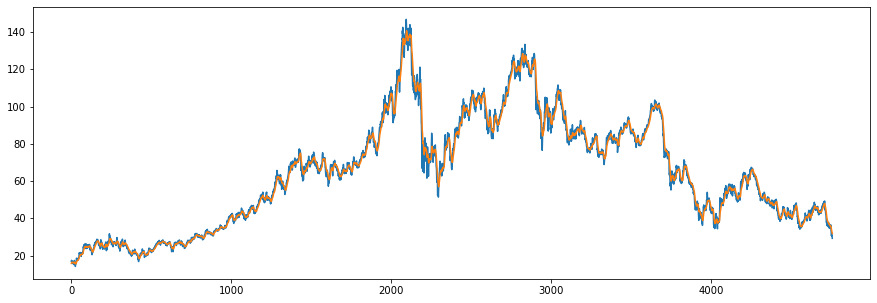

In [10]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/APA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)

y = labels
y = np.array(y)

X.shape

(4745, 15, 4)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 4337, 0.0: 210, 1.0: 198})

In [13]:
X = X/255

In [14]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [15]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [16]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('APA')]
    y = nr_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'APA')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('APA')]
    y = r_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'APA')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 42ms/step - loss: 0.3003 - accuracy: 0.4989 - mse: 0.3403 - weighted_accuracy: 0.3485 - weighted_mse: 0.3437 - val_loss: 0.3020 - val_accuracy: 0.0453 - val_mse: 0.3435 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3435
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2850 - accuracy: 0.2919 - mse: 0.3710 - weighted_accuracy: 0.4106 - weighted_mse: 0.3709 - val_loss: 0.2948 - val_accuracy: 0.0443 - val_mse: 0.3582 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3582
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2576 - accuracy: 0.1805 - mse: 0.4492 - weighted_accuracy: 0.4234 - weighted_mse: 0.4466 - val_loss: 0.2823 - val_accuracy: 0.0421 - val_mse: 0.3873 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3873
Epoch 4/20
30/30 [==============================] - 0s 9m

30/30 [==============================] - 0s 15ms/step - loss: 0.1808 - accuracy: 0.1934 - mse: 1.2935 - weighted_accuracy: 0.4957 - weighted_mse: 1.2683 - val_loss: 0.2138 - val_accuracy: 0.0421 - val_mse: 1.4104 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 1.4104
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1804 - accuracy: 0.1931 - mse: 1.2926 - weighted_accuracy: 0.4903 - weighted_mse: 1.2586 - val_loss: 0.2231 - val_accuracy: 0.0421 - val_mse: 1.7812 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 1.7812
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1794 - accuracy: 0.1905 - mse: 1.3125 - weighted_accuracy: 0.5005 - weighted_mse: 1.2798 - val_loss: 0.2439 - val_accuracy: 0.0421 - val_mse: 2.4819 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 2.4819
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1790 - accuracy: 0.2042 - mse: 1.3188 - weighted_accuracy: 0.4978 - weighted_mse: 1.282

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1682 - accuracy: 0.2173 - mse: 1.4027 - weighted_accuracy: 0.5398 - weighted_mse: 1.3490 - val_loss: 0.7359 - val_accuracy: 0.0421 - val_mse: 16.3137 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 16.3137
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1685 - accuracy: 0.1831 - mse: 1.4045 - weighted_accuracy: 0.5414 - weighted_mse: 1.3363 - val_loss: 0.7086 - val_accuracy: 0.0421 - val_mse: 16.7482 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 16.7482
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1672 - accuracy: 0.2031 - mse: 1.4286 - weighted_accuracy: 0.5481 - weighted_mse: 1.3664 - val_loss: 0.7184 - val_accuracy: 0.0421 - val_mse: 15.9923 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 15.9923
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1667 - accuracy: 0.2189 - mse: 1.4178 - weighted_accuracy: 0.5581 - we

7/7 [==============================] - 0s 4ms/step - loss: 0.3374 - accuracy: 0.0548 - mse: 3.7166 - weighted_accuracy: 0.0548 - weighted_mse: 3.7166
Test loss: 0.3374221920967102
Test accuracy: 0.054794520139694214


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 136
actual predicted holds: 0
Percentage buys correct: 8.0%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 48.25174825174825%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9603257607411696
Shares owned at the moment: 103
Cash capital at the moment: $0.8144343719295932


Price increase from previously bought: 4.88421308206

Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1562 - accuracy: 0.2337 - mse: 1.6356 - weighted_accuracy: 0.6051 - weighted_mse: 1.5523 - val_loss: 0.2991 - val_accuracy: 0.1981 - val_mse: 3.8545 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 3.8545
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1565 - accuracy: 0.2426 - mse: 1.6183 - weighted_accuracy: 0.5988 - weighted_mse: 1.5401 - val_loss: 0.2514 - val_accuracy: 0.1338 - val_mse: 2.6671 - val_weighted_accuracy: 0.1338 - val_weighted_mse: 2.6671
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1557 - accuracy: 0.1868 - mse: 1.6587 - weighted_accuracy: 0.5962 - weighted_mse: 1.5628 - val_loss: 0.1991 - val_accuracy: 0.2634 - val_mse: 2.0622 - val_weighted_accuracy: 0.2634 - val_weighted_mse: 2.0622
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1554 - accuracy: 0.2439 - mse: 1.6249 - weighted_accuracy: 0.6001 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2999 - accuracy: 0.0639 - mse: 2.8614 - weighted_accuracy: 0.0639 - weighted_mse: 2.8614
Test loss: 0.29991722106933594
Test accuracy: 0.06392694264650345


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 74
actual holds but predicted sell: 129
actual predicted holds: 1
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 4.411764705882353%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 51.21951219512195%
Percentage high sells correct: 48.148148148148145%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from previously 

Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1515 - accuracy: 0.2432 - mse: 1.7569 - weighted_accuracy: 0.6271 - weighted_mse: 1.6692 - val_loss: 0.2047 - val_accuracy: 0.3066 - val_mse: 1.4210 - val_weighted_accuracy: 0.3066 - val_weighted_mse: 1.4210
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1511 - accuracy: 0.2724 - mse: 1.7681 - weighted_accuracy: 0.6273 - weighted_mse: 1.6800 - val_loss: 0.2685 - val_accuracy: 0.1412 - val_mse: 3.0446 - val_weighted_accuracy: 0.1412 - val_weighted_mse: 3.0446
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.2771 - mse: 1.7477 - weighted_accuracy: 0.6156 - weighted_mse: 1.6706 - val_loss: 0.2548 - val_accuracy: 0.3288 - val_mse: 3.4446 - val_weighted_accuracy: 0.3288 - val_weighted_mse: 3.4446
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.2355 - mse: 1.7844 - weighted_accuracy: 0.6280 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2602 - accuracy: 0.1005 - mse: 2.7485 - weighted_accuracy: 0.1005 - weighted_mse: 2.7485
Test loss: 0.26019352674484253
Test accuracy: 0.1004566177725792


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 93
actual holds but predicted sell: 101
actual predicted holds: 10
Percentage buys correct: 6.862745098039215%
Percentage sells correct: 4.672897196261682%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 50.98039215686274%
Percentage high sells correct: 48.113207547169814%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from previously b

Epoch 6/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.2879 - mse: 1.8406 - weighted_accuracy: 0.6354 - weighted_mse: 1.7644 - val_loss: 0.1987 - val_accuracy: 0.3688 - val_mse: 3.3128 - val_weighted_accuracy: 0.3688 - val_weighted_mse: 3.3128
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1483 - accuracy: 0.2653 - mse: 1.8466 - weighted_accuracy: 0.6276 - weighted_mse: 1.7648 - val_loss: 0.2570 - val_accuracy: 0.1170 - val_mse: 2.2224 - val_weighted_accuracy: 0.1170 - val_weighted_mse: 2.2224
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1479 - accuracy: 0.2774 - mse: 1.8576 - weighted_accuracy: 0.6474 - weighted_mse: 1.7764 - val_loss: 0.1730 - val_accuracy: 0.5416 - val_mse: 1.1116 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 1.1116
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1475 - accuracy: 0.2993 - mse: 1.8759 - weighted_accuracy: 0.6211 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.2638 - accuracy: 0.1689 - mse: 2.5719 - weighted_accuracy: 0.1689 - weighted_mse: 2.5719
Test loss: 0.2638230621814728
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 2
actual holds but predicted buy: 153
actual holds but predicted sell: 24
actual predicted holds: 27
Percentage buys correct: 4.878048780487805%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 93.10344827586206%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 47.852760736196316%
Percentage high sells correct: 57.69230769230769%
Percentage mid holds correct: 79.3103448275862%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price i

30/30 [==============================] - 0s 7ms/step - loss: 0.1426 - accuracy: 0.3246 - mse: 1.9683 - weighted_accuracy: 0.6583 - weighted_mse: 1.9059 - val_loss: 0.2109 - val_accuracy: 0.4025 - val_mse: 3.3051 - val_weighted_accuracy: 0.4025 - val_weighted_mse: 3.3051
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1428 - accuracy: 0.3172 - mse: 2.0365 - weighted_accuracy: 0.6581 - weighted_mse: 1.9670 - val_loss: 0.2260 - val_accuracy: 0.2350 - val_mse: 2.1002 - val_weighted_accuracy: 0.2350 - val_weighted_mse: 2.1002
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.3090 - mse: 1.9745 - weighted_accuracy: 0.6607 - weighted_mse: 1.8991 - val_loss: 0.2406 - val_accuracy: 0.2202 - val_mse: 2.7812 - val_weighted_accuracy: 0.2202 - val_weighted_mse: 2.7812
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1430 - accuracy: 0.3406 - mse: 1.9586 - weighted_accuracy: 0.6603 - weighted_mse: 1.9025

30/30 [==============================] - 0s 9ms/step - loss: 0.1405 - accuracy: 0.3272 - mse: 2.0234 - weighted_accuracy: 0.6694 - weighted_mse: 1.9717 - val_loss: 0.1682 - val_accuracy: 0.5195 - val_mse: 1.8941 - val_weighted_accuracy: 0.5195 - val_weighted_mse: 1.8941
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1417 - accuracy: 0.3306 - mse: 1.9969 - weighted_accuracy: 0.6650 - weighted_mse: 1.9317 - val_loss: 0.2111 - val_accuracy: 0.3656 - val_mse: 2.5853 - val_weighted_accuracy: 0.3656 - val_weighted_mse: 2.5853
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.3340 - mse: 2.0171 - weighted_accuracy: 0.6757 - weighted_mse: 1.9544 - val_loss: 0.3890 - val_accuracy: 0.1370 - val_mse: 3.4154 - val_weighted_accuracy: 0.1370 - val_weighted_mse: 3.4154
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1408 - accuracy: 0.3485 - mse: 2.0357 - weighted_accuracy: 0.6616 - weighted_mse: 1.9750 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.5982 - mse: 2.6756 - weighted_accuracy: 0.5982 - weighted_mse: 2.6756
Test loss: 0.15708070993423462
Test accuracy: 0.5981734991073608


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 64
actual holds but predicted sell: 16
actual predicted holds: 124
Percentage buys correct: 9.722222222222221%
Percentage sells correct: 0.0%
Percentage holds correct: 94.65648854961832%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.38461538461539%


Capital: 100
Share price: $0.9933061950990499
Shares owned at the moment: 100
Cash capital at the moment: $0.396221286442767


Price increase from previously bought: -88.77637

Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.3899 - mse: 2.2064 - weighted_accuracy: 0.6785 - weighted_mse: 2.1759 - val_loss: 0.1559 - val_accuracy: 0.5827 - val_mse: 2.4421 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 2.4421
Validation loss: 0.1558619737625122
Validation accuracy: 0.5827186703681946


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1608 - accuracy: 0.5505 - mse: 2.4853 - weighted_accuracy: 0.5505 - weighted_mse: 2.4853
Test loss: 0.16078411042690277
Test accuracy: 0.5504587292671204


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 60
actual holds but predicted sell: 29
actual predicted holds: 112
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.451612903225806

Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1343 - accuracy: 0.3767 - mse: 2.2958 - weighted_accuracy: 0.6879 - weighted_mse: 2.2499 - val_loss: 0.3215 - val_accuracy: 0.2287 - val_mse: 3.7877 - val_weighted_accuracy: 0.2287 - val_weighted_mse: 3.7877
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.3978 - mse: 2.3352 - weighted_accuracy: 0.7049 - weighted_mse: 2.2992 - val_loss: 0.1299 - val_accuracy: 0.7492 - val_mse: 2.0590 - val_weighted_accuracy: 0.7492 - val_weighted_mse: 2.0590
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1336 - accuracy: 0.3967 - mse: 2.3379 - weighted_accuracy: 0.6996 - weighted_mse: 2.2970 - val_loss: 0.3292 - val_accuracy: 0.3056 - val_mse: 3.2683 - val_weighted_accuracy: 0.3056 - val_weighted_mse: 3.2683
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.4091 - mse: 2.3189 - weighted_accuracy: 0.6932 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.3333 - mse: 2.7501 - weighted_accuracy: 0.3333 - weighted_mse: 2.7501
Test loss: 0.22847436368465424
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 49
actual holds but predicted sell: 92
actual predicted holds: 63
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 5.1020408163265305%
Percentage holds correct: 94.02985074626865%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 51.851851851851855%
Percentage high sells correct: 46.93877551020408%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.990863220095704
Shares owned at the moment: 100
Cash capital at the moment: $0.6411906049032723


Price in

In [19]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.041284      4.128440       0.000000       0.000000   
1       0.041284      4.128440       0.000000       0.000000   
2       0.082569     10.126582       5.839416     100.000000   
3       0.073394      9.411765       6.015038       0.000000   
4       0.142202      8.000000       7.000000      88.888889   
5       0.165138      5.454545      11.538462      88.888889   
6       0.344037      7.368421       7.407407      92.753623   
7       0.610092      9.375000      10.000000      93.283582   
8       0.550459      9.090909       6.451613      92.561983   
9       0.293578      8.823529       7.291667      94.444444   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         39.170507            0.000000           0.000000     -62.606003   
1         39.170507            0.000000           0.000000     -62.606003   
2         55.696203           44.852941          50.000000     206.967195   
3         51.764706           45.454545           0.000000      72.312285   
4         50.000000           48.000000          70.588235     -13.000893   
5         43.030303           50.000000          84.615385     -66.287931   
6         49.473684           44.444444          82.352941     -61.741843   
7         59.375000           55.000000          83.458647     -65.831292   
8         53.030303           41.935484          80.000000       4.460269   
9         54.411765           48.421053          81.481481     109.207444   

   buy_n_hold profit  
0         -62.606003  
1         -62.606003  
2         -62.606003  
3         -62.606003  
4         -62.606003  
5         -62.606003  
6         -62.606003  
7         -62.606003  
8         -62.606003  
9         -62.606003

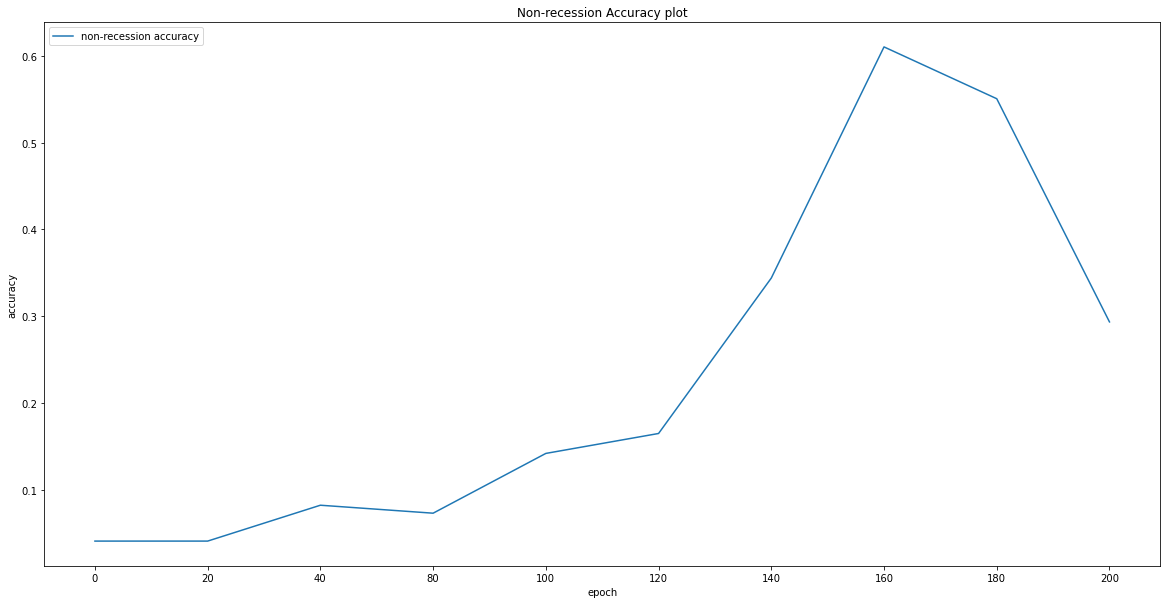

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

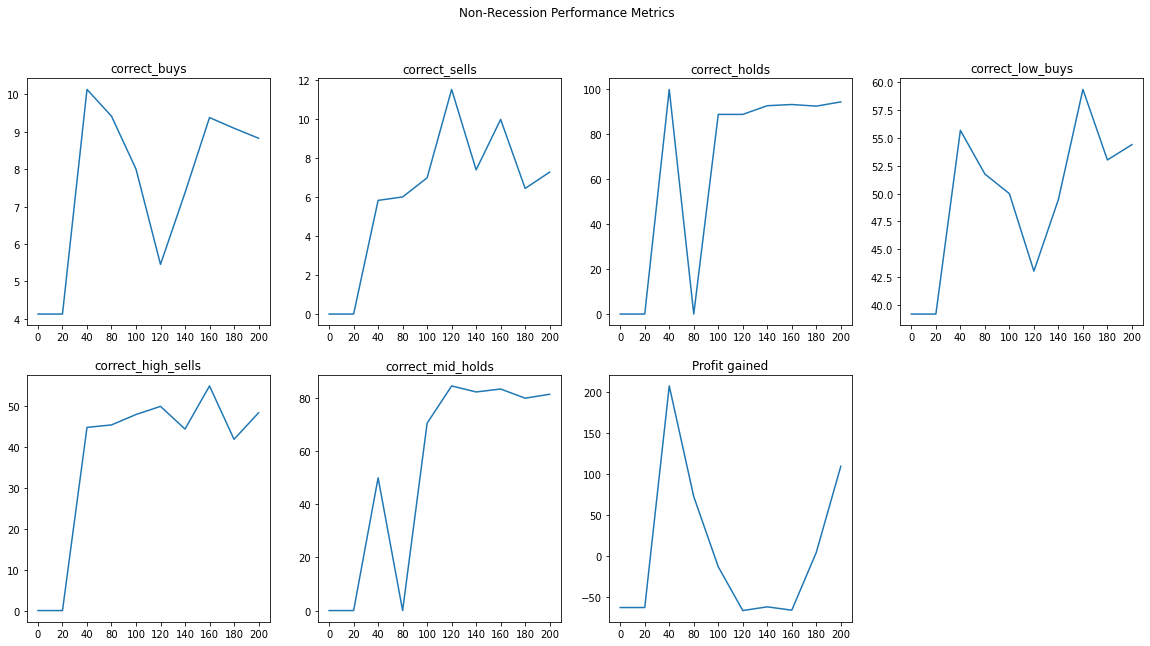

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

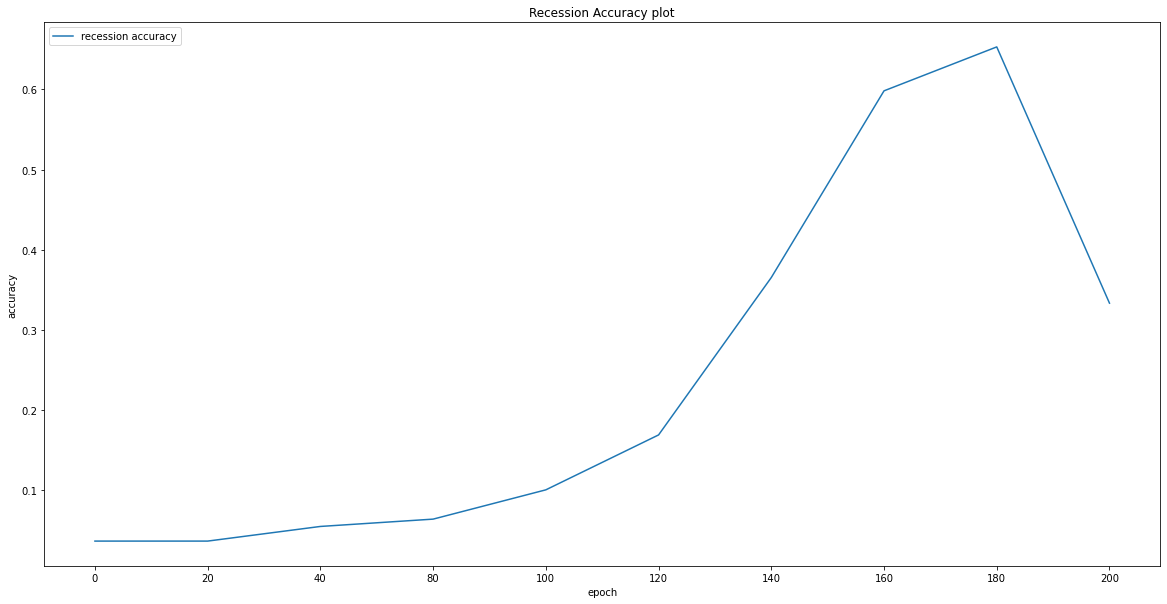

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

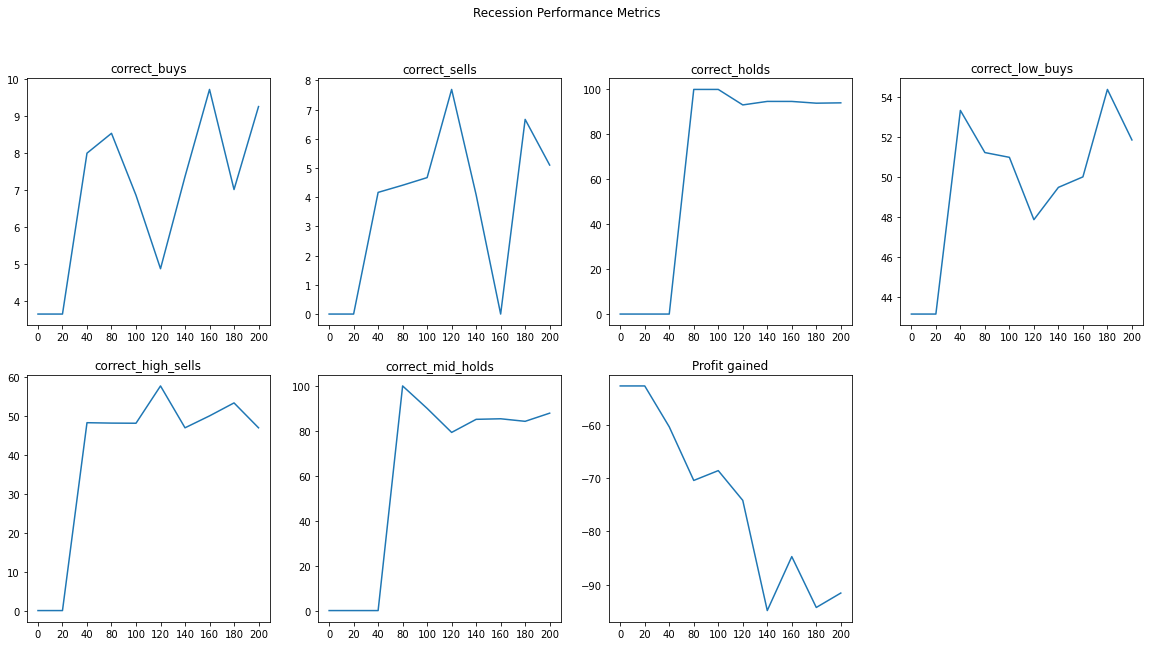

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Supporting Stock Price

In [24]:
nr_test_sets = ['APA']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/XOM_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    72.989998  71.473540  -4.975176  60118400.0     2.0
2019-01-23    71.889999  71.537611 -23.217277  45082800.0     2.0
2019-01-24    71.300003  71.501056 -40.365066  31895600.0     2.0
2019-01-25    71.400002  71.485509 -48.091584  43168100.0     2.0
2019-01-28    71.720001  71.521585 -59.245237  52164300.0     1.0


In [25]:
r_test_sets = ['APA']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/XOM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    print(df.head())
    
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7    support  labels
Date                                                                        
2020-01-22    31.740000  30.898076 -22.580653  22551800.0  67.580002     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0  67.190002     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0  66.769997     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0  66.320000     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0  64.739998     2.0

### training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    16.829004  15.783375 -11.666669   832986.0     0.0
2000-01-24    17.424242  16.035816 -16.883143  3962574.0     2.0
2000-01-25    16.964287  16.178658 -27.922065  1711248.0     2.0
2000-01-26    17.153681  16.328661 -24.324314  3808959.0     2.0
2000-01-27    16.964287  16.426450 -34.399988  2355969.0     2.0
            previous_1d     EMA_12   willr_14      OBV_7   support  labels
Date                                                                      
2000-01-21    16.829004  15.783375 -11.666669   832986.0  41.84375     0.0
2000-01-24    17.424242  16.035816 -16.883143  3962574.0  42.50000     2.0
2000-01-25    16.964287  16.178658 -27.922065  1711248.0  42.12500     2.0
2000-01-26    17.153681  16.328661 -24.324314  3808959.0  42.03125     2.0
2000-01-27    16.964287  16.426450 -34.399988  2355969.0  41.75000     2.0


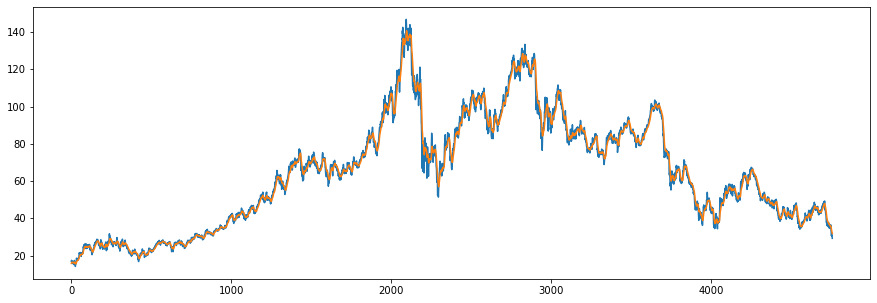

In [26]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/APA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/XOM_data.csv")
df2.set_index('Date', inplace=True)
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)

In [27]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [28]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [29]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [31]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('APA')]
    y = nr_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'APA')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('APA')]
    y = r_test_data['{}_y'.format('APA')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('APA'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'APA')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'APA'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'APA'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.531746031746032, 1: 8.0084388185654, 2: 0.36464937560038424}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2970 - accuracy: 0.5506 - mse: 0.4368 - weighted_accuracy: 0.3190 - weighted_mse: 0.5311 - val_loss: 0.3012 - val_accuracy: 0.0390 - val_mse: 0.3541 - val_weighted_accuracy: 0.0390 - val_weighted_mse: 0.3541
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2130 - accuracy: 0.3865 - mse: 0.7561 - weighted_accuracy: 0.4346 - weighted_mse: 0.7537 - val_loss: 0.2929 - val_accuracy: 0.0421 - val_mse: 0.3803 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3803
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1913 - accuracy: 0.3109 - mse: 0.9984 - weighted_accuracy: 0.4727 - weighted_mse: 0.9721 - val_loss: 0.2809 - val_accuracy: 0.0421 - val_mse: 0.4147 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.4147
Epoch 4/20
30/30 [==============================] - 0s 7ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.4064 - mse: 1.3328 - weighted_accuracy: 0.4064 - weighted_mse: 1.3328
Test loss: 0.18200215697288513
Test accuracy: 0.4063926935195923


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 37
actual predicted holds: 79
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 94.04761904761905%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 51.16279069767442%
Percentage mid holds correct: 85.5421686746988%


Capital: 100
Share price: $1.0059283232205738
Shares owned at the moment: 99
Cash capital at the moment: $0.1392320151663995


Price in

Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1223 - accuracy: 0.4995 - mse: 1.6805 - weighted_accuracy: 0.7713 - weighted_mse: 1.6318 - val_loss: 0.1808 - val_accuracy: 0.4805 - val_mse: 1.6633 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 1.6633
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.4982 - mse: 1.7346 - weighted_accuracy: 0.7803 - weighted_mse: 1.6873 - val_loss: 0.1815 - val_accuracy: 0.4594 - val_mse: 1.7023 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 1.7023
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1202 - accuracy: 0.5440 - mse: 1.7096 - weighted_accuracy: 0.7955 - weighted_mse: 1.6914 - val_loss: 0.1894 - val_accuracy: 0.4289 - val_mse: 1.7298 - val_weighted_accuracy: 0.4289 - val_weighted_mse: 1.7298
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.5163 - mse: 1.7649 - weighted_accuracy: 0.7756 - weighted




RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1137 - accuracy: 0.5651 - mse: 1.8097 - weighted_accuracy: 0.8029 - weighted_mse: 1.8024 - val_loss: 0.1800 - val_accuracy: 0.4879 - val_mse: 1.8362 - val_weighted_accuracy: 0.4879 - val_weighted_mse: 1.8362
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.5580 - mse: 1.8517 - weighted_accuracy: 0.8139 - weighted_mse: 1.8309 - val_loss: 0.1794 - val_accuracy: 0.4921 - val_mse: 1.8649 - val_weighted_accuracy: 0.4921 - val_weighted_mse: 1.8649
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1112 - accuracy: 0.5803 - mse: 1.8665 - weighted_accuracy: 0.8145 - weighted_mse: 1.8623 - val_loss: 0.1908 - val_accuracy: 0.4447 - val_mse: 1.8753 - val_weighted_accuracy: 0.4447 - val_weighted_mse: 1.8753
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.5790 - mse: 1.9041 - weighted_ac

7/7 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.5479 - mse: 2.4392 - weighted_accuracy: 0.5479 - weighted_mse: 2.4392
Test loss: 0.16633489727973938
Test accuracy: 0.5479452013969421


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 37
actual holds but predicted sell: 53
actual predicted holds: 114
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 7.017543859649122%
Percentage holds correct: 92.6829268292683%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 83.73983739837398%


Capital: 100
Share price: $0.990863220095704
Shares owned at the moment: 100
Cash capital at the moment: $0.6411906049032723


Price inc

Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0790 - accuracy: 0.7432 - mse: 2.8152 - weighted_accuracy: 0.9007 - weighted_mse: 2.8807 - val_loss: 0.1746 - val_accuracy: 0.5827 - val_mse: 2.9253 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 2.9253
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 0.7492 - mse: 2.7992 - weighted_accuracy: 0.9010 - weighted_mse: 2.8628 - val_loss: 0.1499 - val_accuracy: 0.6934 - val_mse: 3.0112 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 3.0112
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.7400 - mse: 2.8733 - weighted_accuracy: 0.8957 - weighted_mse: 2.9434 - val_loss: 0.1658 - val_accuracy: 0.6459 - val_mse: 2.9498 - val_weighted_accuracy: 0.6459 - val_weighted_mse: 2.9498
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.7563 - mse: 2.8893 - weighted_accuracy: 0.9035 - weighted

0         -52.682679  



RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.7914 - mse: 3.1044 - weighted_accuracy: 0.9144 - weighted_mse: 3.2241 - val_loss: 0.1733 - val_accuracy: 0.6217 - val_mse: 3.2245 - val_weighted_accuracy: 0.6217 - val_weighted_mse: 3.2245
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0691 - accuracy: 0.7771 - mse: 3.1675 - weighted_accuracy: 0.9150 - weighted_mse: 3.2760 - val_loss: 0.1755 - val_accuracy: 0.6428 - val_mse: 3.4954 - val_weighted_accuracy: 0.6428 - val_weighted_mse: 3.4954
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0682 - accuracy: 0.7916 - mse: 3.2173 - weighted_accuracy: 0.9184 - weighted_mse: 3.3196 - val_loss: 0.1962 - val_accuracy: 0.5753 - val_mse: 3.2181 - val_weighted_accuracy: 0.5753 - val_weighted_mse: 3.2181
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 0.7916 - m

7/7 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.7443 - mse: 4.1930 - weighted_accuracy: 0.7443 - weighted_mse: 4.1930
Test loss: 0.13666072487831116
Test accuracy: 0.7442922592163086


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 23
actual predicted holds: 159
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 93.52941176470588%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 39.130434782608695%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.22986971123568717
Shares owned at the moment: 433
Cash capital at the moment: $0.19269767629356238


Price increase 

Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.8815 - mse: 5.3705 - weighted_accuracy: 0.9529 - weighted_mse: 5.3039 - val_loss: 0.1854 - val_accuracy: 0.7439 - val_mse: 6.2446 - val_weighted_accuracy: 0.7439 - val_weighted_mse: 6.2446
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.8780 - mse: 5.3878 - weighted_accuracy: 0.9536 - weighted_mse: 5.3007 - val_loss: 0.1992 - val_accuracy: 0.6881 - val_mse: 5.4239 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 5.4239
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.8894 - mse: 5.4431 - weighted_accuracy: 0.9559 - weighted_mse: 5.3060 - val_loss: 0.1901 - val_accuracy: 0.7260 - val_mse: 5.7195 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 5.7195
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0408 - accuracy: 0.8904 - mse: 5.5111 - weighted_accuracy: 0.9600 - weighted

30/30 [==============================] - 0s 8ms/step - loss: 0.0383 - accuracy: 0.8933 - mse: 5.8720 - weighted_accuracy: 0.9592 - weighted_mse: 5.7168 - val_loss: 0.1942 - val_accuracy: 0.7661 - val_mse: 6.6219 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 6.6219
Epoch 6/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0387 - accuracy: 0.8973 - mse: 6.0937 - weighted_accuracy: 0.9625 - weighted_mse: 5.8492 - val_loss: 0.2063 - val_accuracy: 0.7060 - val_mse: 6.1034 - val_weighted_accuracy: 0.7060 - val_weighted_mse: 6.1034
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9046 - mse: 6.1134 - weighted_accuracy: 0.9652 - weighted_mse: 5.9200 - val_loss: 0.1992 - val_accuracy: 0.7334 - val_mse: 6.1415 - val_weighted_accuracy: 0.7334 - val_weighted_mse: 6.1415
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9162 - mse: 6.2353 - weighted_accuracy: 0.9676 - weighted_mse: 6.0090 - 

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9326 - mse: 7.3148 - weighted_accuracy: 0.9735 - weighted_mse: 6.9079 - val_loss: 0.2104 - val_accuracy: 0.7840 - val_mse: 7.5990 - val_weighted_accuracy: 0.7840 - val_weighted_mse: 7.5990
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9283 - mse: 7.3298 - weighted_accuracy: 0.9739 - weighted_mse: 6.9623 - val_loss: 0.2197 - val_accuracy: 0.7829 - val_mse: 8.2001 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 8.2001
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0281 - accuracy: 0.9305 - mse: 7.5696 - weighted_accuracy: 0.9728 - weighted_mse: 7.0437 - val_loss: 0.2492 - val_accuracy: 0.7028 - val_mse: 7.6329 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 7.6329
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0286 - accuracy: 0.9328 - mse: 7.7355 - weighted_accuracy: 0.9736 - weighted_mse




RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0227 - accuracy: 0.9510 - mse: 9.2535 - weighted_accuracy: 0.9802 - weighted_mse: 8.4505 - val_loss: 0.2441 - val_accuracy: 0.8008 - val_mse: 9.8874 - val_weighted_accuracy: 0.8008 - val_weighted_mse: 9.8874
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9468 - mse: 9.2889 - weighted_accuracy: 0.9806 - weighted_mse: 8.5218 - val_loss: 0.2496 - val_accuracy: 0.7977 - val_mse: 10.6052 - val_weighted_accuracy: 0.7977 - val_weighted_mse: 10.6052
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9497 - mse: 9.6029 - weighted_accuracy: 0.9817 - weighted_mse: 8.6294 - val_loss: 0.2897 - val_accuracy: 0.7144 - val_mse: 9.5886 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 9.5886
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9523 - mse: 9.7928 - weighte

Price increase from previously bought: 1.7163856309696968%
Share price: $0.3328827299191417
Shares owned at the moment: 0
Cash capital at the moment: $101.43402217848887


Share price: $0.2856514656636571
Shares owned at the moment: 354
Cash capital at the moment: $0.0353216317306817


Price increase from previously bought: 27.871179125629798%
Share price: $0.36627037855142974
Shares owned at the moment: 0
Cash capital at the moment: $129.338471425417


Share price: $0.4876058650815275
Shares owned at the moment: 264
Cash capital at the moment: $0.25652118584454797


Price increase from previously bought: -51.73765394462304%
Share price: $0.2359771875744392
Shares owned at the moment: 0
Cash capital at the moment: $62.38317926731745


Share price: $0.22091204561918193
Shares owned at the moment: 281
Cash capital at the moment: $0.13618466507509908




Capital at the end of test period: $131.98447462636747
profit gained: 31.984474626367472%


Capital at the end of test period if Buy and

7/7 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.8447 - mse: 13.6477 - weighted_accuracy: 0.8447 - weighted_mse: 13.6477
Test loss: 0.18656222522258759
Test accuracy: 0.844748854637146


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 11
actual holds but predicted sell: 10
actual predicted holds: 183
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 93.36734693877551%
actual buys: 8
actual sells: 7
actual holds: 204


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 84.18367346938776%


Capital: 100
Share price: $0.32636807813636975
Shares owned at the moment: 305
Cash capital at the moment: $0.18399494287034202


Pric

In [32]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.394495      9.195402       7.547170      94.871795   
1       0.490826     10.714286       9.677419      95.000000   
2       0.614679      7.317073       9.756098      93.382353   
3       0.655963      7.317073       0.000000      90.909091   
4       0.752294      9.090909       0.000000      91.525424   
5       0.793578      7.142857       0.000000      91.489362   
6       0.811927      0.000000       0.000000      91.237113   
7       0.844037      8.333333       0.000000      91.959799   
8       0.857798      9.090909       0.000000      92.079208   
9       0.862385      0.000000       0.000000      91.707317   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         51.162791           50.943396          85.897436     -72.931094   
1         54.545455           48.387097          84.000000     -75.723302   
2         50.000000           48.780488          81.617647     -81.353675   
3         42.500000           56.521739          79.220779     -82.528872   
4         61.904762           57.894737          80.225989     -83.388410   
5         64.285714           68.750000          80.213904     -73.461581   
6         54.545455           66.666667          80.412371     -86.014788   
7         66.666667           57.142857          81.313131     -85.766055   
8         70.000000           80.000000          81.683168     -83.877452   
9         66.666667           75.000000          81.372549     -84.400003   

   buy_n_hold profit  
0         -62.606003  
1         -62.606003  
2         -62.606003  
3         -62.606003  
4         -62.606003  
5         -62.606003  
6         -62.606003  
7         -62.606003  
8         -62.606003  
9         -62.606003

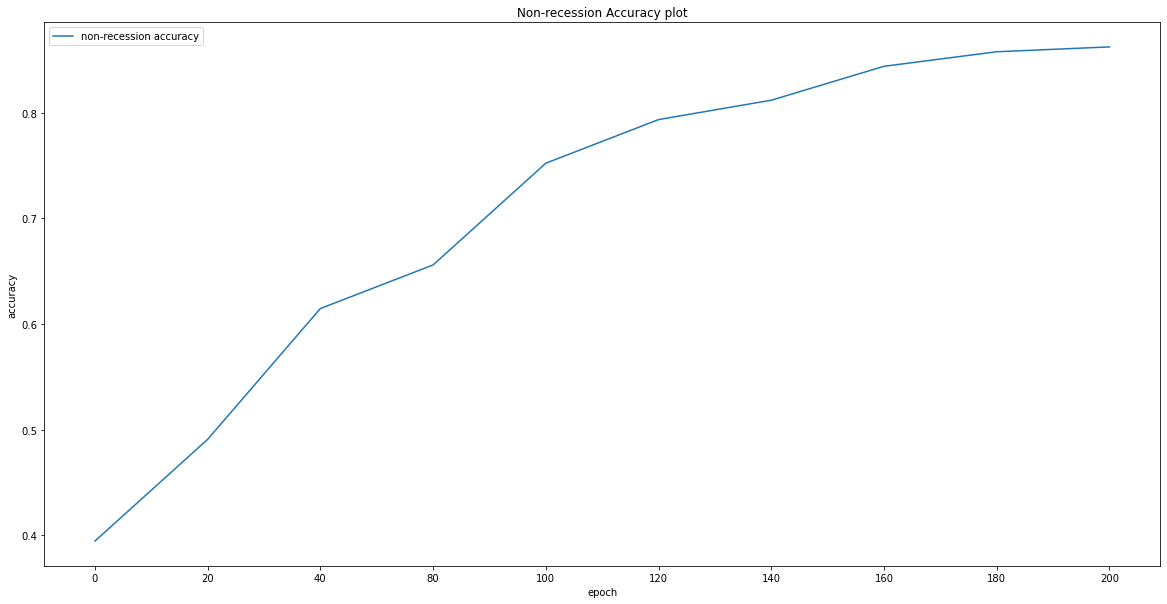

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

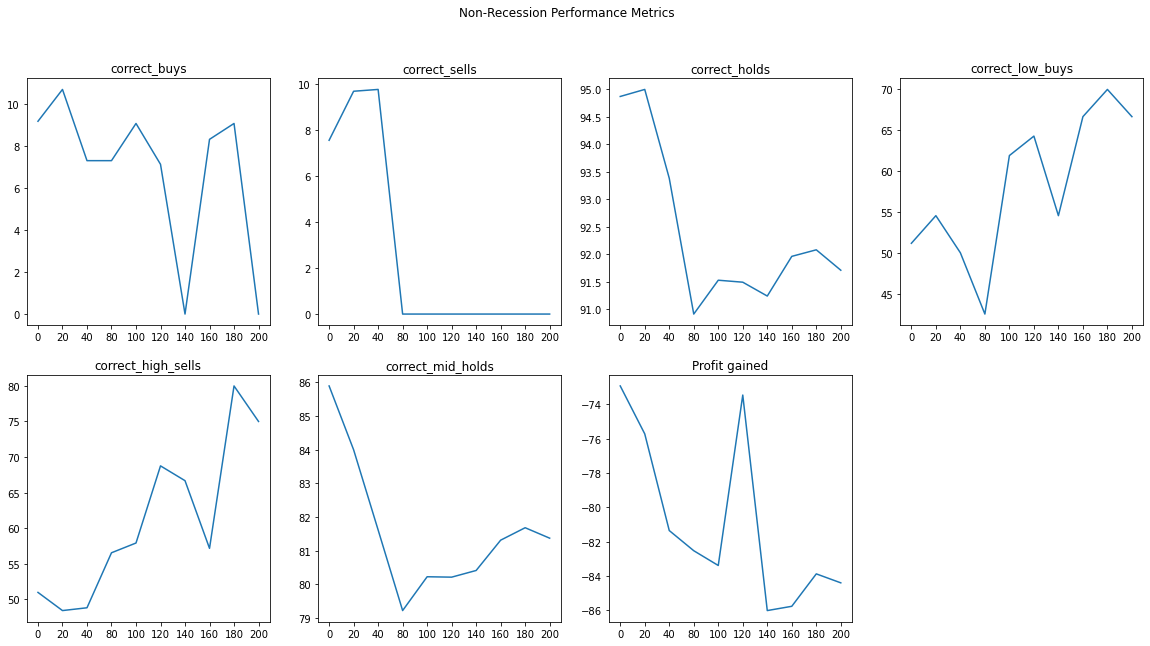

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

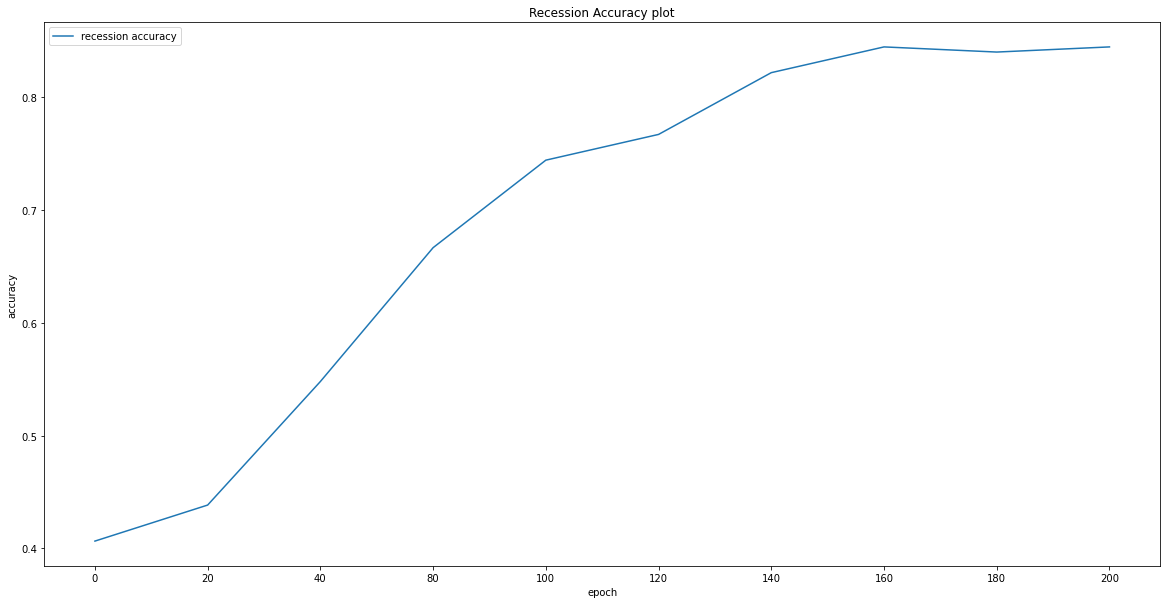

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

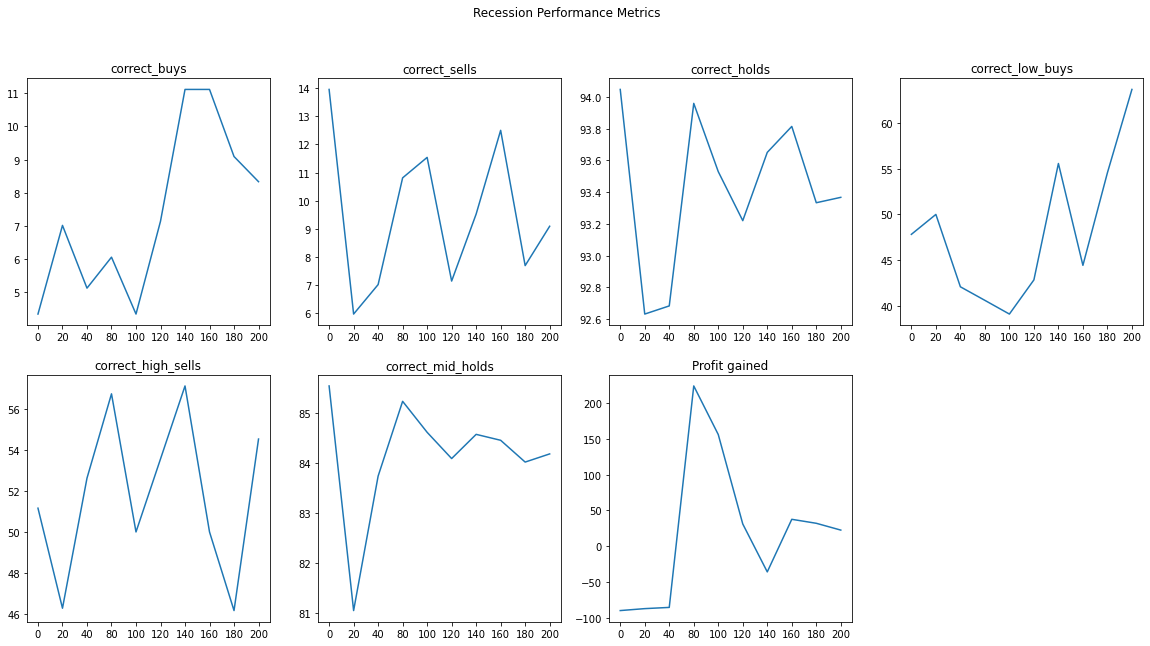

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## JetBlue Airways Corporation

### No support Stock Price

In [305]:
nr_test_sets = ['JBLU']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    X.shape
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [306]:
r_test_sets = ['JBLU']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


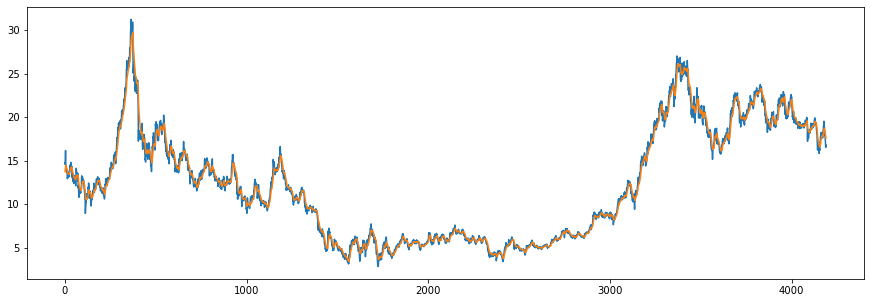

(4175, 15, 4)

In [307]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [308]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [309]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [310]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [311]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [312]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JBLU')]
    y = nr_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JBLU')]
    y = r_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}



RUNNING EPOCHS 0 - 20



Epoch 1/20
27/27 [==============================] - 1s 34ms/step - loss: 0.2954 - accuracy: 0.5240 - mse: 0.4366 - weighted_accuracy: 0.3266 - weighted_mse: 0.5115 - val_loss: 0.3001 - val_accuracy: 0.0431 - val_mse: 0.3519 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 0.3519
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 0.2146 - accuracy: 0.3719 - mse: 0.7316 - weighted_accuracy: 0.4459 - weighted_mse: 0.7193 - val_loss: 0.2934 - val_accuracy: 0.0443 - val_mse: 0.3776 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3776
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1913 - accuracy: 0.3216 - mse: 0.9504 - weighted_accuracy: 0.4956 - weighted_mse: 0.9196 - val_loss: 0.2855 - val_accuracy: 0.0443 - val_mse: 0.4121 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.4121
Epoch 4/20
27/27 [==============================] - 0s 7

7/7 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.3607 - mse: 1.3918 - weighted_accuracy: 0.3607 - weighted_mse: 1.3918
Test loss: 0.19020381569862366
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 46
actual holds but predicted sell: 86
actual predicted holds: 65
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 9.473684210526315%
Percentage holds correct: 90.27777777777777%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.526315789473685%
Percentage mid holds correct: 84.50704225352112%


Capital: 100
Share price: $0.6025170038678631
Shares owned at the moment: 165
Cash capital at the moment: $0.3113022712975493


Price increase fro

Epoch 18/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.4425 - mse: 1.8144 - weighted_accuracy: 0.7431 - weighted_mse: 1.7450 - val_loss: 0.1948 - val_accuracy: 0.3749 - val_mse: 1.8448 - val_weighted_accuracy: 0.3749 - val_weighted_mse: 1.8448
Epoch 19/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1259 - accuracy: 0.4751 - mse: 1.7893 - weighted_accuracy: 0.7530 - weighted_mse: 1.7471 - val_loss: 0.2012 - val_accuracy: 0.3341 - val_mse: 1.8520 - val_weighted_accuracy: 0.3341 - val_weighted_mse: 1.8520
Epoch 20/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1246 - accuracy: 0.4790 - mse: 1.8296 - weighted_accuracy: 0.7585 - weighted_mse: 1.7828 - val_loss: 0.1849 - val_accuracy: 0.4204 - val_mse: 1.8889 - val_weighted_accuracy: 0.4204 - val_weighted_mse: 1.8889
Validation loss: 0.18488095700740814
Validation accuracy: 0.4203592836856842


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

Share price: $0.2372108726143099
Shares owned at the moment: 226
Cash capital at the moment: $0.057794893246118306


Price increase from previously bought: 15.74137490590688%
Share price: $0.2753061409849244
Shares owned at the moment: 0
Cash capital at the moment: $62.105879989216895


Share price: $0.3460544409225172
Shares owned at the moment: 178
Cash capital at the moment: $0.3387958561772635


Price increase from previously bought: -1.0584066895570676%
Share price: $0.34333335495860223
Shares owned at the moment: 0
Cash capital at the moment: $61.28407136155622


Share price: $0.3297279251390281
Shares owned at the moment: 185
Cash capital at the moment: $0.11665612892154797


Price increase from previously bought: 71.12007614116207%
Share price: $0.5657823109171094
Shares owned at the moment: 0
Cash capital at the moment: $104.49854189790771


Share price: $0.5399319618220149
Shares owned at the moment: 193
Cash capital at the moment: $0.0051043775218033716




Capital at the en

7/7 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.6210 - mse: 2.1329 - weighted_accuracy: 0.6210 - weighted_mse: 2.1329
Test loss: 0.15630324184894562
Test accuracy: 0.621004581451416


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 36
actual holds but predicted sell: 34
actual predicted holds: 127
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 14.634146341463415%
Percentage holds correct: 91.36690647482014%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 58.53658536585366%
Percentage mid holds correct: 85.5072463768116%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the moment: $0.052493461289031984


Pr

27/27 [==============================] - 0s 8ms/step - loss: 0.0989 - accuracy: 0.6479 - mse: 2.4880 - weighted_accuracy: 0.8373 - weighted_mse: 2.5454 - val_loss: 0.1796 - val_accuracy: 0.5246 - val_mse: 2.4289 - val_weighted_accuracy: 0.5246 - val_weighted_mse: 2.4289
Epoch 17/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0983 - accuracy: 0.6611 - mse: 2.5086 - weighted_accuracy: 0.8506 - weighted_mse: 2.5665 - val_loss: 0.1838 - val_accuracy: 0.5210 - val_mse: 2.5899 - val_weighted_accuracy: 0.5210 - val_weighted_mse: 2.5899
Epoch 18/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0975 - accuracy: 0.6413 - mse: 2.5674 - weighted_accuracy: 0.8476 - weighted_mse: 2.6255 - val_loss: 0.1865 - val_accuracy: 0.5222 - val_mse: 2.7233 - val_weighted_accuracy: 0.5222 - val_weighted_mse: 2.7233
Epoch 19/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0965 - accuracy: 0.6680 - mse: 2.5484 - weighted_accuracy: 0.8552 - weighted_mse: 2.6243

Epoch 1/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0942 - accuracy: 0.6560 - mse: 2.6293 - weighted_accuracy: 0.8635 - weighted_mse: 2.7122 - val_loss: 0.1765 - val_accuracy: 0.5677 - val_mse: 2.6876 - val_weighted_accuracy: 0.5677 - val_weighted_mse: 2.6876
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.6386 - mse: 2.6003 - weighted_accuracy: 0.8401 - weighted_mse: 2.6648 - val_loss: 0.1903 - val_accuracy: 0.5138 - val_mse: 2.2407 - val_weighted_accuracy: 0.5138 - val_weighted_mse: 2.2407
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.6518 - mse: 2.5695 - weighted_accuracy: 0.8469 - weighted_mse: 2.6504 - val_loss: 0.1927 - val_accuracy: 0.4970 - val_mse: 2.7423 - val_weighted_accuracy: 0.4970 - val_weighted_mse: 2.7423
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0934 - accuracy: 0.6518 - mse: 2.6859 - weighted_accuracy: 0.8555 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.7352 - mse: 3.2203 - weighted_accuracy: 0.7352 - weighted_mse: 3.2203
Test loss: 0.14006105065345764
Test accuracy: 0.7351598143577576


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 19
actual predicted holds: 155
Percentage buys correct: 8.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 91.17647058823529%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 56.0%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 85.79881656804734%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previousl

27/27 [==============================] - 0s 9ms/step - loss: 0.0685 - accuracy: 0.7904 - mse: 3.7970 - weighted_accuracy: 0.9190 - weighted_mse: 3.9256 - val_loss: 0.1788 - val_accuracy: 0.6491 - val_mse: 3.7476 - val_weighted_accuracy: 0.6491 - val_weighted_mse: 3.7476
Epoch 20/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.7937 - mse: 3.8856 - weighted_accuracy: 0.9117 - weighted_mse: 4.0286 - val_loss: 0.1724 - val_accuracy: 0.6467 - val_mse: 4.0060 - val_weighted_accuracy: 0.6467 - val_weighted_mse: 4.0060
Validation loss: 0.1723695546388626
Validation accuracy: 0.6467065811157227


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.5917 - mse: 4.0853 - weighted_accuracy: 0.5917 - weighted_mse: 4.0853
Test loss: 0.19489248096942902
Test accuracy: 0.5917431116104126


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sel

Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.7826 - mse: 3.9829 - weighted_accuracy: 0.9097 - weighted_mse: 4.1178 - val_loss: 0.2159 - val_accuracy: 0.5593 - val_mse: 4.0262 - val_weighted_accuracy: 0.5593 - val_weighted_mse: 4.0262
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.7826 - mse: 4.0170 - weighted_accuracy: 0.9140 - weighted_mse: 4.1221 - val_loss: 0.1722 - val_accuracy: 0.6683 - val_mse: 4.3229 - val_weighted_accuracy: 0.6683 - val_weighted_mse: 4.3229
Epoch 6/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.8009 - mse: 4.0541 - weighted_accuracy: 0.9250 - weighted_mse: 4.1677 - val_loss: 0.1657 - val_accuracy: 0.7054 - val_mse: 4.3467 - val_weighted_accuracy: 0.7054 - val_weighted_mse: 4.3467
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.8162 - mse: 4.1359 - weighted_accuracy: 0.9305 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.7671 - mse: 5.1575 - weighted_accuracy: 0.7671 - weighted_mse: 5.1575
Test loss: 0.14097250998020172
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 16
actual predicted holds: 165
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 89.67391304347827%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 84.69945355191257%


Capital: 100
Share price: $0.48619046537784155
Shares owned at the moment: 205
Cash capital at the moment: $0.05686472268573084


Pri

27/27 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.8707 - mse: 5.9627 - weighted_accuracy: 0.9441 - weighted_mse: 5.9937 - val_loss: 0.1740 - val_accuracy: 0.7329 - val_mse: 6.0667 - val_weighted_accuracy: 0.7329 - val_weighted_mse: 6.0667
Validation loss: 0.17399071156978607
Validation accuracy: 0.7329341173171997


Non-Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.6881 - mse: 6.0665 - weighted_accuracy: 0.6881 - weighted_mse: 6.0665
Test loss: 0.20037943124771118
Test accuracy: 0.6880733966827393


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 32
actual holds but predicted sell: 23
actual predicted holds: 145
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 4.166666666666667%
Percentag

27/27 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.8811 - mse: 6.4288 - weighted_accuracy: 0.9503 - weighted_mse: 6.3645 - val_loss: 0.1787 - val_accuracy: 0.7329 - val_mse: 6.5434 - val_weighted_accuracy: 0.7329 - val_weighted_mse: 6.5434
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.8877 - mse: 6.4319 - weighted_accuracy: 0.9567 - weighted_mse: 6.3268 - val_loss: 0.2108 - val_accuracy: 0.6731 - val_mse: 6.1471 - val_weighted_accuracy: 0.6731 - val_weighted_mse: 6.1471
Epoch 8/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.8740 - mse: 6.5493 - weighted_accuracy: 0.9518 - weighted_mse: 6.4646 - val_loss: 0.1952 - val_accuracy: 0.6922 - val_mse: 6.2888 - val_weighted_accuracy: 0.6922 - val_weighted_mse: 6.2888
Epoch 9/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.8874 - mse: 6.6536 - weighted_accuracy: 0.9546 - weighted_mse: 6.5287 - 

0         -44.844083  



RUNNING EPOCHS 180 - 200



Epoch 1/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0370 - accuracy: 0.8994 - mse: 7.2596 - weighted_accuracy: 0.9610 - weighted_mse: 7.2243 - val_loss: 0.1906 - val_accuracy: 0.7725 - val_mse: 7.8427 - val_weighted_accuracy: 0.7725 - val_weighted_mse: 7.8427
Epoch 2/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9036 - mse: 7.5053 - weighted_accuracy: 0.9626 - weighted_mse: 7.3194 - val_loss: 0.2053 - val_accuracy: 0.7749 - val_mse: 7.8763 - val_weighted_accuracy: 0.7749 - val_weighted_mse: 7.8763
Epoch 3/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.8949 - mse: 7.5251 - weighted_accuracy: 0.9572 - weighted_mse: 7.3952 - val_loss: 0.1915 - val_accuracy: 0.7545 - val_mse: 7.4116 - val_weighted_accuracy: 0.7545 - val_weighted_mse: 7.4116
Epoch 4/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9039 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.7900 - mse: 9.2213 - weighted_accuracy: 0.7900 - weighted_mse: 9.2213
Test loss: 0.17082440853118896
Test accuracy: 0.7899543642997742


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 13
actual holds but predicted sell: 12
actual predicted holds: 172
Percentage buys correct: 0.0%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 89.11917098445596%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 84.89583333333333%


Capital: 100
Share price: $0.48619046537784155
Shares owned at the moment: 205
Cash capital at the moment: $0.05686472268573084


Price increase

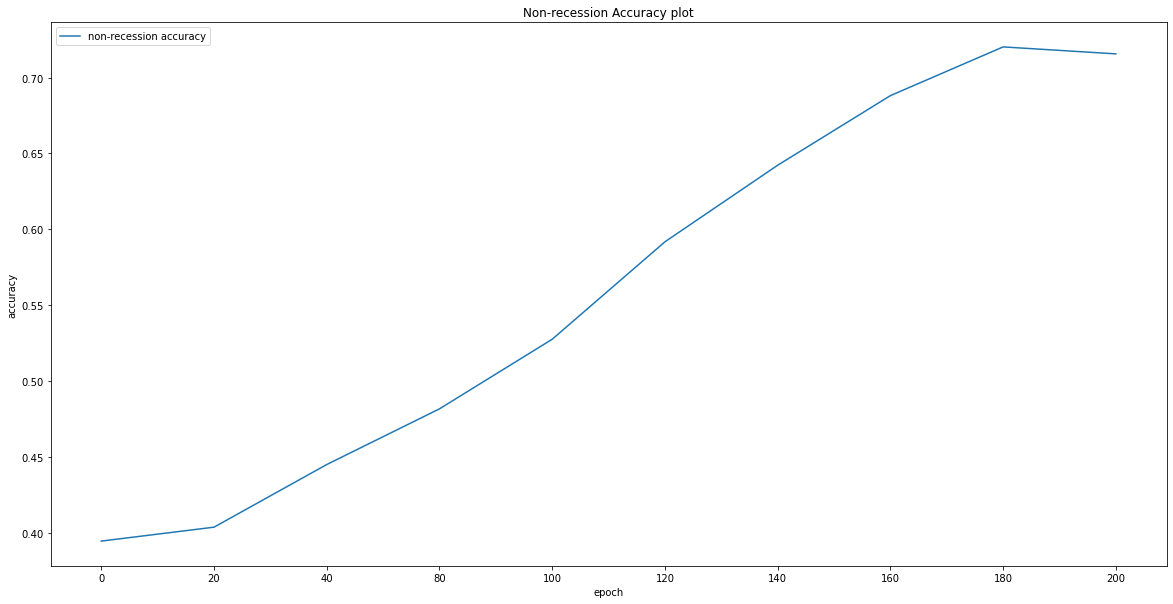

In [313]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

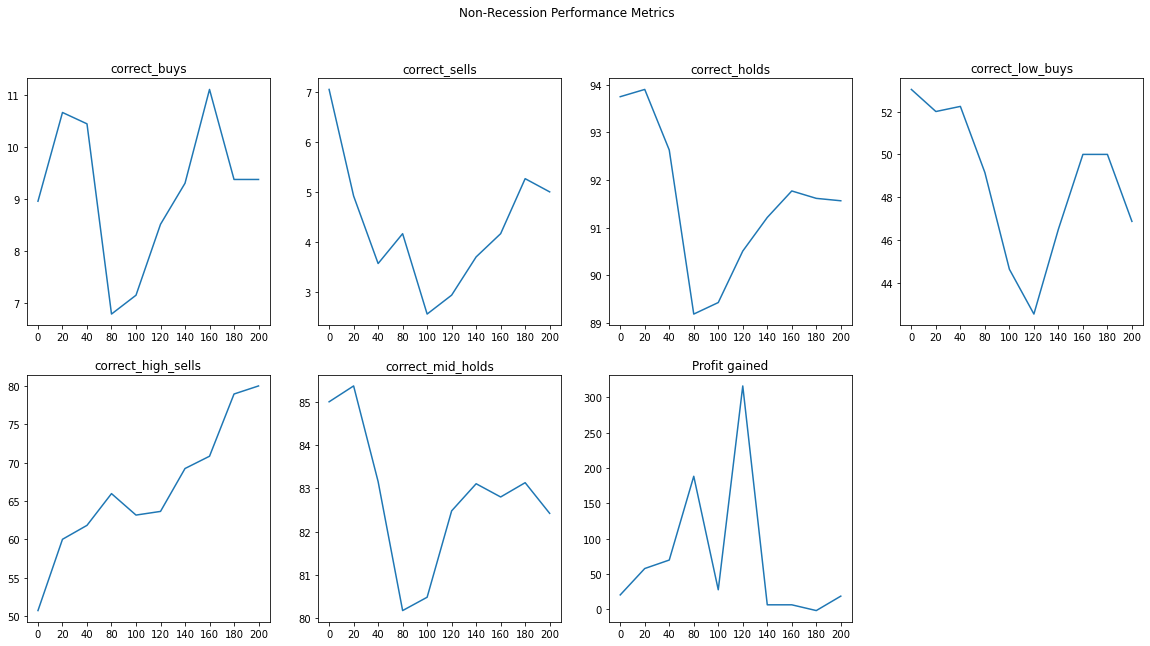

In [314]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

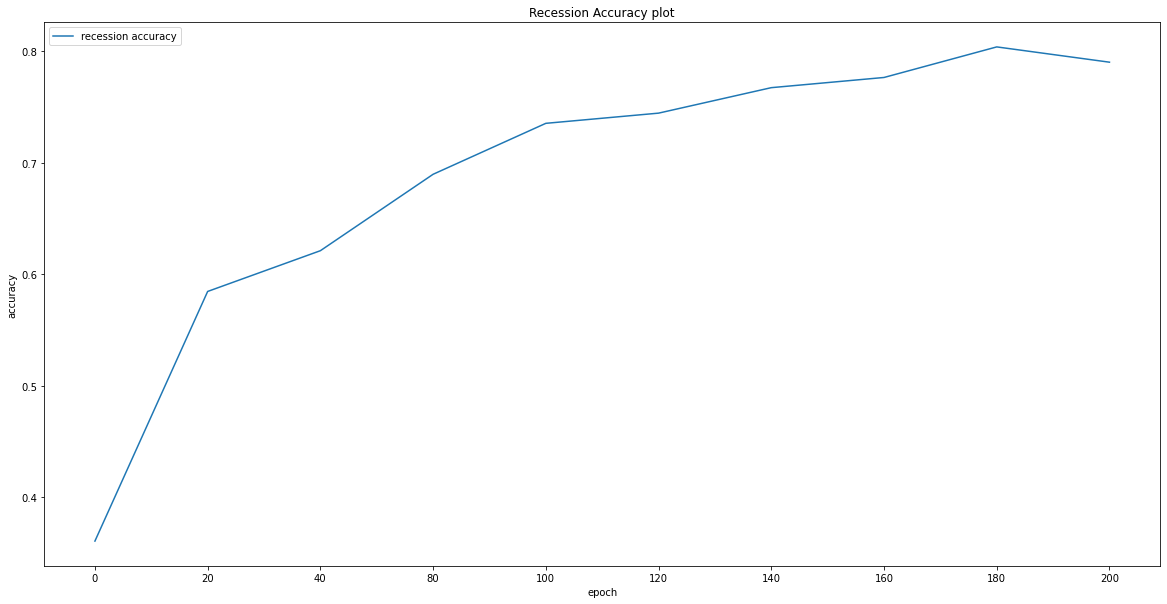

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

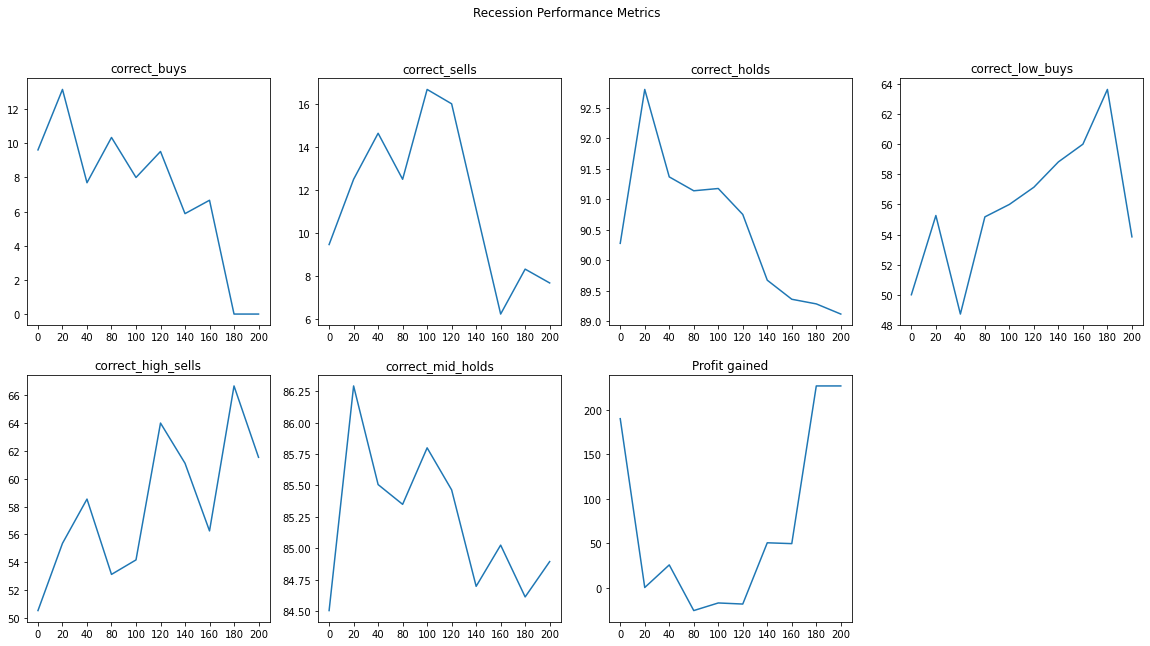

In [316]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [317]:
nr_test_sets = ['JBLU']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/DAL_data_test.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [318]:
r_test_sets = ['JBLU']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/DAL_data_test2.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


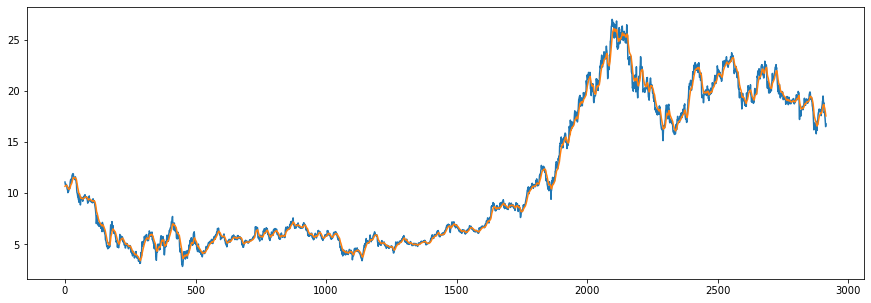

(2902, 15, 5)

In [319]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/DAL_data.csv")
df2.set_index('Date', inplace=True)
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)

X.shape

In [320]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [321]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [322]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [323]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [324]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JBLU')]
    y = nr_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JBLU')]
    y = r_test_data['{}_y'.format('JBLU')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('JBLU'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'JBLU')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'JBLU'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'JBLU'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.29874213836478, 1: 7.439102564102564, 2: 0.36649297331438496}



RUNNING EPOCHS 0 - 20



Epoch 1/20
19/19 [==============================] - 1s 46ms/step - loss: 0.3297 - accuracy: 0.5704 - mse: 0.3830 - weighted_accuracy: 0.2940 - weighted_mse: 0.4863 - val_loss: 0.3019 - val_accuracy: 0.0448 - val_mse: 0.3454 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3454
Epoch 2/20
19/19 [==============================] - 0s 8ms/step - loss: 0.2465 - accuracy: 0.4808 - mse: 0.5619 - weighted_accuracy: 0.3572 - weighted_mse: 0.6009 - val_loss: 0.2990 - val_accuracy: 0.0448 - val_mse: 0.3585 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3585
Epoch 3/20
19/19 [==============================] - 0s 8ms/step - loss: 0.2144 - accuracy: 0.3654 - mse: 0.7606 - weighted_accuracy: 0.4297 - weighted_mse: 0.7520 - val_loss: 0.2930 - val_accuracy: 0.0448 - val_mse: 0.3742 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.3742
Epoch 4/20
19/19 [==============================] - 0s 8m

7/7 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.1918 - mse: 0.9663 - weighted_accuracy: 0.1918 - weighted_mse: 0.9663
Test loss: 0.20694515109062195
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 7
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 117
actual holds but predicted sell: 46
actual predicted holds: 34
Percentage buys correct: 4.615384615384615%
Percentage sells correct: 4.081632653061225%
Percentage holds correct: 85.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.92307692307692%
Percentage high sells correct: 44.89795918367347%
Percentage mid holds correct: 79.48717948717949%


Capital: 100
Share price: $0.990272175418472
Shares owned at the moment: 100
Cash capital at the moment: $0.7004576099127036


Price increase fro

19/19 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.5058 - mse: 1.4478 - weighted_accuracy: 0.7797 - weighted_mse: 1.3784 - val_loss: 0.1904 - val_accuracy: 0.3649 - val_mse: 1.2752 - val_weighted_accuracy: 0.3649 - val_weighted_mse: 1.2752
Epoch 13/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.5222 - mse: 1.4616 - weighted_accuracy: 0.7827 - weighted_mse: 1.3992 - val_loss: 0.1833 - val_accuracy: 0.4269 - val_mse: 1.2826 - val_weighted_accuracy: 0.4269 - val_weighted_mse: 1.2826
Epoch 14/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1270 - accuracy: 0.5149 - mse: 1.5007 - weighted_accuracy: 0.7831 - weighted_mse: 1.4287 - val_loss: 0.1929 - val_accuracy: 0.3614 - val_mse: 1.3385 - val_weighted_accuracy: 0.3614 - val_weighted_mse: 1.3385
Epoch 15/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1258 - accuracy: 0.5127 - mse: 1.5117 - weighted_accuracy: 0.7822 - weighted_mse: 1.4382




RUNNING EPOCHS 40 - 60



Epoch 1/20
19/19 [==============================] - 0s 9ms/step - loss: 0.1169 - accuracy: 0.5950 - mse: 1.5677 - weighted_accuracy: 0.8245 - weighted_mse: 1.5343 - val_loss: 0.1694 - val_accuracy: 0.5439 - val_mse: 1.5172 - val_weighted_accuracy: 0.5439 - val_weighted_mse: 1.5172
Epoch 2/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1161 - accuracy: 0.5842 - mse: 1.5959 - weighted_accuracy: 0.8175 - weighted_mse: 1.5567 - val_loss: 0.1663 - val_accuracy: 0.5439 - val_mse: 1.5833 - val_weighted_accuracy: 0.5439 - val_weighted_mse: 1.5833
Epoch 3/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1163 - accuracy: 0.5872 - mse: 1.6044 - weighted_accuracy: 0.8216 - weighted_mse: 1.5628 - val_loss: 0.1652 - val_accuracy: 0.5628 - val_mse: 1.5424 - val_weighted_accuracy: 0.5628 - val_weighted_mse: 1.5424
Epoch 4/20
19/19 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.5549 - mse: 1.6403 - weighted_ac

0          19.481992  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.6438 - mse: 1.9464 - weighted_accuracy: 0.6438 - weighted_mse: 1.9464
Test loss: 0.15393254160881042
Test accuracy: 0.6438356041908264


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 28
actual holds but predicted sell: 35
actual predicted holds: 134
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 91.78082191780823%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 68.57142857142857%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.58620689655173%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the mome

19/19 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.7454 - mse: 2.2671 - weighted_accuracy: 0.8977 - weighted_mse: 2.3046 - val_loss: 0.1598 - val_accuracy: 0.6317 - val_mse: 2.3506 - val_weighted_accuracy: 0.6317 - val_weighted_mse: 2.3506
Epoch 16/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0797 - accuracy: 0.7484 - mse: 2.3129 - weighted_accuracy: 0.9018 - weighted_mse: 2.3395 - val_loss: 0.1526 - val_accuracy: 0.6730 - val_mse: 2.4274 - val_weighted_accuracy: 0.6730 - val_weighted_mse: 2.4274
Epoch 17/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.7385 - mse: 2.3496 - weighted_accuracy: 0.8950 - weighted_mse: 2.3918 - val_loss: 0.1633 - val_accuracy: 0.6489 - val_mse: 2.4065 - val_weighted_accuracy: 0.6489 - val_weighted_mse: 2.4065
Epoch 18/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0801 - accuracy: 0.7402 - mse: 2.3249 - weighted_accuracy: 0.8928 - weighted_mse: 2.3668

Epoch 1/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0736 - accuracy: 0.7863 - mse: 2.4260 - weighted_accuracy: 0.9156 - weighted_mse: 2.4845 - val_loss: 0.1478 - val_accuracy: 0.6781 - val_mse: 2.5543 - val_weighted_accuracy: 0.6781 - val_weighted_mse: 2.5543
Epoch 2/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0740 - accuracy: 0.7768 - mse: 2.4744 - weighted_accuracy: 0.9121 - weighted_mse: 2.5071 - val_loss: 0.1602 - val_accuracy: 0.6282 - val_mse: 2.6475 - val_weighted_accuracy: 0.6282 - val_weighted_mse: 2.6475
Epoch 3/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0758 - accuracy: 0.7717 - mse: 2.4734 - weighted_accuracy: 0.9133 - weighted_mse: 2.5067 - val_loss: 0.1584 - val_accuracy: 0.6420 - val_mse: 2.6371 - val_weighted_accuracy: 0.6420 - val_weighted_mse: 2.6371
Epoch 4/20
19/19 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.7613 - mse: 2.5079 - weighted_accuracy: 0.9095 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1525 - accuracy: 0.7626 - mse: 3.2747 - weighted_accuracy: 0.7626 - weighted_mse: 3.2747
Test loss: 0.15251977741718292
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 19
actual predicted holds: 163
Percentage buys correct: 15.789473684210526%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 91.06145251396649%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 85.95505617977528%


Capital: 100
Share price: $0.6025170038678631
Shares owned at the moment: 165
Cash capital at the moment: $0.3113022712975493


Pr

19/19 [==============================] - 0s 8ms/step - loss: 0.0448 - accuracy: 0.8729 - mse: 4.1240 - weighted_accuracy: 0.9534 - weighted_mse: 3.9430 - val_loss: 0.1495 - val_accuracy: 0.7659 - val_mse: 4.5345 - val_weighted_accuracy: 0.7659 - val_weighted_mse: 4.5345
Validation loss: 0.14950904250144958
Validation accuracy: 0.7659208178520203


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.7752 - mse: 4.7059 - weighted_accuracy: 0.7752 - weighted_mse: 4.7059
Test loss: 0.15802636742591858
Test accuracy: 0.7752293348312378


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 9
actual predicted holds: 167
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 0.0%
Percentage holds correc

19/19 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.8871 - mse: 4.5738 - weighted_accuracy: 0.9526 - weighted_mse: 4.2928 - val_loss: 0.1690 - val_accuracy: 0.7332 - val_mse: 4.9410 - val_weighted_accuracy: 0.7332 - val_weighted_mse: 4.9410
Epoch 11/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.8798 - mse: 4.6637 - weighted_accuracy: 0.9559 - weighted_mse: 4.3432 - val_loss: 0.1593 - val_accuracy: 0.7676 - val_mse: 5.0378 - val_weighted_accuracy: 0.7676 - val_weighted_mse: 5.0378
Epoch 12/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.8919 - mse: 4.7842 - weighted_accuracy: 0.9573 - weighted_mse: 4.4881 - val_loss: 0.1629 - val_accuracy: 0.7642 - val_mse: 5.2224 - val_weighted_accuracy: 0.7642 - val_weighted_mse: 5.2224
Epoch 13/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.8914 - mse: 4.8320 - weighted_accuracy: 0.9602 - weighted_mse: 4.4917

Epoch 1/20
19/19 [==============================] - 0s 9ms/step - loss: 0.0340 - accuracy: 0.9147 - mse: 5.4354 - weighted_accuracy: 0.9687 - weighted_mse: 4.9612 - val_loss: 0.1702 - val_accuracy: 0.7676 - val_mse: 5.7414 - val_weighted_accuracy: 0.7676 - val_weighted_mse: 5.7414
Epoch 2/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9156 - mse: 5.5433 - weighted_accuracy: 0.9691 - weighted_mse: 5.0007 - val_loss: 0.1737 - val_accuracy: 0.7608 - val_mse: 5.8715 - val_weighted_accuracy: 0.7608 - val_weighted_mse: 5.8715
Epoch 3/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9104 - mse: 5.5580 - weighted_accuracy: 0.9672 - weighted_mse: 5.0284 - val_loss: 0.1915 - val_accuracy: 0.7367 - val_mse: 5.6905 - val_weighted_accuracy: 0.7367 - val_weighted_mse: 5.6905
Epoch 4/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9052 - mse: 5.5320 - weighted_accuracy: 0.9653 - weighted_mse

0          19.481992  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2167 - accuracy: 0.8265 - mse: 7.4973 - weighted_accuracy: 0.8265 - weighted_mse: 7.4973
Test loss: 0.21666014194488525
Test accuracy: 0.8264840245246887


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 12
actual holds but predicted sell: 5
actual predicted holds: 180
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 0.0%
Percentage holds correct: 90.45226130653266%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.35353535353535%


Capital: 100
Share price: $0.30387757604393356
Shares owned at the moment: 328
Cash capital at the moment: $0.05405748399816446


P

0          19.481992  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.8128 - mse: 9.2596 - weighted_accuracy: 0.8128 - weighted_mse: 9.2596
Test loss: 0.24032743275165558
Test accuracy: 0.8127853870391846


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 14
actual holds but predicted sell: 6
actual predicted holds: 177
Percentage buys correct: 6.25%
Percentage sells correct: 0.0%
Percentage holds correct: 90.3061224489796%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 85.12820512820512%


Capital: 100
Share price: $0.6025170038678631
Shares owned at the moment: 165
Cash capital at the moment: $0.3113022712975493


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.2447 - accuracy: 0.7936 - mse: 12.0606 - weighted_accuracy: 0.7936 - weighted_mse: 12.0606
Test loss: 0.244735985994339
Test accuracy: 0.7935779690742493


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 10
actual predicted holds: 172
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 0.0%
Percentage holds correct: 91.005291005291%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 82.44680851063829%


Capital: 100
Share price: $0.3180685041257474
Shares owned at the moment: 313
Cash capital at the moment: $0.170780743714829


Price increase from previously boug

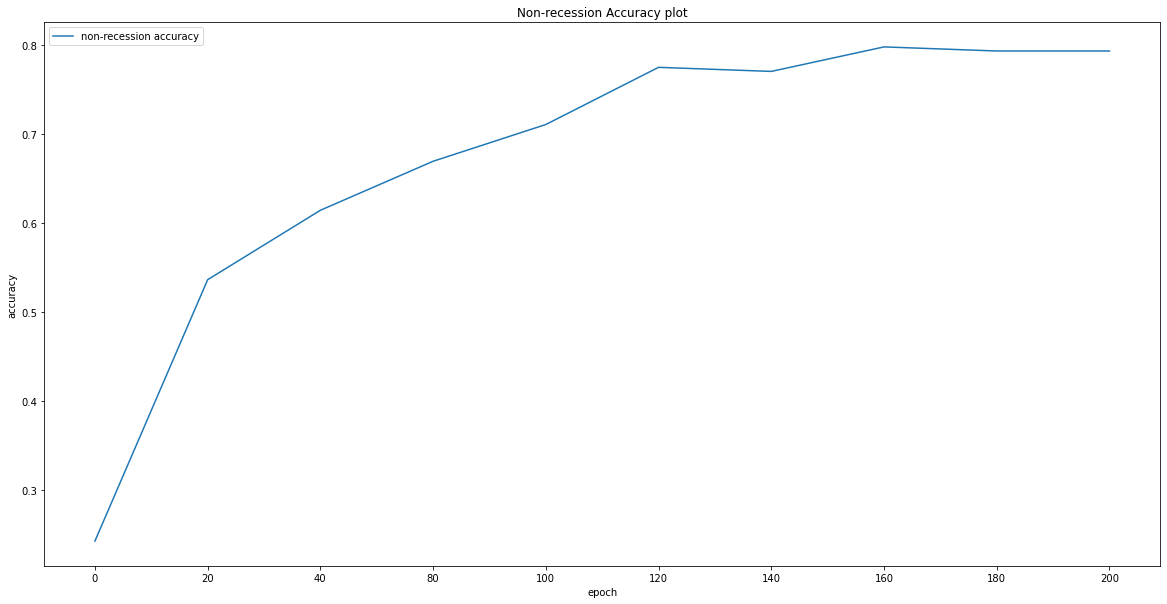

In [325]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

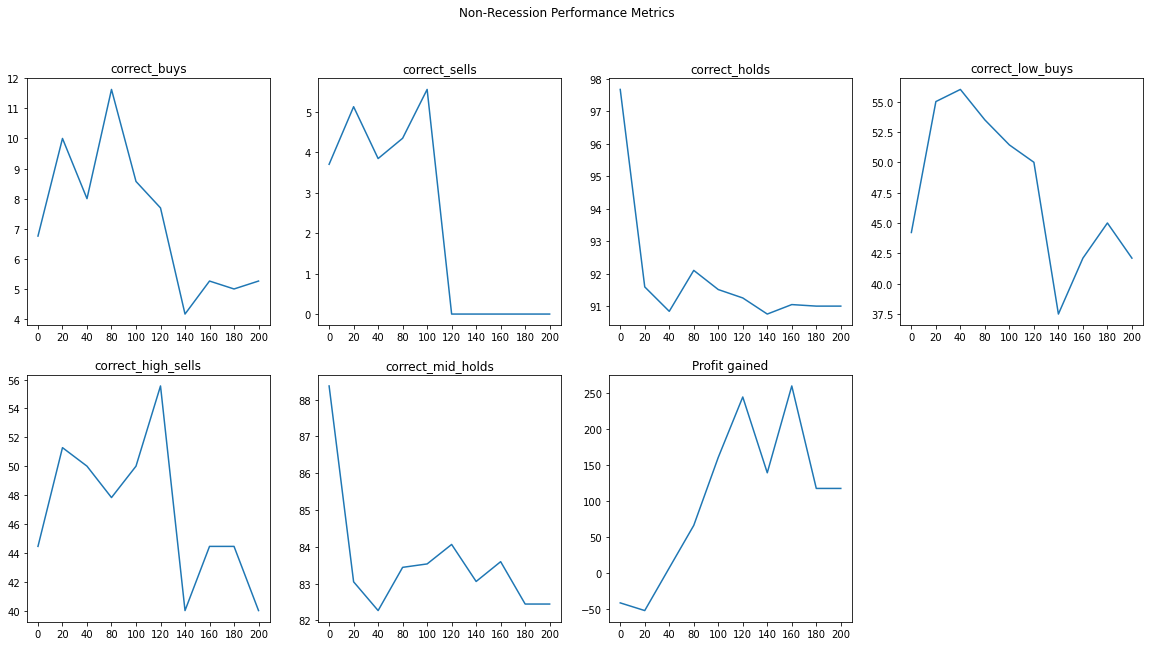

In [326]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

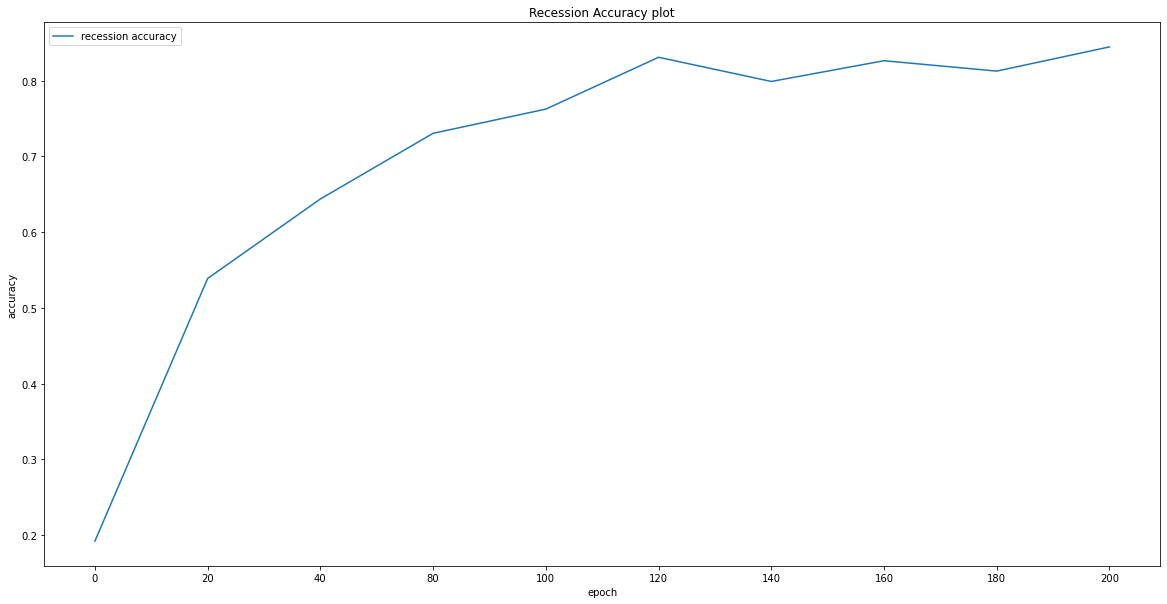

In [327]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

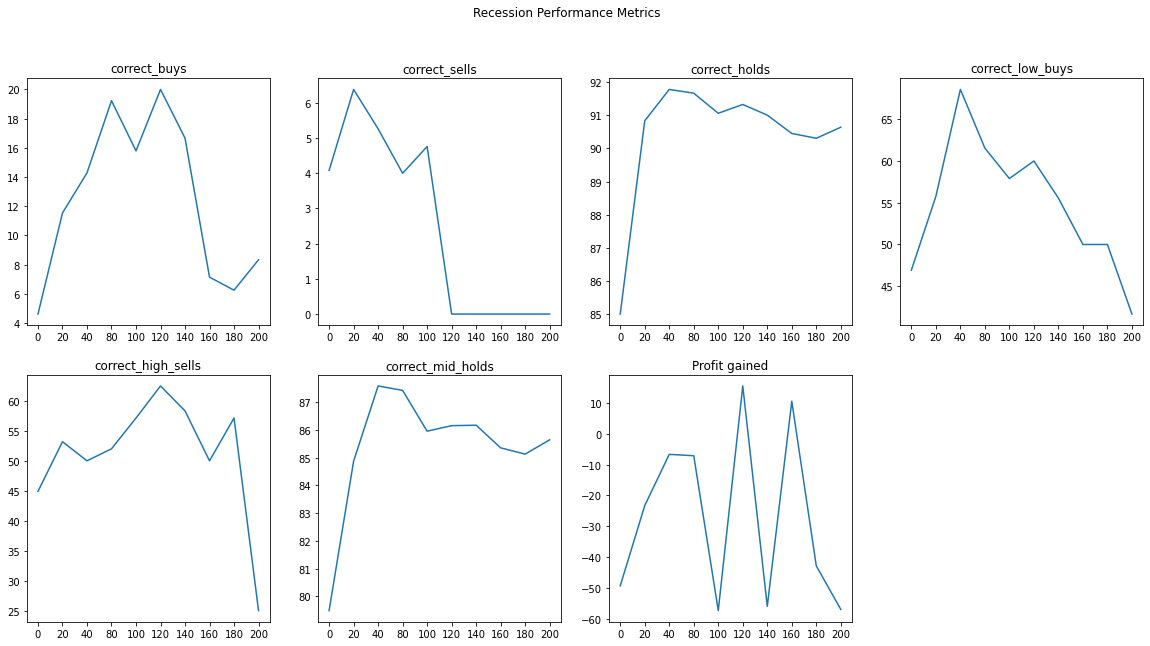

In [328]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## The Kroger Co

### No support Stock Data

In [61]:
nr_test_sets = ['KR']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0


In [62]:
r_test_sets = ['KR']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2000-01-21      8.68750  9.252111 -93.750000  -7835000.0     2.0
2000-01-24      8.40625  9.121979 -96.428571 -15986000.0     2.0
2000-01-25      8.15625  8.973405 -93.939394 -27586200.0     1.0
2000-01-26      8.06250  8.833266 -92.857143 -35302800.0     2.0
2000-01-27      8.25000  8.743533 -83.076923 -22065800.0     2.0


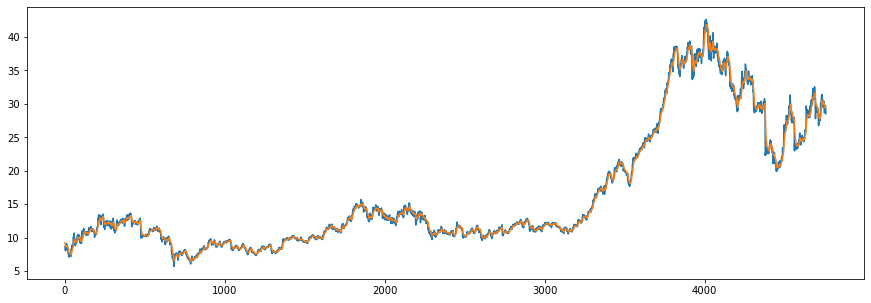

(4745, 15, 4)

In [63]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/KR_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('KR')]
    y = nr_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'KR')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('KR')]
    y = r_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'KR')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2969 - accuracy: 0.4795 - mse: 0.4523 - weighted_accuracy: 0.3046 - weighted_mse: 0.5232 - val_loss: 0.2996 - val_accuracy: 0.0464 - val_mse: 0.3554 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3554
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2095 - accuracy: 0.3396 - mse: 0.7919 - weighted_accuracy: 0.4614 - weighted_mse: 0.7708 - val_loss: 0.2896 - val_accuracy: 0.0453 - val_mse: 0.3874 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3874
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1899 - accuracy: 0.3127 - mse: 1.0306 - weighted_accuracy: 0.4847 - weighted_mse: 1.0053 - val_loss: 0.2794 - val_accuracy: 0.0453 - val_mse: 0.4303 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4303
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.2740 - mse: 1.2917 - weighted_accuracy: 0.2740 - weighted_mse: 1.2917
Test loss: 0.1964324563741684
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 81
actual predicted holds: 47
Percentage buys correct: 6.8493150684931505%
Percentage sells correct: 8.791208791208792%
Percentage holds correct: 85.45454545454545%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 43.956043956043956%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.21092380889243256
Shares owned at the moment: 472
Cash capital at the moment: $0.1701830988294546


Price increase from previousl

30/30 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.4428 - mse: 1.6611 - weighted_accuracy: 0.7350 - weighted_mse: 1.5808 - val_loss: 0.2052 - val_accuracy: 0.2771 - val_mse: 1.7036 - val_weighted_accuracy: 0.2771 - val_weighted_mse: 1.7036
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1317 - accuracy: 0.4218 - mse: 1.6835 - weighted_accuracy: 0.7365 - weighted_mse: 1.5814 - val_loss: 0.1945 - val_accuracy: 0.3456 - val_mse: 1.8186 - val_weighted_accuracy: 0.3456 - val_weighted_mse: 1.8186
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1301 - accuracy: 0.4521 - mse: 1.7072 - weighted_accuracy: 0.7439 - weighted_mse: 1.6211 - val_loss: 0.1853 - val_accuracy: 0.3878 - val_mse: 1.7499 - val_weighted_accuracy: 0.3878 - val_weighted_mse: 1.7499
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1300 - accuracy: 0.4539 - mse: 1.7107 - weighted_accuracy: 0.7391 - weighted_mse: 1.6345


Percentage low buys correct: 51.31578947368421%
Percentage high sells correct: 42.30769230769231%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increase from previously bought: 435.98341707717736%
Share price: $0.17166281195674515
Shares owned at the moment: 0
Cash capital at the moment: $534.4672116928581


Share price: $0.14625872815936725
Shares owned at the moment: 3644
Cash capital at the moment: $0.03474756523871747


Price increase from previously bought: 398.124735303747%
Share price: $0.7305544174843568
Shares owned at the moment: 0
Cash capital at the moment: $2654.854159060624


Share price: $0.26519625983380624
Shares owned at the moment: 9983
Cash capital at the moment: $0.11939791945405887


Price increase from previously bought: 107.41543271326917%
Share price: $0.5515706292908475
Shares owned at the moment: 0
Cash capital at the moment: $54

30/30 [==============================] - 0s 7ms/step - loss: 0.1199 - accuracy: 0.5213 - mse: 1.9220 - weighted_accuracy: 0.7877 - weighted_mse: 1.8460 - val_loss: 0.2453 - val_accuracy: 0.2761 - val_mse: 2.0678 - val_weighted_accuracy: 0.2761 - val_weighted_mse: 2.0678
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1173 - accuracy: 0.5340 - mse: 1.9476 - weighted_accuracy: 0.7979 - weighted_mse: 1.8800 - val_loss: 0.1864 - val_accuracy: 0.4320 - val_mse: 2.0372 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 2.0372
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1167 - accuracy: 0.5316 - mse: 1.9546 - weighted_accuracy: 0.8007 - weighted_mse: 1.8742 - val_loss: 0.1865 - val_accuracy: 0.4394 - val_mse: 1.9780 - val_weighted_accuracy: 0.4394 - val_weighted_mse: 1.9780
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1159 - accuracy: 0.5324 - mse: 1.9898 - weighted_accuracy: 0.7973 - weighted_mse: 1.9229

7/7 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.4658 - mse: 2.0667 - weighted_accuracy: 0.4658 - weighted_mse: 2.0667
Test loss: 0.1933256983757019
Test accuracy: 0.465753436088562


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 50
actual holds but predicted sell: 52
actual predicted holds: 91
Percentage buys correct: 7.2727272727272725%
Percentage sells correct: 11.475409836065573%
Percentage holds correct: 88.3495145631068%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 49.09090909090909%
Percentage high sells correct: 49.18032786885246%
Percentage mid holds correct: 81.37254901960785%


Capital: 100
Share price: $0.21092380889243256
Shares owned at the moment: 472
Cash capital at the moment: $0.1701830988294546


Price 

30/30 [==============================] - 0s 7ms/step - loss: 0.1006 - accuracy: 0.6312 - mse: 2.3392 - weighted_accuracy: 0.8354 - weighted_mse: 2.3169 - val_loss: 0.1642 - val_accuracy: 0.5785 - val_mse: 2.5619 - val_weighted_accuracy: 0.5785 - val_weighted_mse: 2.5619
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.6293 - mse: 2.3724 - weighted_accuracy: 0.8420 - weighted_mse: 2.3297 - val_loss: 0.2425 - val_accuracy: 0.3530 - val_mse: 2.4350 - val_weighted_accuracy: 0.3530 - val_weighted_mse: 2.4350
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.6436 - mse: 2.3856 - weighted_accuracy: 0.8454 - weighted_mse: 2.3602 - val_loss: 0.1804 - val_accuracy: 0.5058 - val_mse: 2.4211 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 2.4211
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0991 - accuracy: 0.6409 - mse: 2.3819 - weighted_accuracy: 0.8500 - weighted_mse: 2.3354 

7/7 [==============================] - 0s 3ms/step - loss: 0.1824 - accuracy: 0.5388 - mse: 2.5660 - weighted_accuracy: 0.5388 - weighted_mse: 2.5660
Test loss: 0.18239499628543854
Test accuracy: 0.5388127565383911


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 6
actual holds but predicted buy: 40
actual holds but predicted sell: 45
actual predicted holds: 108
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 12.962962962962964%
Percentage holds correct: 88.52459016393442%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.99173553719008%


Capital: 100
Share price: $0.21092380889243256
Shares owned at the moment: 472
Cash capital at the moment: $0.1701830988294546


Price increase f

30/30 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.7323 - mse: 2.9197 - weighted_accuracy: 0.8927 - weighted_mse: 2.9374 - val_loss: 0.1794 - val_accuracy: 0.5416 - val_mse: 2.9676 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 2.9676
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.7189 - mse: 2.8997 - weighted_accuracy: 0.8841 - weighted_mse: 2.8850 - val_loss: 0.1502 - val_accuracy: 0.6776 - val_mse: 3.0282 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 3.0282
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0825 - accuracy: 0.7131 - mse: 2.9758 - weighted_accuracy: 0.8838 - weighted_mse: 2.9682 - val_loss: 0.1531 - val_accuracy: 0.6502 - val_mse: 3.1788 - val_weighted_accuracy: 0.6502 - val_weighted_mse: 3.1788
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0815 - accuracy: 0.7292 - mse: 3.0235 - weighted_accuracy: 0.8934 - weighted_mse: 3.0304

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0750 - accuracy: 0.7505 - mse: 3.2813 - weighted_accuracy: 0.9049 - weighted_mse: 3.3020 - val_loss: 0.1975 - val_accuracy: 0.5437 - val_mse: 3.3713 - val_weighted_accuracy: 0.5437 - val_weighted_mse: 3.3713
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.7534 - mse: 3.3423 - weighted_accuracy: 0.8967 - weighted_mse: 3.3543 - val_loss: 0.1725 - val_accuracy: 0.6449 - val_mse: 3.6493 - val_weighted_accuracy: 0.6449 - val_weighted_mse: 3.6493
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0746 - accuracy: 0.7482 - mse: 3.3380 - weighted_accuracy: 0.9003 - weighted_mse: 3.3445 - val_loss: 0.1681 - val_accuracy: 0.6301 - val_mse: 3.5416 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 3.5416
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0737 - accuracy: 0.7785 - mse: 3.3905 - weighted_accuracy: 0.9077 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.6712 - mse: 3.9737 - weighted_accuracy: 0.6712 - weighted_mse: 3.9737
Test loss: 0.18370908498764038
Test accuracy: 0.6712328791618347


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 32
actual predicted holds: 140
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 12.820512820512821%
Percentage holds correct: 89.171974522293%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 48.717948717948715%
Percentage mid holds correct: 81.41025641025641%


Capital: 100
Share price: $0.3298613405668711
Shares owned at the moment: 302
Cash capital at the moment: $0.10792530546413559


Pric

30/30 [==============================] - 0s 7ms/step - loss: 0.0538 - accuracy: 0.8343 - mse: 4.7771 - weighted_accuracy: 0.9356 - weighted_mse: 4.6812 - val_loss: 0.1749 - val_accuracy: 0.6944 - val_mse: 5.2828 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 5.2828
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0537 - accuracy: 0.8409 - mse: 4.8628 - weighted_accuracy: 0.9362 - weighted_mse: 4.7985 - val_loss: 0.1673 - val_accuracy: 0.7113 - val_mse: 5.1715 - val_weighted_accuracy: 0.7113 - val_weighted_mse: 5.1715
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8422 - mse: 4.8808 - weighted_accuracy: 0.9274 - weighted_mse: 4.7952 - val_loss: 0.2046 - val_accuracy: 0.6207 - val_mse: 5.1144 - val_weighted_accuracy: 0.6207 - val_weighted_mse: 5.1144
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0544 - accuracy: 0.8327 - mse: 4.8602 - weighted_accuracy: 0.9332 - weighted_mse: 4.8198

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0515 - accuracy: 0.8454 - mse: 5.0841 - weighted_accuracy: 0.9360 - weighted_mse: 4.9877 - val_loss: 0.1916 - val_accuracy: 0.6386 - val_mse: 5.2733 - val_weighted_accuracy: 0.6386 - val_weighted_mse: 5.2733
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.8488 - mse: 5.2100 - weighted_accuracy: 0.9372 - weighted_mse: 5.0982 - val_loss: 0.1879 - val_accuracy: 0.6891 - val_mse: 5.5258 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 5.5258
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0513 - accuracy: 0.8385 - mse: 5.1545 - weighted_accuracy: 0.9371 - weighted_mse: 5.0278 - val_loss: 0.1825 - val_accuracy: 0.6776 - val_mse: 5.5002 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 5.5002
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.8680 - mse: 5.3017 - weighted_accuracy: 0.9516 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.2078 - accuracy: 0.7352 - mse: 6.1570 - weighted_accuracy: 0.7352 - weighted_mse: 6.1570
Test loss: 0.2077554613351822
Test accuracy: 0.7351598143577576


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 25
actual predicted holds: 156
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 12.903225806451612%
Percentage holds correct: 89.14285714285714%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 81.60919540229885%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increas

Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0364 - accuracy: 0.9041 - mse: 7.3953 - weighted_accuracy: 0.9630 - weighted_mse: 6.8852 - val_loss: 0.2108 - val_accuracy: 0.7229 - val_mse: 7.5355 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 7.5355
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9067 - mse: 7.5969 - weighted_accuracy: 0.9640 - weighted_mse: 7.0863 - val_loss: 0.2132 - val_accuracy: 0.7007 - val_mse: 7.5211 - val_weighted_accuracy: 0.7007 - val_weighted_mse: 7.5211
Validation loss: 0.21323812007904053
Validation accuracy: 0.7007375955581665


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.7202 - mse: 7.6278 - weighted_accuracy: 0.7202 - weighted_mse: 7.6278
Test loss: 0.19814741611480713
Test accuracy: 0.7201834917068481


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold:

Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0344 - accuracy: 0.9115 - mse: 8.0435 - weighted_accuracy: 0.9657 - weighted_mse: 7.3070 - val_loss: 0.2118 - val_accuracy: 0.7408 - val_mse: 8.3805 - val_weighted_accuracy: 0.7408 - val_weighted_mse: 8.3805
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9191 - mse: 7.9839 - weighted_accuracy: 0.9704 - weighted_mse: 7.4174 - val_loss: 0.1972 - val_accuracy: 0.8019 - val_mse: 8.8476 - val_weighted_accuracy: 0.8019 - val_weighted_mse: 8.8476
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9247 - mse: 8.1429 - weighted_accuracy: 0.9705 - weighted_mse: 7.4857 - val_loss: 0.2071 - val_accuracy: 0.7545 - val_mse: 8.6525 - val_weighted_accuracy: 0.7545 - val_weighted_mse: 8.6525
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 0.9033 - mse: 8.1036 - weighted_accuracy: 0.9646 - weighted_mse

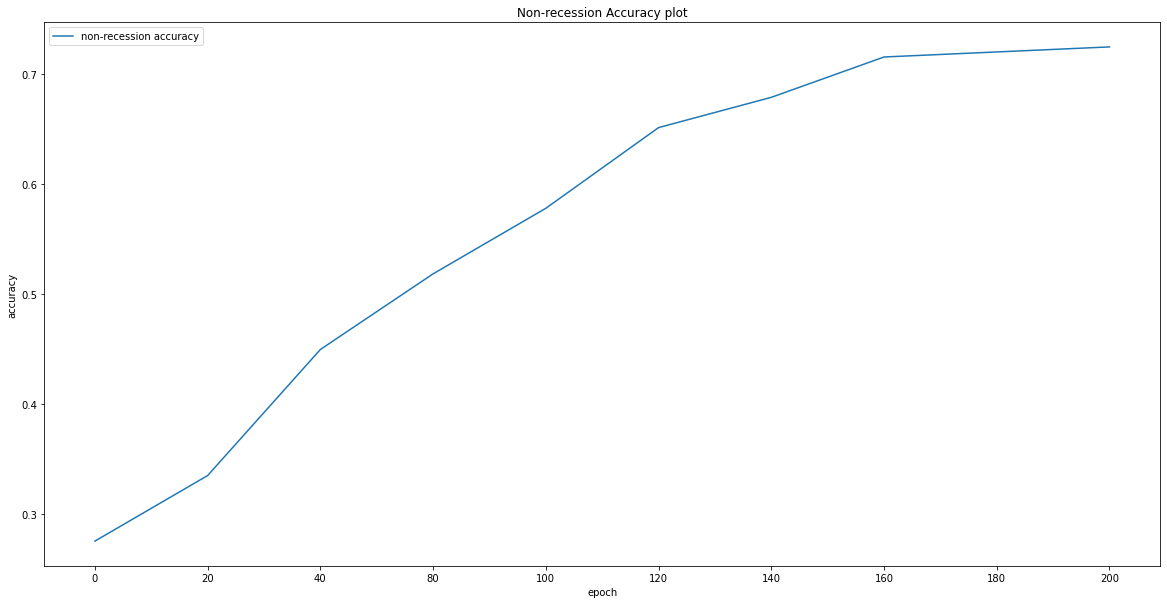

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

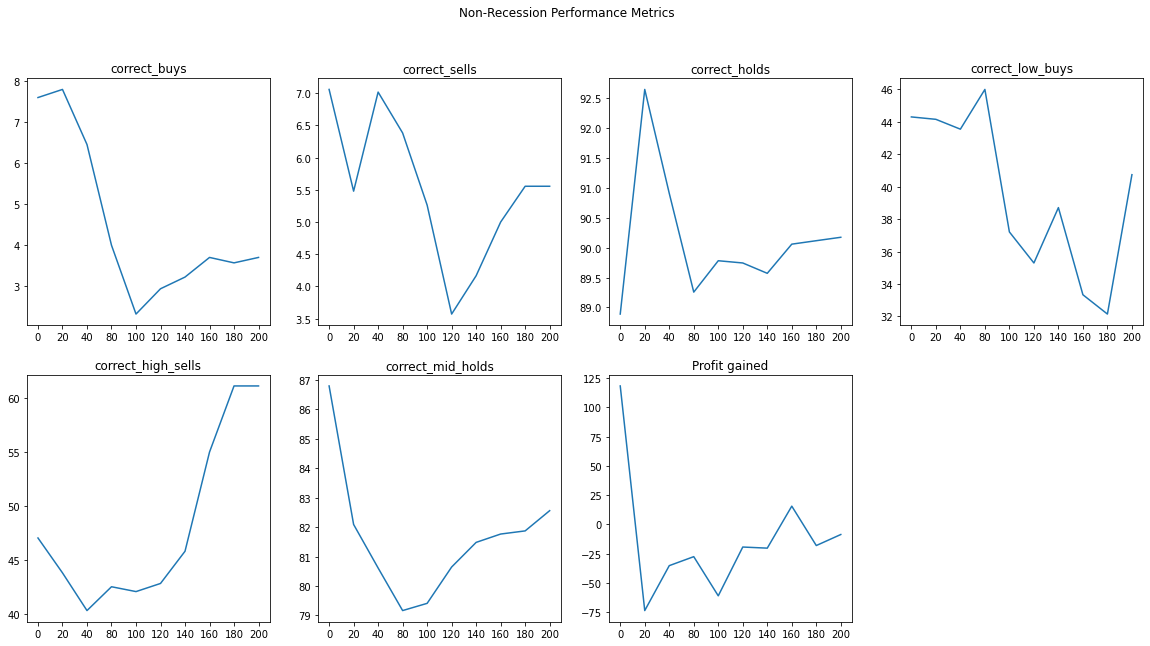

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

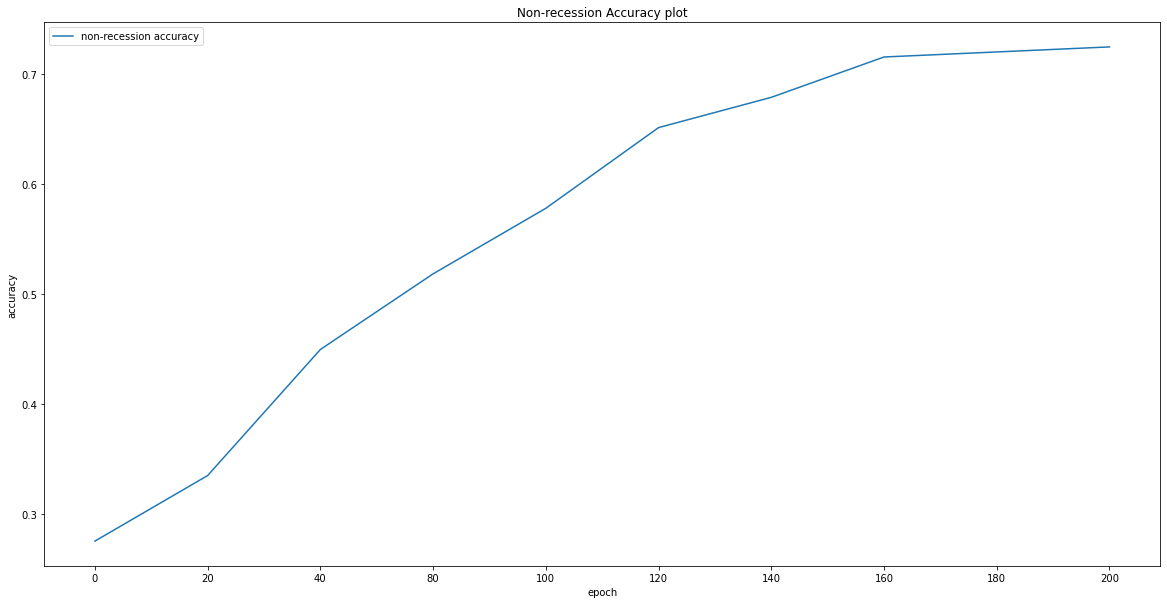

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

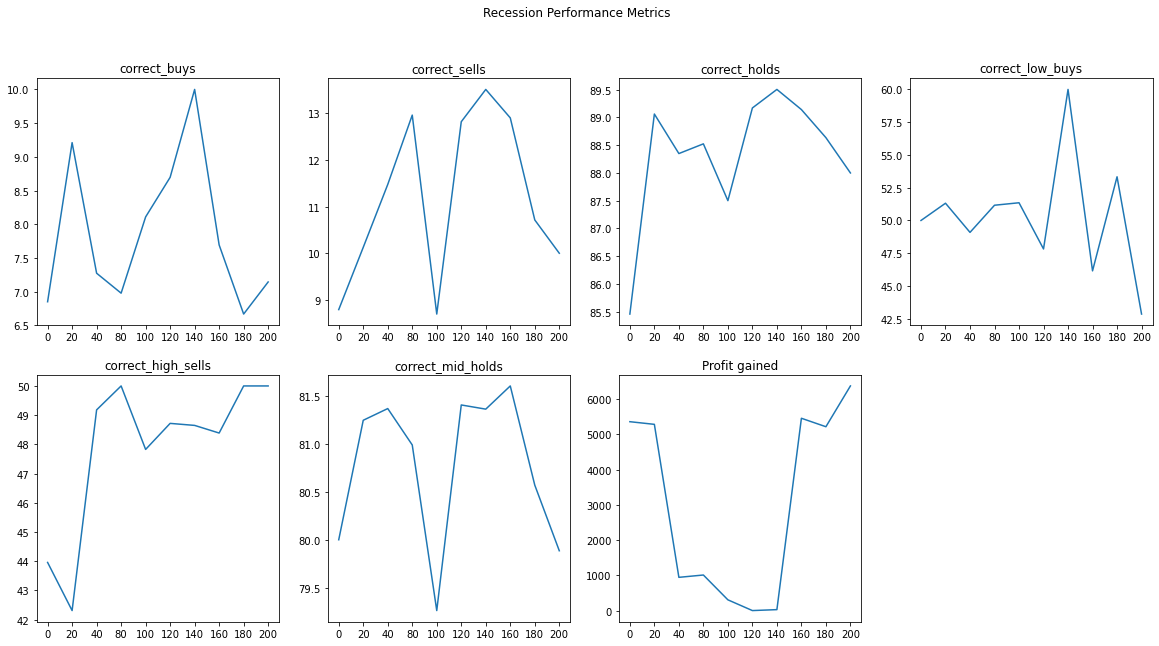

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [73]:
nr_test_sets = ['KR']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/WMT_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    29.430000  28.387007  -4.858258  41061300.0     2.0
2019-01-23    29.320000  28.530544  -9.311725  36484100.0     2.0
2019-01-24    29.240000  28.639691 -14.919380  31104500.0     2.0
2019-01-25    28.709999  28.650508 -38.135648  21525300.0     2.0
2019-01-28    28.120001  28.568891 -63.135567  13527400.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [74]:
r_test_sets = ['KR']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/WMT_data_test2.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels

    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.410000  28.475794 -65.217413  9500700.0     2.0
2020-01-23    28.370001  28.459518 -68.695589  4678900.0     2.0
2020-01-24    28.440001  28.456515 -52.222168  8638500.0     2.0
2020-01-27    28.190001  28.415513 -79.999958  3996300.0     2.0
2020-01-28    28.330000  28.402357 -50.434793  8238000.0     2.0


### training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2000-01-21      8.68750  9.252111 -93.750000  -7835000.0     2.0
2000-01-24      8.40625  9.121979 -96.428571 -15986000.0     2.0
2000-01-25      8.15625  8.973405 -93.939394 -27586200.0     1.0
2000-01-26      8.06250  8.833266 -92.857143 -35302800.0     2.0
2000-01-27      8.25000  8.743533 -83.076923 -22065800.0     2.0


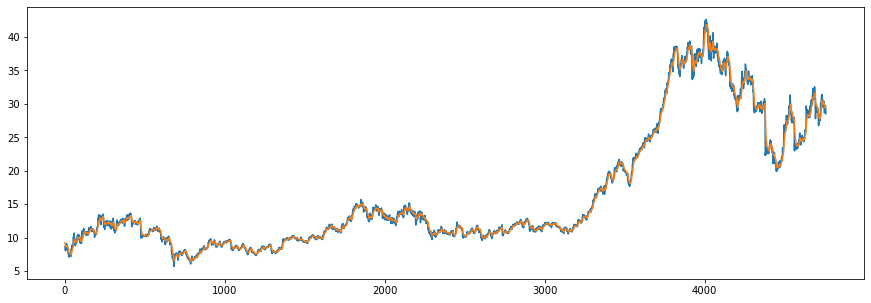

(4745, 15, 5)

In [75]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/KR_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)

X.shape

In [76]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [77]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [78]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [80]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('KR')]
    y = nr_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'KR')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('KR')]
    y = r_test_data['{}_y'.format('KR')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('KR'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'KR')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'KR'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'KR'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3565891472868215, 1: 7.3565891472868215, 2: 0.36655079181151023}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 44ms/step - loss: 0.3044 - accuracy: 0.5282 - mse: 0.4331 - weighted_accuracy: 0.3041 - weighted_mse: 0.5223 - val_loss: 0.3017 - val_accuracy: 0.0443 - val_mse: 0.3545 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3545
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2157 - accuracy: 0.3541 - mse: 0.7516 - weighted_accuracy: 0.4078 - weighted_mse: 0.7444 - val_loss: 0.2924 - val_accuracy: 0.0453 - val_mse: 0.3844 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3844
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.2792 - mse: 0.9990 - weighted_accuracy: 0.4762 - weighted_mse: 0.9705 - val_loss: 0.2810 - val_accuracy: 0.0453 - val_mse: 0.4215 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4215
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 3ms/step - loss: 0.1844 - accuracy: 0.4155 - mse: 1.1593 - weighted_accuracy: 0.4155 - weighted_mse: 1.1593
Test loss: 0.18436871469020844
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 5
actual holds but predicted buy: 48
actual holds but predicted sell: 65
actual predicted holds: 80
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 86.95652173913044%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 50.98039215686274%
Percentage high sells correct: 48.0%
Percentage mid holds correct: 79.34782608695652%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increase

Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1292 - accuracy: 0.4423 - mse: 1.6103 - weighted_accuracy: 0.7440 - weighted_mse: 1.5198 - val_loss: 0.1908 - val_accuracy: 0.3741 - val_mse: 1.6881 - val_weighted_accuracy: 0.3741 - val_weighted_mse: 1.6881
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.4673 - mse: 1.6212 - weighted_accuracy: 0.7569 - weighted_mse: 1.5406 - val_loss: 0.1841 - val_accuracy: 0.4120 - val_mse: 1.6488 - val_weighted_accuracy: 0.4120 - val_weighted_mse: 1.6488
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.4723 - mse: 1.6415 - weighted_accuracy: 0.7716 - weighted_mse: 1.5688 - val_loss: 0.2031 - val_accuracy: 0.3267 - val_mse: 1.8235 - val_weighted_accuracy: 0.3267 - val_weighted_mse: 1.8235
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1241 - accuracy: 0.5011 - mse: 1.6597 - weighted_accuracy: 0.7748 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1735 - accuracy: 0.5708 - mse: 1.7474 - weighted_accuracy: 0.5708 - weighted_mse: 1.7474
Test loss: 0.17348232865333557
Test accuracy: 0.5707762837409973


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 5
actual holds but predicted buy: 44
actual holds but predicted sell: 36
actual predicted holds: 113
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 17.391304347826086%
Percentage holds correct: 90.4%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 52.083333333333336%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increa

Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0981 - accuracy: 0.6607 - mse: 2.1119 - weighted_accuracy: 0.8627 - weighted_mse: 2.1160 - val_loss: 0.1933 - val_accuracy: 0.4805 - val_mse: 2.1917 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 2.1917
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0974 - accuracy: 0.6365 - mse: 2.1585 - weighted_accuracy: 0.8539 - weighted_mse: 2.1448 - val_loss: 0.1703 - val_accuracy: 0.5722 - val_mse: 2.2810 - val_weighted_accuracy: 0.5722 - val_weighted_mse: 2.2810
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0954 - accuracy: 0.6805 - mse: 2.1948 - weighted_accuracy: 0.8626 - weighted_mse: 2.2088 - val_loss: 0.1739 - val_accuracy: 0.5532 - val_mse: 2.2878 - val_weighted_accuracy: 0.5532 - val_weighted_mse: 2.2878
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0958 - accuracy: 0.6683 - mse: 2.2007 - weighted_accuracy: 0.8655 - weighted




RUNNING EPOCHS 60 - 80



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0897 - accuracy: 0.6984 - mse: 2.3634 - weighted_accuracy: 0.8784 - weighted_mse: 2.3929 - val_loss: 0.1847 - val_accuracy: 0.5448 - val_mse: 2.5471 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 2.5471
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 0.7097 - mse: 2.3820 - weighted_accuracy: 0.8825 - weighted_mse: 2.4319 - val_loss: 0.1769 - val_accuracy: 0.5659 - val_mse: 2.4986 - val_weighted_accuracy: 0.5659 - val_weighted_mse: 2.4986
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0870 - accuracy: 0.7068 - mse: 2.3885 - weighted_accuracy: 0.8870 - weighted_mse: 2.4234 - val_loss: 0.1880 - val_accuracy: 0.5342 - val_mse: 2.4217 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 2.4217
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0875 - accuracy: 0.7281 - mse: 2.4224 - weighted_ac

7/7 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.7626 - mse: 3.4258 - weighted_accuracy: 0.7626 - weighted_mse: 3.4258
Test loss: 0.1495867222547531
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 10
actual holds but predicted buy: 20
actual holds but predicted sell: 11
actual predicted holds: 162
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 21.428571428571427%
Percentage holds correct: 88.52459016393442%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 59.09090909090909%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 79.67032967032966%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571



30/30 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.8514 - mse: 4.1840 - weighted_accuracy: 0.9400 - weighted_mse: 4.2095 - val_loss: 0.1782 - val_accuracy: 0.6860 - val_mse: 4.2812 - val_weighted_accuracy: 0.6860 - val_weighted_mse: 4.2812
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0518 - accuracy: 0.8440 - mse: 4.2332 - weighted_accuracy: 0.9428 - weighted_mse: 4.2816 - val_loss: 0.1797 - val_accuracy: 0.6839 - val_mse: 4.4751 - val_weighted_accuracy: 0.6839 - val_weighted_mse: 4.4751
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.8430 - mse: 4.3321 - weighted_accuracy: 0.9424 - weighted_mse: 4.3574 - val_loss: 0.1630 - val_accuracy: 0.7366 - val_mse: 4.7299 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 4.7299
Validation loss: 0.1630364954471588
Validation accuracy: 0.7365648150444031


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.144

30/30 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.8651 - mse: 4.8284 - weighted_accuracy: 0.9469 - weighted_mse: 4.8571 - val_loss: 0.1883 - val_accuracy: 0.7018 - val_mse: 5.5330 - val_weighted_accuracy: 0.7018 - val_weighted_mse: 5.5330
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.8786 - mse: 4.9209 - weighted_accuracy: 0.9536 - weighted_mse: 4.9378 - val_loss: 0.1824 - val_accuracy: 0.7123 - val_mse: 5.4665 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 5.4665
Epoch 9/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.8606 - mse: 4.9866 - weighted_accuracy: 0.9471 - weighted_mse: 4.9469 - val_loss: 0.2082 - val_accuracy: 0.6670 - val_mse: 5.1364 - val_weighted_accuracy: 0.6670 - val_weighted_mse: 5.1364
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.8828 - mse: 5.1267 - weighted_accuracy: 0.9570 - weighted_mse: 5.0706 -

0         411.359762  



RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.8973 - mse: 6.0607 - weighted_accuracy: 0.9587 - weighted_mse: 5.9136 - val_loss: 0.1882 - val_accuracy: 0.7429 - val_mse: 6.4141 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 6.4141
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9023 - mse: 6.1865 - weighted_accuracy: 0.9642 - weighted_mse: 5.9812 - val_loss: 0.1986 - val_accuracy: 0.7408 - val_mse: 6.2693 - val_weighted_accuracy: 0.7408 - val_weighted_mse: 6.2693
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.8994 - mse: 6.2146 - weighted_accuracy: 0.9631 - weighted_mse: 6.0030 - val_loss: 0.1905 - val_accuracy: 0.7629 - val_mse: 6.5466 - val_weighted_accuracy: 0.7629 - val_weighted_mse: 6.5466
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9065 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2207 - accuracy: 0.7991 - mse: 8.3919 - weighted_accuracy: 0.7991 - weighted_mse: 8.3919
Test loss: 0.2207469791173935
Test accuracy: 0.7990867495536804


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 15
actual holds but predicted sell: 5
actual predicted holds: 173
Percentage buys correct: 6.25%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 87.81725888324873%
actual buys: 13
actual sells: 13
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 83.33333333333333%
Percentage mid holds correct: 79.08163265306122%


Capital: 100
Share price: $0.03193980045076094
Shares owned at the moment: 3122
Cash capital at the moment: $0.009723835954332571


Price increase from previo

7/7 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.8578 - mse: 10.8023 - weighted_accuracy: 0.8578 - weighted_mse: 10.8023
Test loss: 0.19854605197906494
Test accuracy: 0.857798159122467


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 2
actual predicted holds: 186
Percentage buys correct: 0.0%
Percentage sells correct: 25.0%
Percentage holds correct: 91.6256157635468%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.15841584158416%


Capital: 100
Share price: $0.5389532563625374
Shares owned at the moment: 185
Cash capital at the moment: $0.0194551037561439


Price increase from previously bought: -72.1868

30/30 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9515 - mse: 11.1345 - weighted_accuracy: 0.9822 - weighted_mse: 9.9703 - val_loss: 0.2485 - val_accuracy: 0.8156 - val_mse: 11.5904 - val_weighted_accuracy: 0.8156 - val_weighted_mse: 11.5904
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9597 - mse: 11.3420 - weighted_accuracy: 0.9852 - weighted_mse: 10.1551 - val_loss: 0.2550 - val_accuracy: 0.7724 - val_mse: 11.1194 - val_weighted_accuracy: 0.7724 - val_weighted_mse: 11.1194
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9610 - mse: 11.6065 - weighted_accuracy: 0.9857 - weighted_mse: 10.2912 - val_loss: 0.2479 - val_accuracy: 0.8124 - val_mse: 11.7375 - val_weighted_accuracy: 0.8124 - val_weighted_mse: 11.7375
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 0.9623 - mse: 11.6684 - weighted_accuracy: 0.9844 - weighted

30/30 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9531 - mse: 12.3998 - weighted_accuracy: 0.9810 - weighted_mse: 10.9060 - val_loss: 0.2699 - val_accuracy: 0.7998 - val_mse: 12.2927 - val_weighted_accuracy: 0.7998 - val_weighted_mse: 12.2927
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0195 - accuracy: 0.9579 - mse: 12.7759 - weighted_accuracy: 0.9827 - weighted_mse: 11.1927 - val_loss: 0.2772 - val_accuracy: 0.7882 - val_mse: 13.3212 - val_weighted_accuracy: 0.7882 - val_weighted_mse: 13.3212
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9636 - mse: 12.6524 - weighted_accuracy: 0.9867 - weighted_mse: 11.2666 - val_loss: 0.2769 - val_accuracy: 0.8008 - val_mse: 13.0968 - val_weighted_accuracy: 0.8008 - val_weighted_mse: 13.0968
Epoch 8/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9631 - mse: 12.7830 - weighted_accuracy: 0.9846 - weighted_m

In [81]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.348624      2.564103       5.714286      93.243243   
1       0.426605      4.166667       6.410256      93.478261   
2       0.587156      5.000000       8.510638      93.129771   
3       0.729358      5.263158       3.703704      91.279070   
4       0.747706      0.000000       4.347826      91.011236   
5       0.807339      0.000000      10.000000      91.623037   
6       0.839450      0.000000      16.666667      91.457286   
7       0.857798      0.000000      25.000000      91.625616   
8       0.853211      0.000000      20.000000      91.584158   
9       0.853211      0.000000      14.285714      92.039801   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         38.461538           43.269231          87.837838     -85.191259   
1         45.833333           43.589744          84.615385     -73.885724   
2         47.500000           40.425532          83.076923     -29.072003   
3         52.631579           37.037037          83.040936      28.855228   
4         41.176471           34.782609          83.050847       7.467809   
5         41.176471           40.000000          83.684211     -71.579670   
6         46.153846           50.000000          83.838384     -60.652957   
7         45.454545           50.000000          84.158416     -43.296498   
8         54.545455           60.000000          84.079602     -34.413755   
9         60.000000           57.142857          84.000000     -34.413755   

   buy_n_hold profit  
0           10.80016  
1           10.80016  
2           10.80016  
3           10.80016  
4           10.80016  
5           10.80016  
6           10.80016  
7           10.80016  
8           10.80016  
9           10.80016

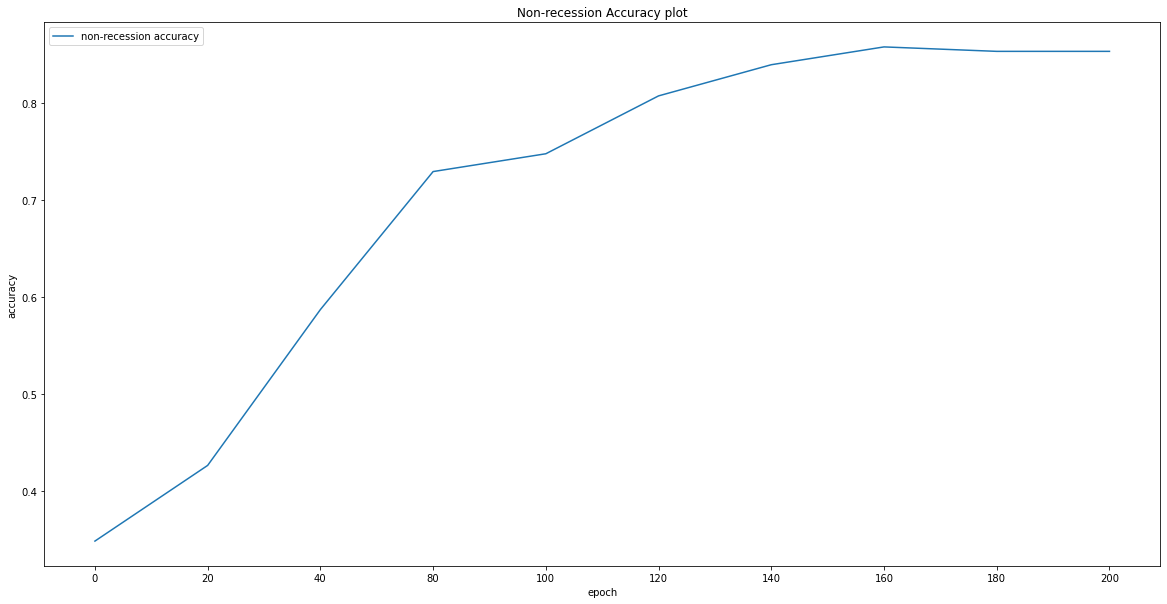

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

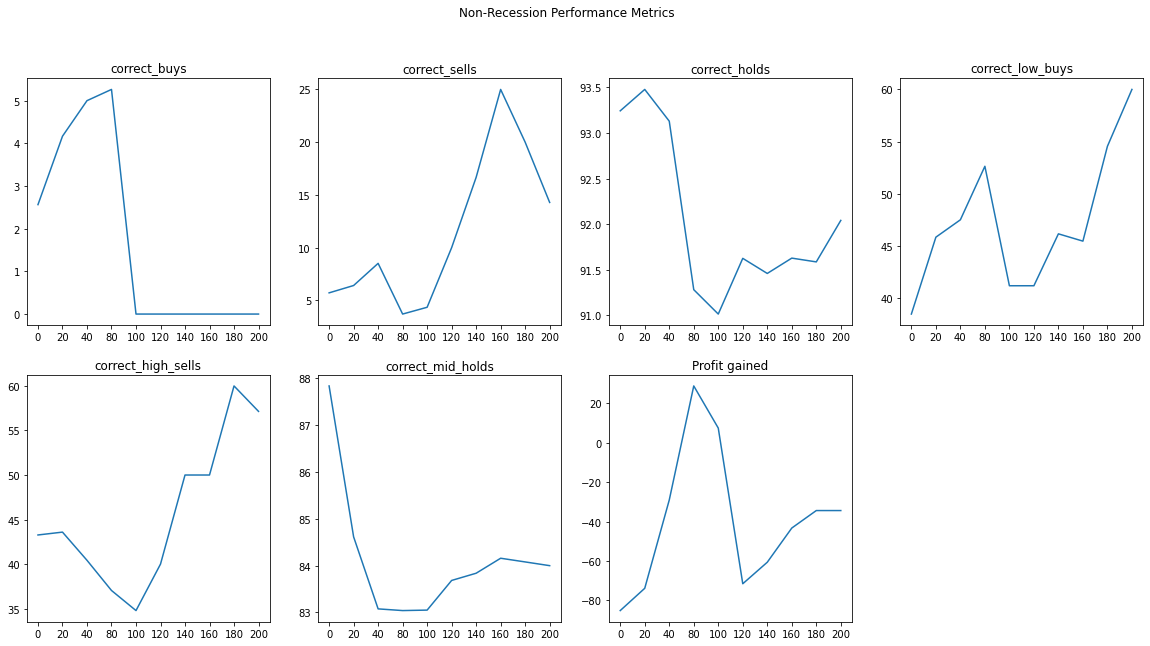

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

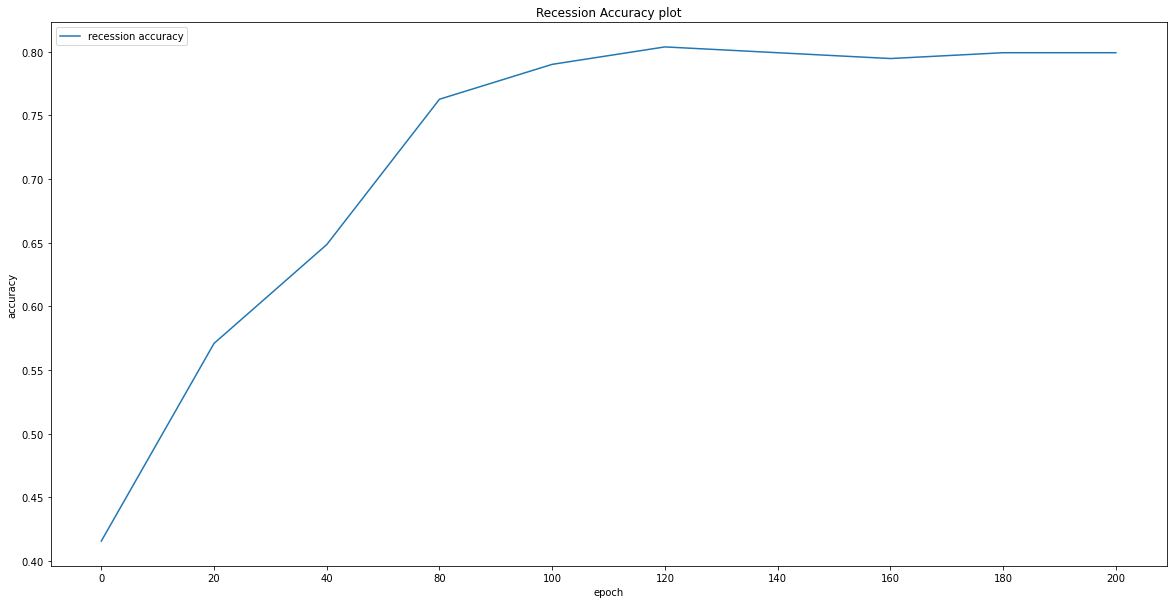

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()


Text(0.5, 1.0, 'Profit gained')

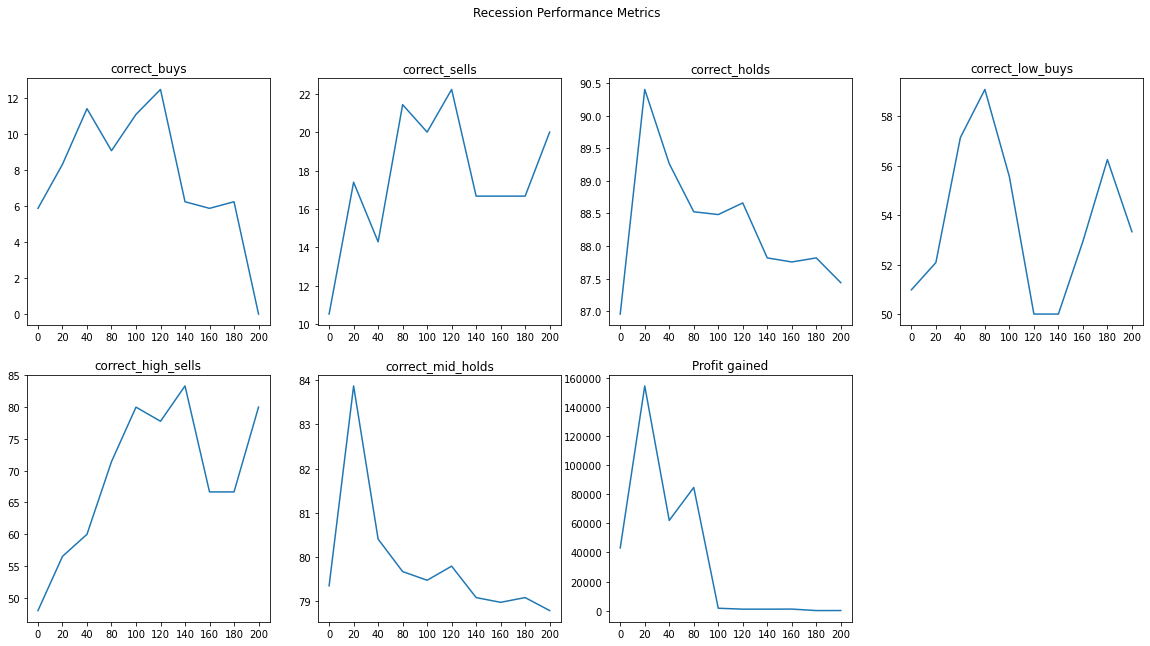

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## Manulife Financial Corporation

### No support Stock Price

In [329]:
nr_test_sets = ['MFC']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [330]:
r_test_sets = ['MFC']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21      6.09375  6.133837 -56.250000  1982400.0     2.0
2000-01-24      6.06250  6.122862 -60.000000  1705200.0     2.0
2000-01-25      5.96875  6.099153 -80.000000   909600.0     2.0
2000-01-26      6.00000  6.083898 -73.333333  1179600.0     2.0
2000-01-27      5.96875  6.066183 -80.000000   783000.0     2.0


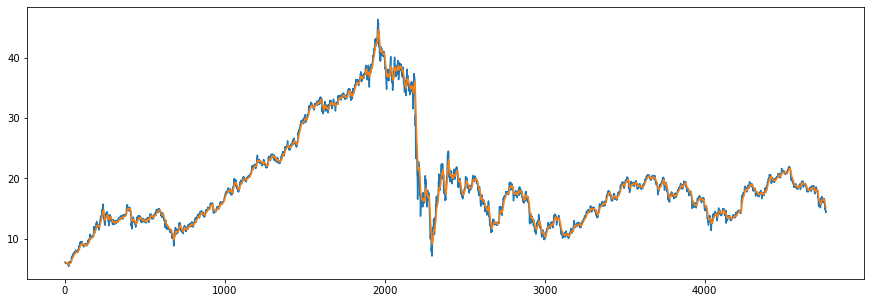

(4745, 15, 4)

In [331]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/MFC_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [332]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [333]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [334]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [335]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [336]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('MFC')]
    y = nr_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('MFC')]
    y = r_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'MFC')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2930 - accuracy: 0.4768 - mse: 0.4614 - weighted_accuracy: 0.3134 - weighted_mse: 0.5236 - val_loss: 0.2998 - val_accuracy: 0.0453 - val_mse: 0.3548 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3548
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2076 - accuracy: 0.3061 - mse: 0.8109 - weighted_accuracy: 0.4409 - weighted_mse: 0.7769 - val_loss: 0.2904 - val_accuracy: 0.0453 - val_mse: 0.3840 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3840
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1859 - accuracy: 0.2684 - mse: 1.0647 - weighted_accuracy: 0.5179 - weighted_mse: 1.0230 - val_loss: 0.2787 - val_accuracy: 0.0453 - val_mse: 0.4197 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4197
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.3242 - mse: 1.2926 - weighted_accuracy: 0.3242 - weighted_mse: 1.2926
Test loss: 0.18506258726119995
Test accuracy: 0.32420089840888977


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 88
actual holds but predicted sell: 51
actual predicted holds: 61
Percentage buys correct: 6.315789473684211%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 89.70588235294117%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.12765957446808%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase from

30/30 [==============================] - 0s 7ms/step - loss: 0.1349 - accuracy: 0.4513 - mse: 1.7252 - weighted_accuracy: 0.7235 - weighted_mse: 1.6190 - val_loss: 0.1971 - val_accuracy: 0.3625 - val_mse: 1.7786 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.7786
Epoch 15/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1330 - accuracy: 0.4099 - mse: 1.7562 - weighted_accuracy: 0.7319 - weighted_mse: 1.6297 - val_loss: 0.1875 - val_accuracy: 0.4183 - val_mse: 1.8332 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 1.8332
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1318 - accuracy: 0.4744 - mse: 1.7540 - weighted_accuracy: 0.7289 - weighted_mse: 1.6562 - val_loss: 0.1941 - val_accuracy: 0.3730 - val_mse: 1.9162 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.9162
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy: 0.4410 - mse: 1.8030 - weighted_accuracy: 0.7328 - weighted_mse: 1.6907

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1286 - accuracy: 0.4731 - mse: 1.8592 - weighted_accuracy: 0.7392 - weighted_mse: 1.7474 - val_loss: 0.1946 - val_accuracy: 0.3920 - val_mse: 1.8512 - val_weighted_accuracy: 0.3920 - val_weighted_mse: 1.8512
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1286 - accuracy: 0.4613 - mse: 1.8798 - weighted_accuracy: 0.7420 - weighted_mse: 1.7522 - val_loss: 0.1810 - val_accuracy: 0.4615 - val_mse: 2.1004 - val_weighted_accuracy: 0.4615 - val_weighted_mse: 2.1004
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1261 - accuracy: 0.4850 - mse: 1.9042 - weighted_accuracy: 0.7450 - weighted_mse: 1.7977 - val_loss: 0.1933 - val_accuracy: 0.4057 - val_mse: 1.9696 - val_weighted_accuracy: 0.4057 - val_weighted_mse: 1.9696
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.5047 - mse: 1.8792 - weighted_accuracy: 0.7634 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.5525 - mse: 2.3122 - weighted_accuracy: 0.5525 - weighted_mse: 2.3122
Test loss: 0.16237536072731018
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 46
actual holds but predicted sell: 40
actual predicted holds: 114
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.47619047619048%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 60.416666666666664%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase from previously

30/30 [==============================] - 0s 8ms/step - loss: 0.0974 - accuracy: 0.6683 - mse: 2.6253 - weighted_accuracy: 0.8462 - weighted_mse: 2.5145 - val_loss: 0.1892 - val_accuracy: 0.4805 - val_mse: 2.8245 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 2.8245
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.6531 - mse: 2.6398 - weighted_accuracy: 0.8408 - weighted_mse: 2.5165 - val_loss: 0.1860 - val_accuracy: 0.5195 - val_mse: 2.9133 - val_weighted_accuracy: 0.5195 - val_weighted_mse: 2.9133
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0972 - accuracy: 0.6399 - mse: 2.7136 - weighted_accuracy: 0.8413 - weighted_mse: 2.5722 - val_loss: 0.1896 - val_accuracy: 0.4963 - val_mse: 2.8166 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.8166
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0962 - accuracy: 0.6675 - mse: 2.7059 - weighted_accuracy: 0.8533 - weighted_mse: 2.5651

Epoch 1/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0940 - accuracy: 0.6736 - mse: 2.7555 - weighted_accuracy: 0.8554 - weighted_mse: 2.6249 - val_loss: 0.1879 - val_accuracy: 0.5300 - val_mse: 2.7693 - val_weighted_accuracy: 0.5300 - val_weighted_mse: 2.7693
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0944 - accuracy: 0.6589 - mse: 2.7933 - weighted_accuracy: 0.8413 - weighted_mse: 2.6465 - val_loss: 0.1676 - val_accuracy: 0.6059 - val_mse: 3.1776 - val_weighted_accuracy: 0.6059 - val_weighted_mse: 3.1776
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0932 - accuracy: 0.6828 - mse: 2.8223 - weighted_accuracy: 0.8553 - weighted_mse: 2.7100 - val_loss: 0.2106 - val_accuracy: 0.4573 - val_mse: 2.8003 - val_weighted_accuracy: 0.4573 - val_weighted_mse: 2.8003
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0920 - accuracy: 0.6791 - mse: 2.7921 - weighted_accuracy: 0.8592 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.6804 - mse: 3.6416 - weighted_accuracy: 0.6804 - weighted_mse: 3.6416
Test loss: 0.1362658441066742
Test accuracy: 0.6803653240203857


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 29
actual predicted holds: 144
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 12.121212121212121%
Percentage holds correct: 91.13924050632912%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 60.714285714285715%
Percentage high sells correct: 57.57575757575758%
Percentage mid holds correct: 82.1656050955414%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Pric

30/30 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.7987 - mse: 4.1058 - weighted_accuracy: 0.9102 - weighted_mse: 3.8428 - val_loss: 0.1689 - val_accuracy: 0.6681 - val_mse: 4.6010 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 4.6010
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 0.7850 - mse: 4.2243 - weighted_accuracy: 0.9106 - weighted_mse: 3.9221 - val_loss: 0.1926 - val_accuracy: 0.6133 - val_mse: 4.2954 - val_weighted_accuracy: 0.6133 - val_weighted_mse: 4.2954
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0658 - accuracy: 0.8045 - mse: 4.2330 - weighted_accuracy: 0.9211 - weighted_mse: 3.9097 - val_loss: 0.1712 - val_accuracy: 0.6723 - val_mse: 4.5379 - val_weighted_accuracy: 0.6723 - val_weighted_mse: 4.5379
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0634 - accuracy: 0.8035 - mse: 4.3450 - weighted_accuracy: 0.9171 - weighted_mse: 4.0421

Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.8030 - mse: 4.3644 - weighted_accuracy: 0.9206 - weighted_mse: 4.0236 - val_loss: 0.1611 - val_accuracy: 0.7239 - val_mse: 4.8901 - val_weighted_accuracy: 0.7239 - val_weighted_mse: 4.8901
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0634 - accuracy: 0.8109 - mse: 4.4216 - weighted_accuracy: 0.9234 - weighted_mse: 4.1562 - val_loss: 0.1914 - val_accuracy: 0.6154 - val_mse: 4.3666 - val_weighted_accuracy: 0.6154 - val_weighted_mse: 4.3666
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0634 - accuracy: 0.8122 - mse: 4.3967 - weighted_accuracy: 0.9188 - weighted_mse: 4.0875 - val_loss: 0.1724 - val_accuracy: 0.6628 - val_mse: 4.8024 - val_weighted_accuracy: 0.6628 - val_weighted_mse: 4.8024
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0637 - accuracy: 0.8093 - mse: 4.5347 - weighted_accuracy: 0.9228 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.7991 - mse: 5.6016 - weighted_accuracy: 0.7991 - weighted_mse: 5.6016
Test loss: 0.12349642813205719
Test accuracy: 0.7990867495536804


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 14
actual predicted holds: 170
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 92.3913043478261%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 72.22222222222223%
Percentage mid holds correct: 84.15300546448087%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price i

Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.8909 - mse: 6.8118 - weighted_accuracy: 0.9545 - weighted_mse: 6.0285 - val_loss: 0.1859 - val_accuracy: 0.7355 - val_mse: 6.8647 - val_weighted_accuracy: 0.7355 - val_weighted_mse: 6.8647
Validation loss: 0.18590228259563446
Validation accuracy: 0.735511064529419


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1360 - accuracy: 0.7936 - mse: 7.1876 - weighted_accuracy: 0.7936 - weighted_mse: 7.1876
Test loss: 0.13595202565193176
Test accuracy: 0.7935779690742493


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 10
actual predicted holds: 167
Percentage buys correct: 16.0%
Percentage sells correct: 16.666666666666668%
Percentage

Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.8901 - mse: 7.0058 - weighted_accuracy: 0.9526 - weighted_mse: 6.1473 - val_loss: 0.2043 - val_accuracy: 0.7313 - val_mse: 7.5234 - val_weighted_accuracy: 0.7313 - val_weighted_mse: 7.5234
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0392 - accuracy: 0.8901 - mse: 7.1102 - weighted_accuracy: 0.9579 - weighted_mse: 6.2000 - val_loss: 0.1901 - val_accuracy: 0.7703 - val_mse: 7.6416 - val_weighted_accuracy: 0.7703 - val_weighted_mse: 7.6416
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0373 - accuracy: 0.9102 - mse: 7.2656 - weighted_accuracy: 0.9653 - weighted_mse: 6.3268 - val_loss: 0.1968 - val_accuracy: 0.7408 - val_mse: 7.5179 - val_weighted_accuracy: 0.7408 - val_weighted_mse: 7.5179
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0393 - accuracy: 0.8994 - mse: 7.3302 - weighted_accuracy: 0.9577 - weighted_mse

30/30 [==============================] - 0s 9ms/step - loss: 0.0353 - accuracy: 0.9060 - mse: 8.3715 - weighted_accuracy: 0.9581 - weighted_mse: 7.1826 - val_loss: 0.2209 - val_accuracy: 0.7576 - val_mse: 9.3883 - val_weighted_accuracy: 0.7576 - val_weighted_mse: 9.3883
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0334 - accuracy: 0.9117 - mse: 8.4499 - weighted_accuracy: 0.9658 - weighted_mse: 7.1829 - val_loss: 0.2086 - val_accuracy: 0.8093 - val_mse: 9.7383 - val_weighted_accuracy: 0.8093 - val_weighted_mse: 9.7383
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0346 - accuracy: 0.9115 - mse: 8.5170 - weighted_accuracy: 0.9656 - weighted_mse: 7.3758 - val_loss: 0.2766 - val_accuracy: 0.6438 - val_mse: 8.0303 - val_weighted_accuracy: 0.6438 - val_weighted_mse: 8.0303
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0364 - accuracy: 0.9094 - mse: 8.4841 - weighted_accuracy: 0.9614 - weighted_mse: 7.3029 - 

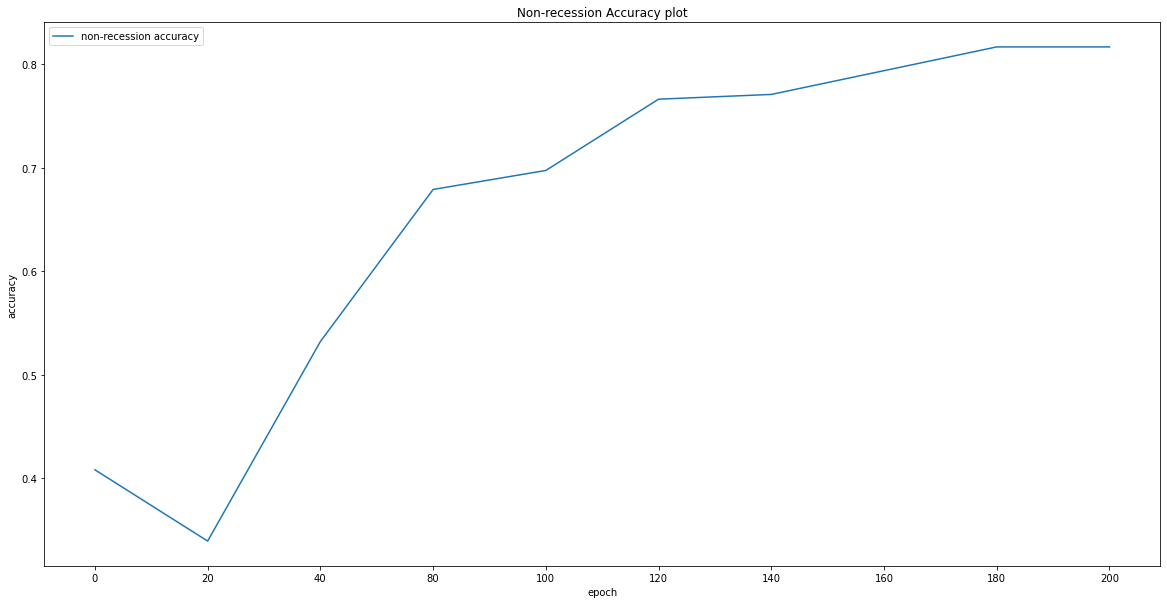

In [337]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

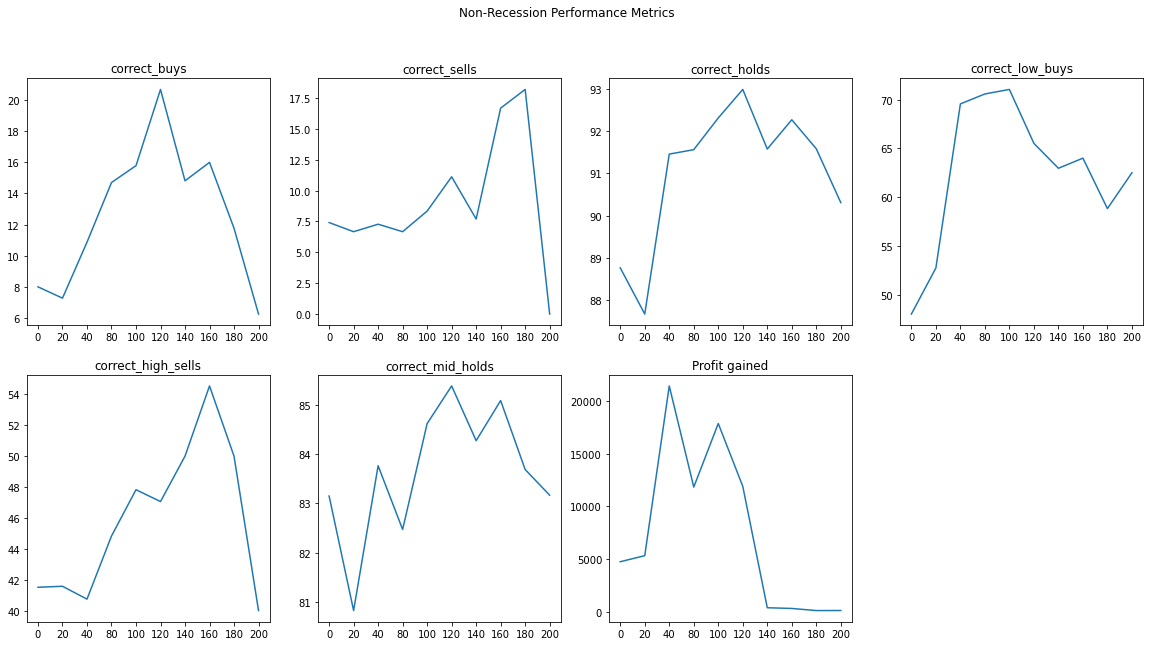

In [338]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

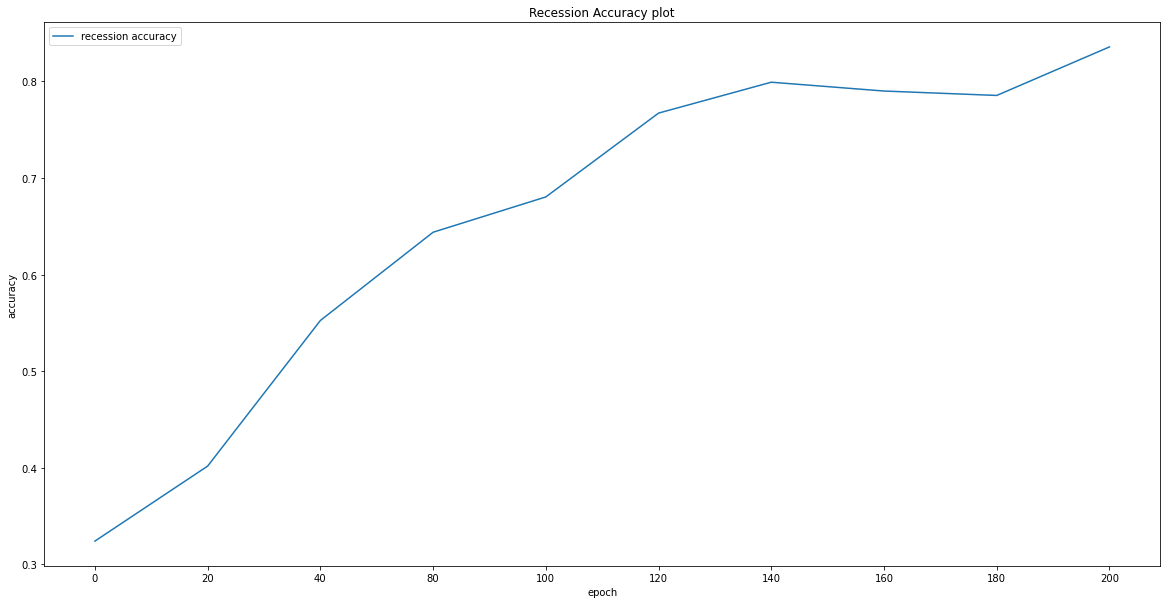

In [339]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

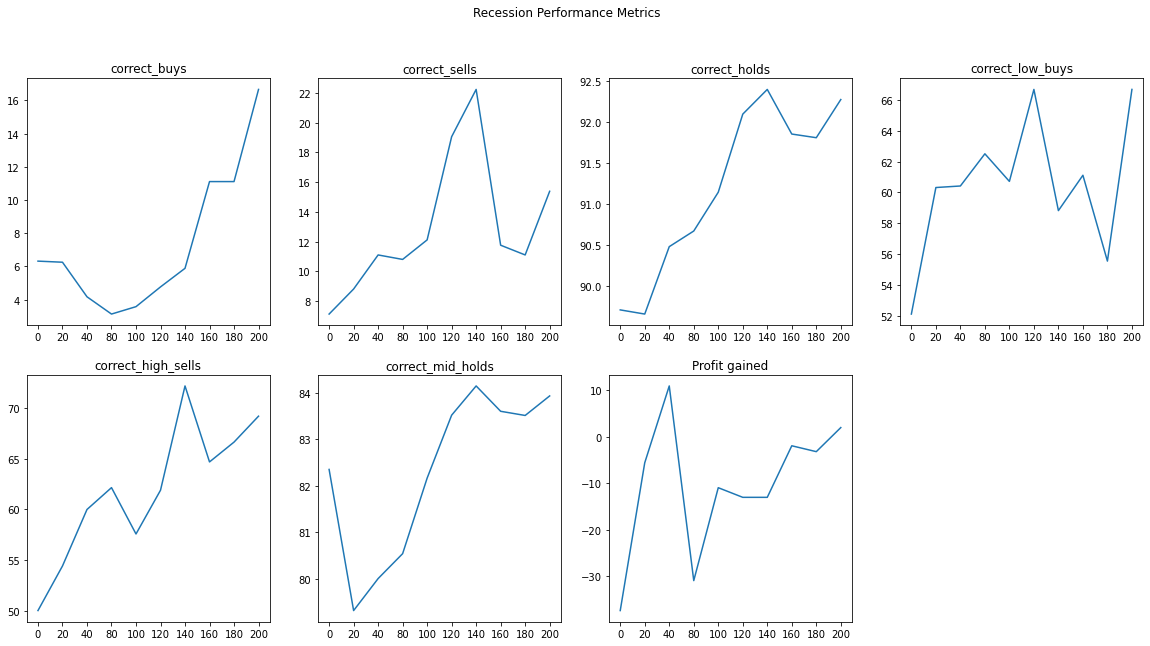

In [340]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [341]:
nr_test_sets = ['MFC']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/JPM_data_test.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        16.10  15.369379  -4.347841  12991200.0     2.0
2019-01-23        15.75  15.427936 -19.565241  11195700.0     2.0
2019-01-24        15.79  15.483638 -19.902947  12310800.0     2.0
2019-01-25        15.63  15.506155 -34.131754  10454700.0     2.0
2019-01-28        15.75  15.543670 -30.405447  11863600.0     2.0


In [342]:
r_test_sets = ['MFC']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/JPM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    20.620001  20.787224 -56.481365  5587900.0     2.0
2020-01-23    20.760000  20.783036 -48.453572  7034300.0     2.0
2020-01-24    20.799999  20.785645 -44.329960  8383300.0     2.0
2020-01-27    20.650000  20.764777 -59.793849  5159000.0     2.0
2020-01-28    20.030001  20.651734 -87.591226  2998800.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21      6.09375  6.133837 -56.250000  1982400.0     2.0
2000-01-24      6.06250  6.122862 -60.000000  1705200.0     2.0
2000-01-25      5.96875  6.099153 -80.000000   909600.0     2.0
2000-01-26      6.00000  6.083898 -73.333333  1179600.0     2.0
2000-01-27      5.96875  6.066183 -80.000000   783000.0     2.0


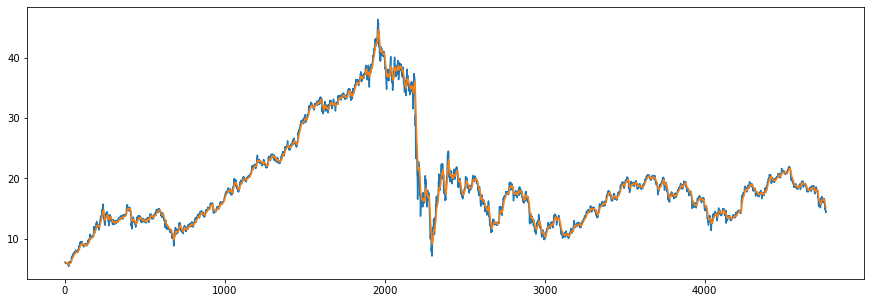

(4745, 15, 5)

In [343]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/MFC_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/JPM_data.csv")
df2.set_index('Date', inplace=True)
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)

X.shape

In [344]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [345]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [346]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [347]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [348]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('MFC')]
    y = nr_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'MFC')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('MFC')]
    y = r_test_data['{}_y'.format('MFC')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('MFC'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'MFC')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'MFC'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'MFC'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.9523809523809526, 1: 7.3996101364522415, 2: 0.3675089553683803}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 0.2979 - accuracy: 0.5340 - mse: 0.4398 - weighted_accuracy: 0.3253 - weighted_mse: 0.5214 - val_loss: 0.3009 - val_accuracy: 0.0421 - val_mse: 0.3536 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3536
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2125 - accuracy: 0.3583 - mse: 0.7681 - weighted_accuracy: 0.4176 - weighted_mse: 0.7508 - val_loss: 0.2919 - val_accuracy: 0.0453 - val_mse: 0.3817 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3817
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1895 - accuracy: 0.2937 - mse: 1.0117 - weighted_accuracy: 0.4695 - weighted_mse: 0.9794 - val_loss: 0.2799 - val_accuracy: 0.0453 - val_mse: 0.4150 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4150
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.3881 - mse: 1.2325 - weighted_accuracy: 0.3881 - weighted_mse: 1.2325
Test loss: 0.1820271611213684
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 61
actual holds but predicted sell: 61
actual predicted holds: 78
Percentage buys correct: 4.615384615384615%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 88.63636363636364%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 53.125%
Percentage high sells correct: 46.96969696969697%
Percentage mid holds correct: 80.68181818181819%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase fro

30/30 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.5290 - mse: 1.7543 - weighted_accuracy: 0.7786 - weighted_mse: 1.6830 - val_loss: 0.1991 - val_accuracy: 0.3878 - val_mse: 1.8718 - val_weighted_accuracy: 0.3878 - val_weighted_mse: 1.8718
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1233 - accuracy: 0.5076 - mse: 1.8126 - weighted_accuracy: 0.7749 - weighted_mse: 1.7281 - val_loss: 0.2051 - val_accuracy: 0.3625 - val_mse: 1.8570 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.8570
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1220 - accuracy: 0.4963 - mse: 1.8317 - weighted_accuracy: 0.7722 - weighted_mse: 1.7448 - val_loss: 0.1893 - val_accuracy: 0.4426 - val_mse: 1.8442 - val_weighted_accuracy: 0.4426 - val_weighted_mse: 1.8442
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1216 - accuracy: 0.5245 - mse: 1.8255 - weighted_accuracy: 0.7806 - weighted_mse: 1.7462




RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1190 - accuracy: 0.5503 - mse: 1.8680 - weighted_accuracy: 0.7887 - weighted_mse: 1.7971 - val_loss: 0.1889 - val_accuracy: 0.4594 - val_mse: 1.8554 - val_weighted_accuracy: 0.4594 - val_weighted_mse: 1.8554
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1180 - accuracy: 0.5274 - mse: 1.9094 - weighted_accuracy: 0.7839 - weighted_mse: 1.8217 - val_loss: 0.1671 - val_accuracy: 0.5374 - val_mse: 2.0587 - val_weighted_accuracy: 0.5374 - val_weighted_mse: 2.0587
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1162 - accuracy: 0.5656 - mse: 1.9122 - weighted_accuracy: 0.8030 - weighted_mse: 1.8475 - val_loss: 0.1894 - val_accuracy: 0.4689 - val_mse: 1.9712 - val_weighted_accuracy: 0.4689 - val_weighted_mse: 1.9712
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1164 - accuracy: 0.5772 - mse: 1.9136 - weighted_ac

7/7 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.5571 - mse: 2.3887 - weighted_accuracy: 0.5571 - weighted_mse: 2.3887
Test loss: 0.16476614773273468
Test accuracy: 0.5570776462554932


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 48
actual holds but predicted sell: 36
actual predicted holds: 116
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 89.92248062015504%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 48.717948717948715%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase

30/30 [==============================] - 0s 9ms/step - loss: 0.0795 - accuracy: 0.7653 - mse: 2.9157 - weighted_accuracy: 0.8995 - weighted_mse: 2.8693 - val_loss: 0.1964 - val_accuracy: 0.5427 - val_mse: 2.9021 - val_weighted_accuracy: 0.5427 - val_weighted_mse: 2.9021
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0793 - accuracy: 0.7384 - mse: 2.9165 - weighted_accuracy: 0.8930 - weighted_mse: 2.8750 - val_loss: 0.1843 - val_accuracy: 0.5880 - val_mse: 3.1291 - val_weighted_accuracy: 0.5880 - val_weighted_mse: 3.1291
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.7605 - mse: 2.9484 - weighted_accuracy: 0.9031 - weighted_mse: 2.8844 - val_loss: 0.1709 - val_accuracy: 0.6238 - val_mse: 2.9804 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 2.9804
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.7737 - mse: 2.9874 - weighted_accuracy: 0.9079 - weighted_mse: 2.9418

30/30 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 0.7695 - mse: 3.0528 - weighted_accuracy: 0.9030 - weighted_mse: 2.9910 - val_loss: 0.1712 - val_accuracy: 0.6154 - val_mse: 3.3126 - val_weighted_accuracy: 0.6154 - val_weighted_mse: 3.3126
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0750 - accuracy: 0.7687 - mse: 3.0757 - weighted_accuracy: 0.9081 - weighted_mse: 3.0137 - val_loss: 0.1509 - val_accuracy: 0.7071 - val_mse: 3.5379 - val_weighted_accuracy: 0.7071 - val_weighted_mse: 3.5379
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.7800 - mse: 3.1007 - weighted_accuracy: 0.9119 - weighted_mse: 3.0734 - val_loss: 0.1883 - val_accuracy: 0.5796 - val_mse: 3.1522 - val_weighted_accuracy: 0.5796 - val_weighted_mse: 3.1522
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.7827 - mse: 3.1467 - weighted_accuracy: 0.9060 - weighted_mse: 3.0972 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.6986 - mse: 4.4240 - weighted_accuracy: 0.6986 - weighted_mse: 4.4240
Test loss: 0.16620254516601562
Test accuracy: 0.698630154132843


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 31
actual holds but predicted sell: 21
actual predicted holds: 148
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 12.5%
Percentage holds correct: 91.35802469135803%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 57.57575757575758%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 83.85093167701864%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase fr

30/30 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.8770 - mse: 5.1443 - weighted_accuracy: 0.9548 - weighted_mse: 4.8714 - val_loss: 0.1824 - val_accuracy: 0.7102 - val_mse: 5.0894 - val_weighted_accuracy: 0.7102 - val_weighted_mse: 5.0894
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0467 - accuracy: 0.8667 - mse: 5.1244 - weighted_accuracy: 0.9510 - weighted_mse: 4.8927 - val_loss: 0.1914 - val_accuracy: 0.7187 - val_mse: 5.4680 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 5.4680
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0457 - accuracy: 0.8754 - mse: 5.2323 - weighted_accuracy: 0.9488 - weighted_mse: 4.9276 - val_loss: 0.1859 - val_accuracy: 0.7176 - val_mse: 5.6122 - val_weighted_accuracy: 0.7176 - val_weighted_mse: 5.6122
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0439 - accuracy: 0.8820 - mse: 5.3676 - weighted_accuracy: 0.9514 - weighted_mse: 5.0787

Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0430 - accuracy: 0.8799 - mse: 5.4089 - weighted_accuracy: 0.9541 - weighted_mse: 5.1087 - val_loss: 0.1779 - val_accuracy: 0.7661 - val_mse: 6.1116 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 6.1116
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0430 - accuracy: 0.8854 - mse: 5.4807 - weighted_accuracy: 0.9560 - weighted_mse: 5.2161 - val_loss: 0.2044 - val_accuracy: 0.6712 - val_mse: 5.3513 - val_weighted_accuracy: 0.6712 - val_weighted_mse: 5.3513
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0434 - accuracy: 0.8859 - mse: 5.5267 - weighted_accuracy: 0.9563 - weighted_mse: 5.2255 - val_loss: 0.1866 - val_accuracy: 0.7460 - val_mse: 5.7435 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 5.7435
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.8917 - mse: 5.6132 - weighted_accuracy: 0.9550 - weighted_mse

Shares owned at the moment: 0
Cash capital at the moment: $33.9367700905291


Share price: $0.4352874135052769
Shares owned at the moment: 77
Cash capital at the moment: $0.3274671408130345


Price increase from previously bought: 10.0566743635661%
Share price: $0.4803802740679666
Shares owned at the moment: 0
Cash capital at the moment: $37.21502772101257


Share price: $0.40964639002633696
Shares owned at the moment: 90
Cash capital at the moment: $0.24546513711072038


Price increase from previously bought: 26.201034227740294%
Share price: $0.5183996703372871
Shares owned at the moment: 0
Cash capital at the moment: $46.77313154905808


Share price: $0.5458090809699045
Shares owned at the moment: 85
Cash capital at the moment: $0.25177679393947017


Price increase from previously bought: -17.07533013794832%
Share price: $0.453855057012188
Shares owned at the moment: 0
Cash capital at the moment: $38.723368020398844


Share price: $0.4812643833234649
Shares owned at the moment: 80
Ca

7/7 [==============================] - 0s 3ms/step - loss: 0.2327 - accuracy: 0.7945 - mse: 9.8689 - weighted_accuracy: 0.7945 - weighted_mse: 9.8689
Test loss: 0.23268093168735504
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 8
actual predicted holds: 171
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 20.0%
Percentage holds correct: 91.44385026737967%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 30.0%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.9542971538006071
Shares owned at the moment: 104
Cash capital at the moment: $0.48016701874988144


Price increase from previously b

Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9539 - mse: 11.2894 - weighted_accuracy: 0.9831 - weighted_mse: 9.6761 - val_loss: 0.2743 - val_accuracy: 0.7893 - val_mse: 11.8717 - val_weighted_accuracy: 0.7893 - val_weighted_mse: 11.8717
Validation loss: 0.2743016481399536
Validation accuracy: 0.7892518639564514


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.8165 - mse: 12.6686 - weighted_accuracy: 0.8165 - weighted_mse: 12.6686
Test loss: 0.2298414558172226
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 8
actual predicted holds: 175
Percentage buys correct: 6.25%
Percentage sells correct: 20.0%
Percentage holds corr

30/30 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9547 - mse: 12.3249 - weighted_accuracy: 0.9833 - weighted_mse: 10.5136 - val_loss: 0.2902 - val_accuracy: 0.7682 - val_mse: 12.1708 - val_weighted_accuracy: 0.7682 - val_weighted_mse: 12.1708
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0184 - accuracy: 0.9594 - mse: 12.3517 - weighted_accuracy: 0.9851 - weighted_mse: 10.5243 - val_loss: 0.2991 - val_accuracy: 0.7745 - val_mse: 12.4020 - val_weighted_accuracy: 0.7745 - val_weighted_mse: 12.4020
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0192 - accuracy: 0.9568 - mse: 12.7670 - weighted_accuracy: 0.9824 - weighted_mse: 10.8610 - val_loss: 0.2869 - val_accuracy: 0.7829 - val_mse: 12.6230 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 12.6230
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9602 - mse: 12.6459 - weighted_accuracy: 0.9854 - weighte

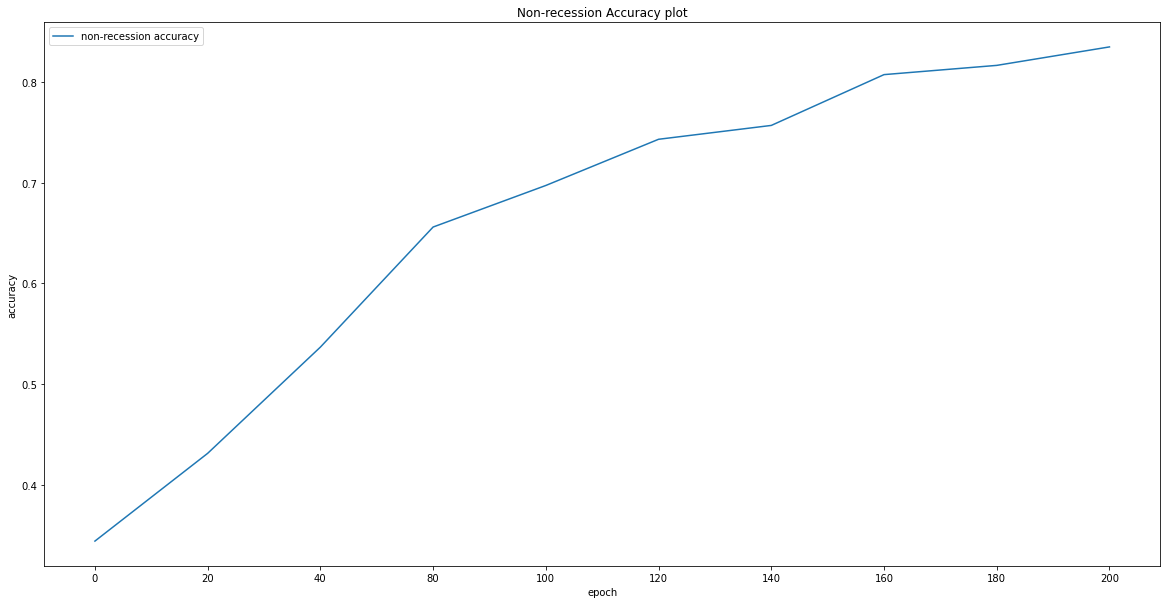

In [349]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

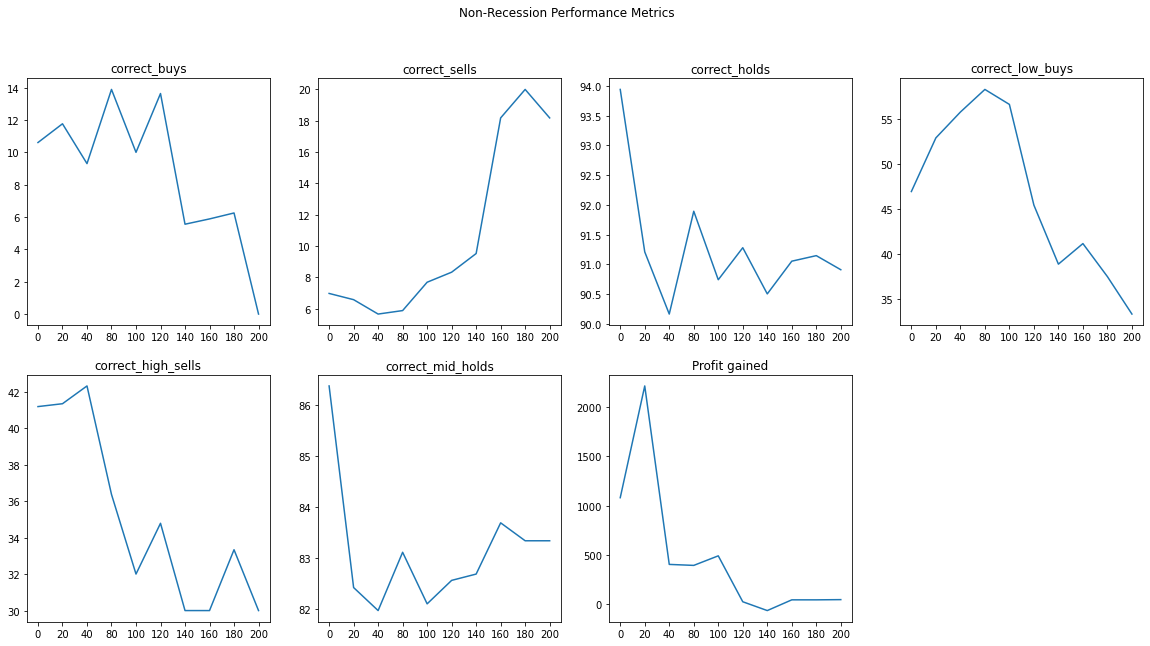

In [350]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

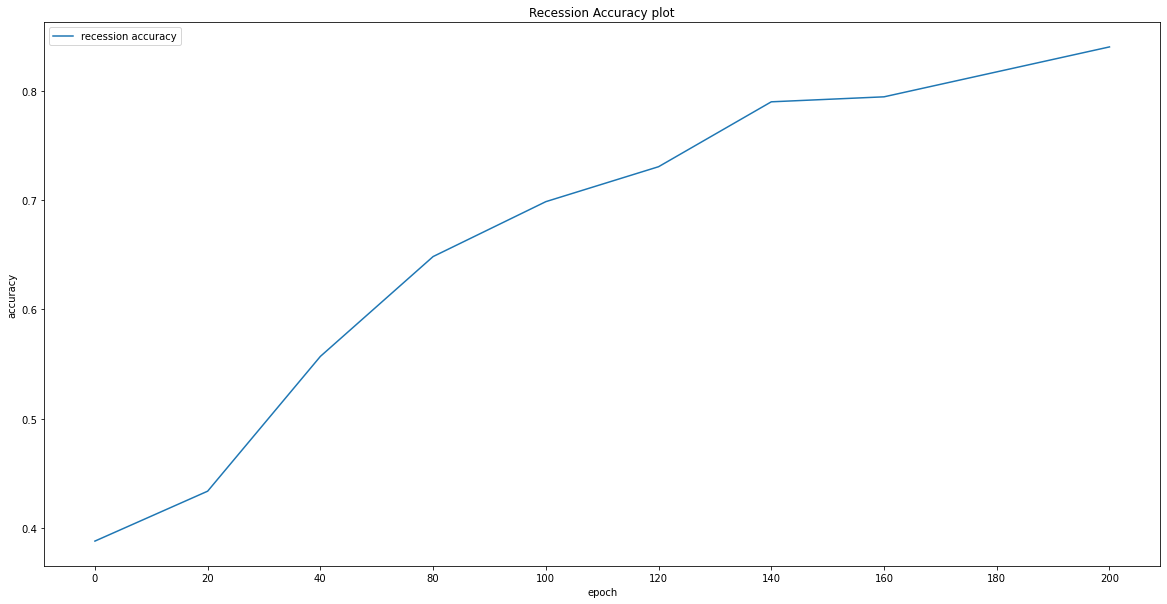

In [351]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

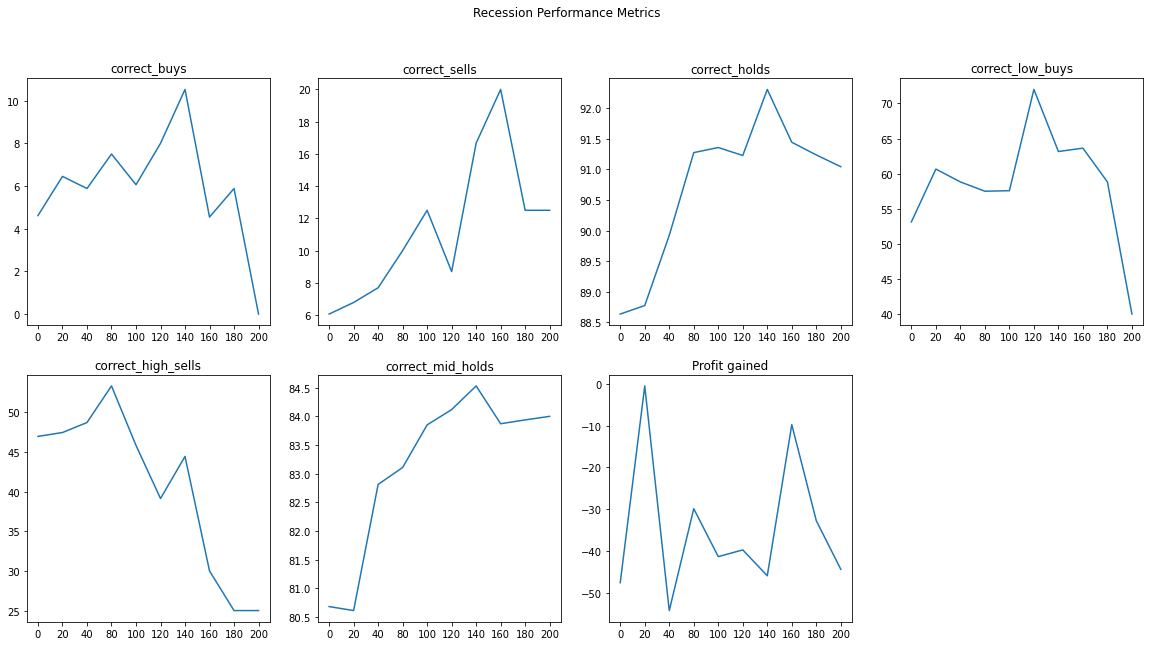

In [352]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

## ON Semiconductor Corporation

### No support Stock Data

In [353]:
nr_test_sets = ['ON']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0


In [354]:
r_test_sets = ['ON']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-05-22      22.7500  21.868590 -31.896552  -691100.0     2.0
2000-05-23      20.0000  21.581114 -67.289720 -1747800.0     2.0
2000-05-24      19.8750  21.318635 -69.158879 -3059300.0     2.0
2000-05-25      19.5000  21.038845 -74.766355 -3905000.0     2.0
2000-05-26      18.1875  20.600177 -94.392523 -4983300.0     1.0


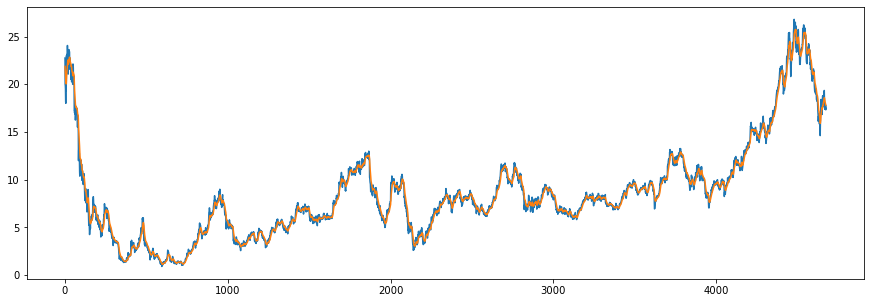

(4661, 15, 4)

In [355]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/ON_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [356]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [357]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [358]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [359]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [360]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('ON')]
    y = nr_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_non_recession.csv'.format(experiment,'ON')):
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('no_support_{}_{}_non_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('ON')]
    y = r_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('no_support_{}_{}_recession.csv'.format(experiment,'ON')):
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('no_support_{}_{}_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 39ms/step - loss: 0.2925 - accuracy: 0.5003 - mse: 0.4600 - weighted_accuracy: 0.3118 - weighted_mse: 0.5447 - val_loss: 0.2993 - val_accuracy: 0.0429 - val_mse: 0.3551 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3551
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2084 - accuracy: 0.3635 - mse: 0.7923 - weighted_accuracy: 0.4721 - weighted_mse: 0.7679 - val_loss: 0.2908 - val_accuracy: 0.0429 - val_mse: 0.3867 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3867
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.3222 - mse: 1.0322 - weighted_accuracy: 0.5291 - weighted_mse: 0.9959 - val_loss: 0.2804 - val_accuracy: 0.0429 - val_mse: 0.4268 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.4268
Epoch 4/20
30/30 [==============================] - 0s 8

7/7 [==============================] - 0s 4ms/step - loss: 0.1652 - accuracy: 0.5708 - mse: 1.3317 - weighted_accuracy: 0.5708 - weighted_mse: 1.3317
Test loss: 0.16521169245243073
Test accuracy: 0.5707762837409973


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 47
actual holds but predicted sell: 33
actual predicted holds: 118
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.07633587786259%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 50.98039215686274%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 81.6793893129771%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price

30/30 [==============================] - 0s 8ms/step - loss: 0.1260 - accuracy: 0.5051 - mse: 1.8122 - weighted_accuracy: 0.7576 - weighted_mse: 1.7871 - val_loss: 0.1889 - val_accuracy: 0.4169 - val_mse: 1.8982 - val_weighted_accuracy: 0.4169 - val_weighted_mse: 1.8982
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1257 - accuracy: 0.4772 - mse: 1.8399 - weighted_accuracy: 0.7515 - weighted_mse: 1.7854 - val_loss: 0.1788 - val_accuracy: 0.4727 - val_mse: 1.8597 - val_weighted_accuracy: 0.4727 - val_weighted_mse: 1.8597
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1247 - accuracy: 0.4753 - mse: 1.8454 - weighted_accuracy: 0.7648 - weighted_mse: 1.7989 - val_loss: 0.1927 - val_accuracy: 0.4051 - val_mse: 1.8887 - val_weighted_accuracy: 0.4051 - val_weighted_mse: 1.8887
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.4785 - mse: 1.9009 - weighted_accuracy: 0.7499 - weighted_mse: 1.8546

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.5040 - mse: 1.8980 - weighted_accuracy: 0.7753 - weighted_mse: 1.8573 - val_loss: 0.1749 - val_accuracy: 0.4780 - val_mse: 1.9138 - val_weighted_accuracy: 0.4780 - val_weighted_mse: 1.9138
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.5094 - mse: 1.9437 - weighted_accuracy: 0.7652 - weighted_mse: 1.9138 - val_loss: 0.1747 - val_accuracy: 0.4866 - val_mse: 1.9842 - val_weighted_accuracy: 0.4866 - val_weighted_mse: 1.9842
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1198 - accuracy: 0.5126 - mse: 1.9573 - weighted_accuracy: 0.7764 - weighted_mse: 1.9261 - val_loss: 0.1807 - val_accuracy: 0.4652 - val_mse: 1.9978 - val_weighted_accuracy: 0.4652 - val_weighted_mse: 1.9978
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.4874 - mse: 1.9845 - weighted_accuracy: 0.7631 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1787 - accuracy: 0.5342 - mse: 2.1492 - weighted_accuracy: 0.5342 - weighted_mse: 2.1492
Test loss: 0.17871549725532532
Test accuracy: 0.534246563911438


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 49
actual holds but predicted sell: 44
actual predicted holds: 105
Percentage buys correct: 12.5%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 92.10526315789474%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 51.785714285714285%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 83.1858407079646%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase fro

Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0958 - accuracy: 0.6467 - mse: 2.6128 - weighted_accuracy: 0.8512 - weighted_mse: 2.6291 - val_loss: 0.1757 - val_accuracy: 0.5456 - val_mse: 2.8581 - val_weighted_accuracy: 0.5456 - val_weighted_mse: 2.8581
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0963 - accuracy: 0.6282 - mse: 2.6724 - weighted_accuracy: 0.8425 - weighted_mse: 2.6856 - val_loss: 0.1690 - val_accuracy: 0.5766 - val_mse: 2.6696 - val_weighted_accuracy: 0.5766 - val_weighted_mse: 2.6696
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0942 - accuracy: 0.6864 - mse: 2.6700 - weighted_accuracy: 0.8516 - weighted_mse: 2.7375 - val_loss: 0.1795 - val_accuracy: 0.5488 - val_mse: 2.8158 - val_weighted_accuracy: 0.5488 - val_weighted_mse: 2.8158
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0937 - accuracy: 0.6717 - mse: 2.7014 - weighted_accuracy: 0.8523 - weighted

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0912 - accuracy: 0.6778 - mse: 2.7650 - weighted_accuracy: 0.8567 - weighted_mse: 2.7961 - val_loss: 0.1657 - val_accuracy: 0.6099 - val_mse: 2.8926 - val_weighted_accuracy: 0.6099 - val_weighted_mse: 2.8926
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0886 - accuracy: 0.6867 - mse: 2.8837 - weighted_accuracy: 0.8699 - weighted_mse: 2.9500 - val_loss: 0.1662 - val_accuracy: 0.6249 - val_mse: 2.9910 - val_weighted_accuracy: 0.6249 - val_weighted_mse: 2.9910
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0880 - accuracy: 0.6996 - mse: 2.8626 - weighted_accuracy: 0.8746 - weighted_mse: 2.9111 - val_loss: 0.1795 - val_accuracy: 0.5777 - val_mse: 2.8785 - val_weighted_accuracy: 0.5777 - val_weighted_mse: 2.8785
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0885 - accuracy: 0.6744 - mse: 2.9093 - weighted_accuracy: 0.8673 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.6119 - mse: 3.3357 - weighted_accuracy: 0.6119 - weighted_mse: 3.3357
Test loss: 0.17425663769245148
Test accuracy: 0.611872136592865


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 29
actual holds but predicted sell: 43
actual predicted holds: 126
Percentage buys correct: 12.121212121212121%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 90.64748201438849%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 48.93617021276596%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price i

Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.7806 - mse: 4.0535 - weighted_accuracy: 0.9061 - weighted_mse: 4.0495 - val_loss: 0.1716 - val_accuracy: 0.6699 - val_mse: 4.5160 - val_weighted_accuracy: 0.6699 - val_weighted_mse: 4.5160
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0674 - accuracy: 0.7728 - mse: 4.1351 - weighted_accuracy: 0.9092 - weighted_mse: 4.1556 - val_loss: 0.1568 - val_accuracy: 0.7106 - val_mse: 4.4361 - val_weighted_accuracy: 0.7106 - val_weighted_mse: 4.4361
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0653 - accuracy: 0.8031 - mse: 4.1727 - weighted_accuracy: 0.9182 - weighted_mse: 4.2215 - val_loss: 0.1681 - val_accuracy: 0.6645 - val_mse: 4.6121 - val_weighted_accuracy: 0.6645 - val_weighted_mse: 4.6121
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.7975 - mse: 4.2150 - weighted_accuracy: 0.9162 - weighted

0          75.893439  



RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0632 - accuracy: 0.8015 - mse: 4.3141 - weighted_accuracy: 0.9217 - weighted_mse: 4.3043 - val_loss: 0.1668 - val_accuracy: 0.6988 - val_mse: 4.6698 - val_weighted_accuracy: 0.6988 - val_weighted_mse: 4.6698
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0624 - accuracy: 0.7988 - mse: 4.4978 - weighted_accuracy: 0.9167 - weighted_mse: 4.5278 - val_loss: 0.1775 - val_accuracy: 0.6785 - val_mse: 4.9934 - val_weighted_accuracy: 0.6785 - val_weighted_mse: 4.9934
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0612 - accuracy: 0.8122 - mse: 4.4832 - weighted_accuracy: 0.9256 - weighted_mse: 4.4782 - val_loss: 0.1791 - val_accuracy: 0.6806 - val_mse: 4.5053 - val_weighted_accuracy: 0.6806 - val_weighted_mse: 4.5053
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0610 - accuracy: 0.8058 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1873 - accuracy: 0.6895 - mse: 5.1678 - weighted_accuracy: 0.6895 - weighted_mse: 5.1678
Test loss: 0.18734824657440186
Test accuracy: 0.689497709274292


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 36
actual predicted holds: 142
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 92.20779220779221%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 52.0%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 84.31372549019608%


Capital: 100
Share price: $0.12015119342141871
Shares owned at the moment: 830
Cash capital at the moment: $0.00026436123808082357


Price increase from previously bought: 93.66120126362

Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.8554 - mse: 6.3536 - weighted_accuracy: 0.9393 - weighted_mse: 6.1338 - val_loss: 0.1830 - val_accuracy: 0.7546 - val_mse: 7.0169 - val_weighted_accuracy: 0.7546 - val_weighted_mse: 7.0169
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.8774 - mse: 6.5323 - weighted_accuracy: 0.9513 - weighted_mse: 6.2999 - val_loss: 0.1905 - val_accuracy: 0.7245 - val_mse: 7.3039 - val_weighted_accuracy: 0.7245 - val_weighted_mse: 7.3039
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.8747 - mse: 6.5320 - weighted_accuracy: 0.9524 - weighted_mse: 6.2238 - val_loss: 0.1887 - val_accuracy: 0.7438 - val_mse: 7.5200 - val_weighted_accuracy: 0.7438 - val_weighted_mse: 7.5200
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.8672 - mse: 6.4606 - weighted_accuracy: 0.9516 - weighted

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0430 - accuracy: 0.8734 - mse: 6.7013 - weighted_accuracy: 0.9479 - weighted_mse: 6.3693 - val_loss: 0.1983 - val_accuracy: 0.7428 - val_mse: 7.1027 - val_weighted_accuracy: 0.7428 - val_weighted_mse: 7.1027
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0427 - accuracy: 0.8742 - mse: 6.9065 - weighted_accuracy: 0.9522 - weighted_mse: 6.6273 - val_loss: 0.2142 - val_accuracy: 0.6977 - val_mse: 7.7825 - val_weighted_accuracy: 0.6977 - val_weighted_mse: 7.7825
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0415 - accuracy: 0.8855 - mse: 6.9623 - weighted_accuracy: 0.9583 - weighted_mse: 6.6036 - val_loss: 0.2088 - val_accuracy: 0.7224 - val_mse: 7.1919 - val_weighted_accuracy: 0.7224 - val_weighted_mse: 7.1919
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.8742 - mse: 6.9979 - weighted_accuracy: 0.9521 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.7306 - mse: 7.5050 - weighted_accuracy: 0.7306 - weighted_mse: 7.5050
Test loss: 0.20409135520458221
Test accuracy: 0.7305936217308044


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 28
actual predicted holds: 155
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.64327485380117%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 83.52941176470588%


Capital: 100
Share price: $0.12015119342141871
Shares owned at the moment: 830
Cash capital at the moment: $0.00026436123808082357


Price incre

Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9166 - mse: 9.5365 - weighted_accuracy: 0.9696 - weighted_mse: 8.7469 - val_loss: 0.2344 - val_accuracy: 0.7503 - val_mse: 10.5730 - val_weighted_accuracy: 0.7503 - val_weighted_mse: 10.5730
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0313 - accuracy: 0.9211 - mse: 9.8317 - weighted_accuracy: 0.9673 - weighted_mse: 8.9366 - val_loss: 0.2417 - val_accuracy: 0.7288 - val_mse: 10.1373 - val_weighted_accuracy: 0.7288 - val_weighted_mse: 10.1373
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9182 - mse: 9.6512 - weighted_accuracy: 0.9682 - weighted_mse: 8.7261 - val_loss: 0.2377 - val_accuracy: 0.7481 - val_mse: 9.9010 - val_weighted_accuracy: 0.7481 - val_weighted_mse: 9.9010
Validation loss: 0.237749382853508
Validation accuracy: 0.7481243014335632


Non-Recession Test


7/7 [==============================] - 0s 3ms/ste

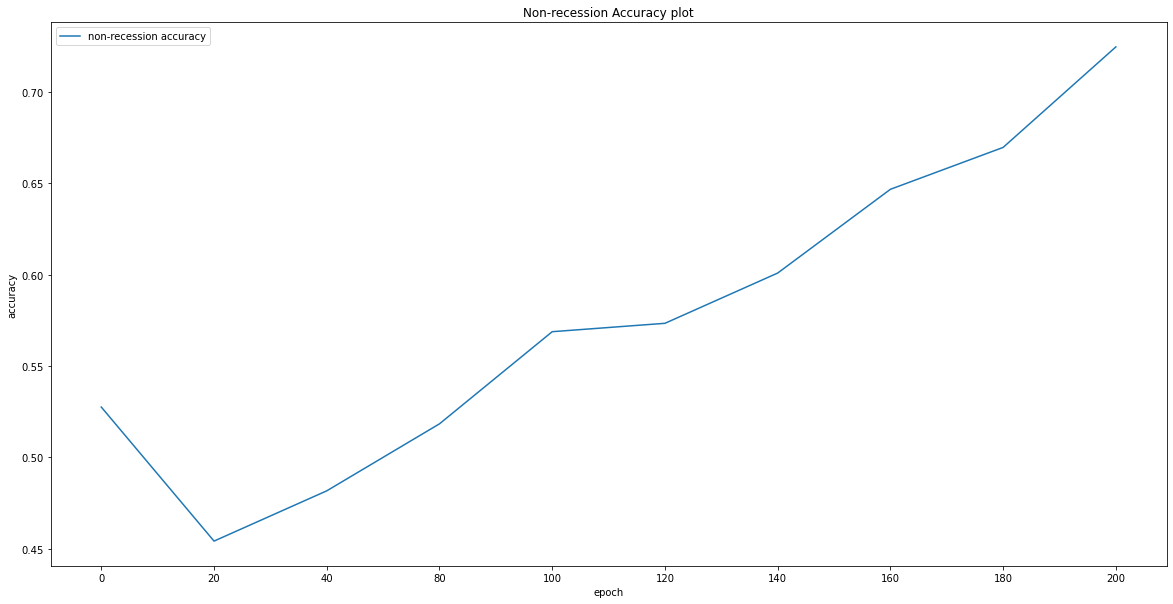

In [361]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

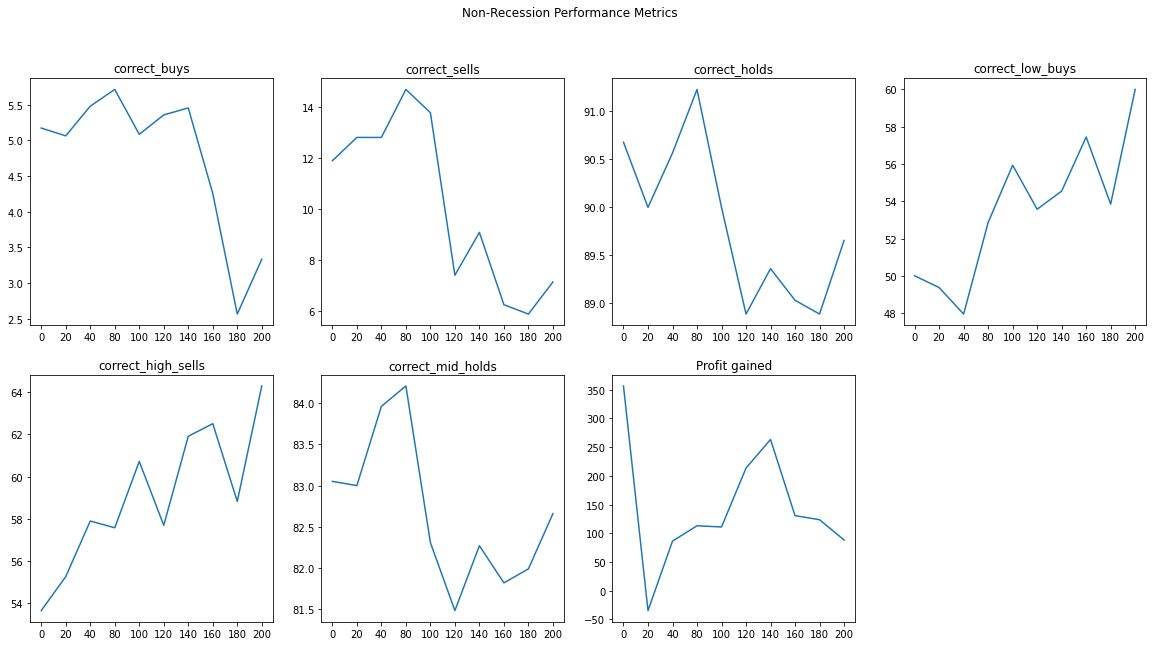

In [362]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

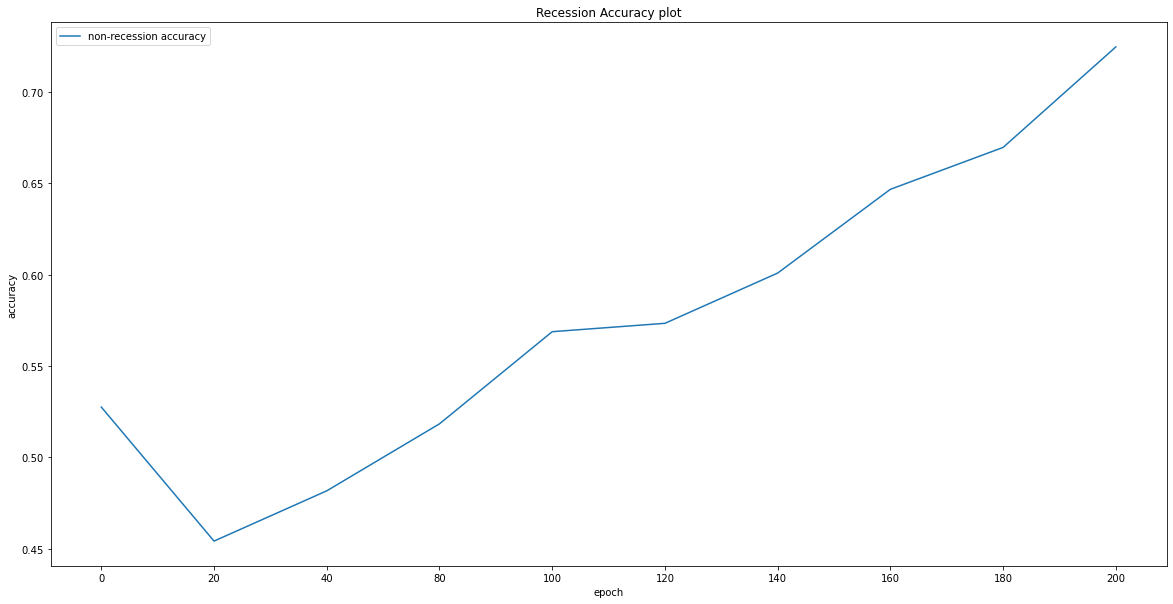

In [363]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

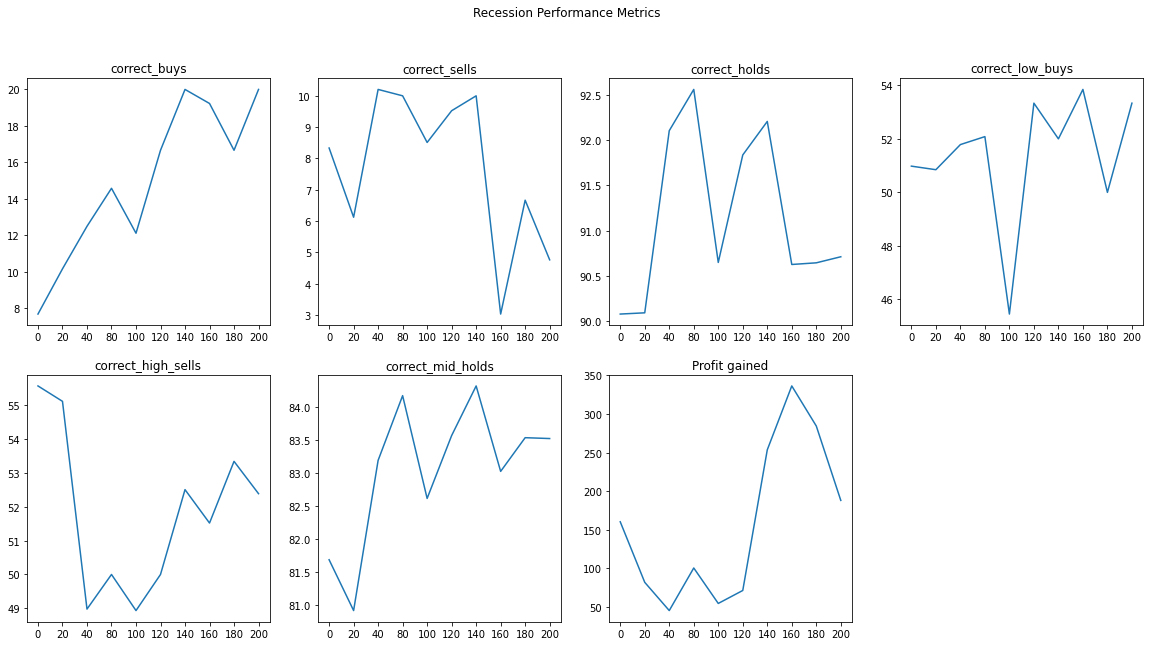

In [364]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### With Support Stock Data

In [365]:
nr_test_sets = ['ON']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/TSM_data_test.csv")
    df2.set_index('Date', inplace=True)
    print(df2.head())
    
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    18.410000  17.463881 -16.959062  38067400.0     2.0
2019-01-23    17.760000  17.509437 -35.964898  32120500.0     1.0
2019-01-24    17.610001  17.524909 -40.350852  27571200.0     2.0
2019-01-25    18.990000  17.750307  -5.688638  39283300.0     2.0
2019-01-28    20.120001  18.114876  -3.499985  49475700.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    36.840000  35.988585 -22.189342  49908500.0     2.0
2019-01-23    36.369999  36.047264 -22.857127  36526800.0     2.0
2019-01-24    36.490002  36.115377 -18.571314  50445400.0     2.0
2019-01-25    37.639999  36.349935  -0.000000  64539500.0     2.0
2019-01-28    38.139999  36.625329  -3.314889  81303200.0     2.0


In [366]:
r_test_sets = ['ON']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    df2 = pd.read_csv("variation 6/initial_indicators/TSM_data_test2.csv")
    df2.set_index('Date', inplace=True)
    labels = df['labels'].values
    df.drop(['labels'], axis='columns', inplace=True)
    df['support'] = df2['previous_1d']
    df['labels'] = labels
    
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 5)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    24.790001  24.846573 -58.549170  15793400.0     2.0
2020-01-23    24.799999  24.839408 -58.031122  19314300.0     2.0
2020-01-24    25.469999  24.936422 -23.316098  25250200.0     2.0
2020-01-27    24.990000  24.944665 -48.186537  19824200.0     2.0
2020-01-28    23.660000  24.747024 -96.170207  12158200.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-05-22      22.7500  21.868590 -31.896552  -691100.0     2.0
2000-05-23      20.0000  21.581114 -67.289720 -1747800.0     2.0
2000-05-24      19.8750  21.318635 -69.158879 -3059300.0     2.0
2000-05-25      19.5000  21.038845 -74.766355 -3905000.0     2.0
2000-05-26      18.1875  20.600177 -94.392523 -4983300.0     1.0


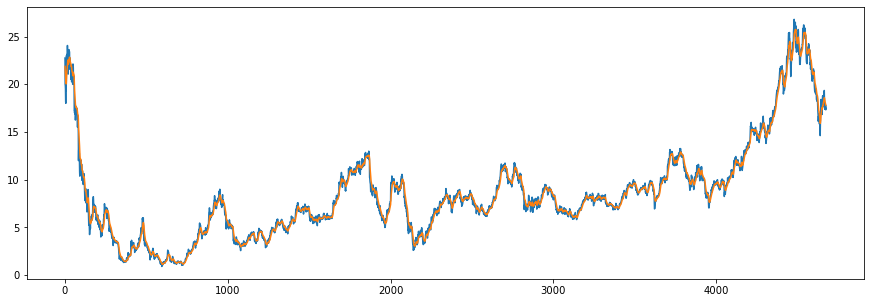

(4661, 15, 5)

In [367]:
seed = 10
df = pd.read_csv('variation 6/initial_indicators/ON_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

df2 = pd.read_csv("variation 6/initial_indicators/TSM_data.csv")
df2.set_index('Date', inplace=True)
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)

X.shape

In [368]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [369]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [370]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [371]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [372]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('ON')]
    y = nr_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_non_recession.csv'.format(experiment,'ON')):
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('support_{}_{}_non_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('ON')]
    y = r_test_data['{}_y'.format('ON')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("variation 6/initial_indicators/{}_data_test2.csv".format('ON'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('support_{}_{}_recession.csv'.format(experiment,'ON')):
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'ON'))
    else:
        log.to_csv('support_{}_{}_recession.csv'.format(experiment,'ON'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.864978902953586, 1: 7.766666666666667, 2: 0.36441837732160315}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2957 - accuracy: 0.5598 - mse: 0.4297 - weighted_accuracy: 0.3057 - weighted_mse: 0.5235 - val_loss: 0.3013 - val_accuracy: 0.0397 - val_mse: 0.3545 - val_weighted_accuracy: 0.0397 - val_weighted_mse: 0.3545
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2142 - accuracy: 0.4185 - mse: 0.7360 - weighted_accuracy: 0.4299 - weighted_mse: 0.7329 - val_loss: 0.2926 - val_accuracy: 0.0429 - val_mse: 0.3792 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.3792
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.3605 - mse: 0.9735 - weighted_accuracy: 0.4930 - weighted_mse: 0.9484 - val_loss: 0.2800 - val_accuracy: 0.0429 - val_mse: 0.4090 - val_weighted_accuracy: 0.0429 - val_weighted_mse: 0.4090
Epoch 4/20
30/30 [==============================] - 0s 7

7/7 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.4977 - mse: 1.0664 - weighted_accuracy: 0.4977 - weighted_mse: 1.0664
Test loss: 0.17387762665748596
Test accuracy: 0.49771690368652344


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 54
actual holds but predicted sell: 42
actual predicted holds: 102
Percentage buys correct: 5.0%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 90.26548672566372%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 48.888888888888886%
Percentage mid holds correct: 84.070796460177%


Capital: 100
Share price: $0.5693952263143247
Shares owned at the moment: 175
Cash capital at the moment: $0.0818139423294042


Price increase fro

Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1168 - accuracy: 0.5209 - mse: 1.8777 - weighted_accuracy: 0.7994 - weighted_mse: 1.8598 - val_loss: 0.1827 - val_accuracy: 0.4512 - val_mse: 1.9582 - val_weighted_accuracy: 0.4512 - val_weighted_mse: 1.9582
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1173 - accuracy: 0.5260 - mse: 1.8887 - weighted_accuracy: 0.7933 - weighted_mse: 1.8810 - val_loss: 0.1902 - val_accuracy: 0.4330 - val_mse: 1.8963 - val_weighted_accuracy: 0.4330 - val_weighted_mse: 1.8963
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1155 - accuracy: 0.5142 - mse: 1.9570 - weighted_accuracy: 0.7930 - weighted_mse: 1.9577 - val_loss: 0.1820 - val_accuracy: 0.4469 - val_mse: 2.0514 - val_weighted_accuracy: 0.4469 - val_weighted_mse: 2.0514
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.5453 - mse: 1.9425 - weighted_accuracy: 0.7983 - weighted

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1132 - accuracy: 0.5526 - mse: 1.9792 - weighted_accuracy: 0.8129 - weighted_mse: 1.9906 - val_loss: 0.1808 - val_accuracy: 0.4684 - val_mse: 2.1114 - val_weighted_accuracy: 0.4684 - val_weighted_mse: 2.1114
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1106 - accuracy: 0.5475 - mse: 2.0237 - weighted_accuracy: 0.8031 - weighted_mse: 2.0402 - val_loss: 0.1726 - val_accuracy: 0.5048 - val_mse: 2.1318 - val_weighted_accuracy: 0.5048 - val_weighted_mse: 2.1318
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1098 - accuracy: 0.5810 - mse: 2.0325 - weighted_accuracy: 0.8133 - weighted_mse: 2.0585 - val_loss: 0.1888 - val_accuracy: 0.4641 - val_mse: 2.1312 - val_weighted_accuracy: 0.4641 - val_weighted_mse: 2.1312
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1092 - accuracy: 0.5416 - mse: 2.0740 - weighted_accuracy: 0.8109 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1553 - accuracy: 0.6347 - mse: 2.2833 - weighted_accuracy: 0.6347 - weighted_mse: 2.2833
Test loss: 0.15529759228229523
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 28
actual holds but predicted sell: 36
actual predicted holds: 134
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 89.33333333333333%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 82.5503355704698%


Capital: 100
Share price: $0.44930888892413384
Shares owned at the moment: 221
Cash capital at the moment: $0.42966807052278


Price i

Epoch 16/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0738 - accuracy: 0.7645 - mse: 3.2321 - weighted_accuracy: 0.9082 - weighted_mse: 3.3954 - val_loss: 0.1890 - val_accuracy: 0.5595 - val_mse: 3.6621 - val_weighted_accuracy: 0.5595 - val_weighted_mse: 3.6621
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0776 - accuracy: 0.7481 - mse: 3.3332 - weighted_accuracy: 0.8982 - weighted_mse: 3.4898 - val_loss: 0.1866 - val_accuracy: 0.5606 - val_mse: 3.7374 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 3.7374
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0748 - accuracy: 0.7524 - mse: 3.3177 - weighted_accuracy: 0.9038 - weighted_mse: 3.4716 - val_loss: 0.1697 - val_accuracy: 0.5981 - val_mse: 3.5318 - val_weighted_accuracy: 0.5981 - val_weighted_mse: 3.5318
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0724 - accuracy: 0.7597 - mse: 3.4178 - weighted_accuracy: 0.9104 - weighte

30/30 [==============================] - 0s 9ms/step - loss: 0.0702 - accuracy: 0.7731 - mse: 3.4875 - weighted_accuracy: 0.9153 - weighted_mse: 3.6490 - val_loss: 0.1715 - val_accuracy: 0.6377 - val_mse: 4.0362 - val_weighted_accuracy: 0.6377 - val_weighted_mse: 4.0362
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 0.7782 - mse: 3.6137 - weighted_accuracy: 0.9152 - weighted_mse: 3.8019 - val_loss: 0.1562 - val_accuracy: 0.6474 - val_mse: 4.0238 - val_weighted_accuracy: 0.6474 - val_weighted_mse: 4.0238
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0673 - accuracy: 0.7910 - mse: 3.6680 - weighted_accuracy: 0.9199 - weighted_mse: 3.8336 - val_loss: 0.1881 - val_accuracy: 0.5713 - val_mse: 3.8564 - val_weighted_accuracy: 0.5713 - val_weighted_mse: 3.8564
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.7672 - mse: 3.6863 - weighted_accuracy: 0.9131 - weighted_mse: 3.8927 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.7991 - mse: 4.5985 - weighted_accuracy: 0.7991 - weighted_mse: 4.5985
Test loss: 0.14493145048618317
Test accuracy: 0.7990867495536804


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 15
actual predicted holds: 172
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 90.52631578947368%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 83.06878306878306%


Capital: 100
Share price: $0.3745788065559236
Shares owned at the moment: 266
Cash capital at the moment: $0.088033059128648


Pri

Validation loss: 0.1624593287706375
Validation accuracy: 0.7416934370994568


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1707 - accuracy: 0.7569 - mse: 6.8929 - weighted_accuracy: 0.7569 - weighted_mse: 6.8929
Test loss: 0.17074903845787048
Test accuracy: 0.7568807601928711


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 16
actual predicted holds: 162
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.50279329608938%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 41.1764705882353%
Percentage mid holds correct: 83.79888268156425%


Capital: 100
Share price: $0.66566

30/30 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9077 - mse: 7.1827 - weighted_accuracy: 0.9664 - weighted_mse: 6.9659 - val_loss: 0.1796 - val_accuracy: 0.7385 - val_mse: 7.8184 - val_weighted_accuracy: 0.7385 - val_weighted_mse: 7.8184
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0365 - accuracy: 0.8970 - mse: 7.2102 - weighted_accuracy: 0.9625 - weighted_mse: 6.9306 - val_loss: 0.1746 - val_accuracy: 0.7503 - val_mse: 7.7398 - val_weighted_accuracy: 0.7503 - val_weighted_mse: 7.7398
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9034 - mse: 7.2898 - weighted_accuracy: 0.9648 - weighted_mse: 7.0954 - val_loss: 0.1665 - val_accuracy: 0.7942 - val_mse: 8.4165 - val_weighted_accuracy: 0.7942 - val_weighted_mse: 8.4165
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0319 - accuracy: 0.9158 - mse: 7.4598 - weighted_accuracy: 0.9693 - weighted_mse: 7.2360

Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9217 - mse: 8.5538 - weighted_accuracy: 0.9675 - weighted_mse: 8.1163 - val_loss: 0.1827 - val_accuracy: 0.7503 - val_mse: 8.8308 - val_weighted_accuracy: 0.7503 - val_weighted_mse: 8.8308
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0295 - accuracy: 0.9278 - mse: 8.5566 - weighted_accuracy: 0.9737 - weighted_mse: 8.0339 - val_loss: 0.1826 - val_accuracy: 0.7503 - val_mse: 8.8364 - val_weighted_accuracy: 0.7503 - val_weighted_mse: 8.8364
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0302 - accuracy: 0.9198 - mse: 8.6226 - weighted_accuracy: 0.9708 - weighted_mse: 8.2455 - val_loss: 0.1871 - val_accuracy: 0.7663 - val_mse: 9.1465 - val_weighted_accuracy: 0.7663 - val_weighted_mse: 9.1465
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0296 - accuracy: 0.9222 - mse: 8.6278 - weighted_accuracy: 0.9697 - weighted_mse

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0234 - accuracy: 0.9453 - mse: 10.5256 - weighted_accuracy: 0.9801 - weighted_mse: 9.5901 - val_loss: 0.2150 - val_accuracy: 0.8028 - val_mse: 12.4624 - val_weighted_accuracy: 0.8028 - val_weighted_mse: 12.4624
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9447 - mse: 10.8106 - weighted_accuracy: 0.9799 - weighted_mse: 9.8244 - val_loss: 0.2043 - val_accuracy: 0.7824 - val_mse: 11.1696 - val_weighted_accuracy: 0.7824 - val_weighted_mse: 11.1696
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9480 - mse: 10.8248 - weighted_accuracy: 0.9810 - weighted_mse: 9.7711 - val_loss: 0.2017 - val_accuracy: 0.7738 - val_mse: 10.8529 - val_weighted_accuracy: 0.7738 - val_weighted_mse: 10.8529
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9429 - mse: 10.9081 - weighted_accuracy: 0.9792 - we

30/30 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.9560 - mse: 12.9511 - weighted_accuracy: 0.9840 - weighted_mse: 11.4294 - val_loss: 0.2408 - val_accuracy: 0.8124 - val_mse: 15.1086 - val_weighted_accuracy: 0.8124 - val_weighted_mse: 15.1086
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9600 - mse: 13.2940 - weighted_accuracy: 0.9854 - weighted_mse: 11.6626 - val_loss: 0.2292 - val_accuracy: 0.7781 - val_mse: 12.9053 - val_weighted_accuracy: 0.7781 - val_weighted_mse: 12.9053
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9624 - mse: 13.2306 - weighted_accuracy: 0.9863 - weighted_mse: 11.5105 - val_loss: 0.2249 - val_accuracy: 0.8071 - val_mse: 13.4031 - val_weighted_accuracy: 0.8071 - val_weighted_mse: 13.4031
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9622 - mse: 13.3960 - weighted_accuracy: 0.9862 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.8402 - mse: 15.6160 - weighted_accuracy: 0.8402 - weighted_mse: 15.6160
Test loss: 0.2688464820384979
Test accuracy: 0.8401826620101929


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 6
actual holds but predicted sell: 8
actual predicted holds: 184
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.7560975609756%
actual buys: 11
actual sells: 10
actual holds: 198


Percentage low buys correct: 16.666666666666668%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.3745788065559236
Shares owned at the moment: 266
Cash capital at the moment: $0.088033059128648


Price increase from previously bought: -31.0953

In [373]:
df = nr_log_hist['epochs_logs']
df.head(20)

Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.504587      9.523810      10.416667      92.523364   
1       0.454128      6.153846       7.843137      89.215686   
2       0.587156      4.444444      10.526316      90.370370   
3       0.674312      3.225806       7.692308      89.440994   
4       0.729358      4.347826       9.090909      90.173410   
5       0.756881      4.761905      11.111111      90.502793   
6       0.825688      7.142857      20.000000      91.237113   
7       0.834862      7.142857      25.000000      91.326531   
8       0.830275      7.142857      14.285714      90.862944   
9       0.825688      7.692308      18.181818      91.237113   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         49.206349           55.319149          85.046729     407.411326   
1         47.692308           50.000000          82.352941      -5.620133   
2         48.888889           45.945946          83.703704     -31.919112   
3         54.838710           44.000000          82.608696     -62.315765   
4         56.521739           47.619048          83.236994      17.629818   
5         57.142857           41.176471          83.798883     -20.191984   
6         57.142857           50.000000          84.455959     156.160921   
7         50.000000           37.500000          84.102564      76.471364   
8         50.000000           28.571429          83.673469      76.471364   
9         61.538462           45.454545          83.937824      35.194130   

   buy_n_hold profit  
0          27.578476  
1          27.578476  
2          27.578476  
3          27.578476  
4          27.578476  
5          27.578476  
6          27.578476  
7          27.578476  
8          27.578476  
9          27.578476

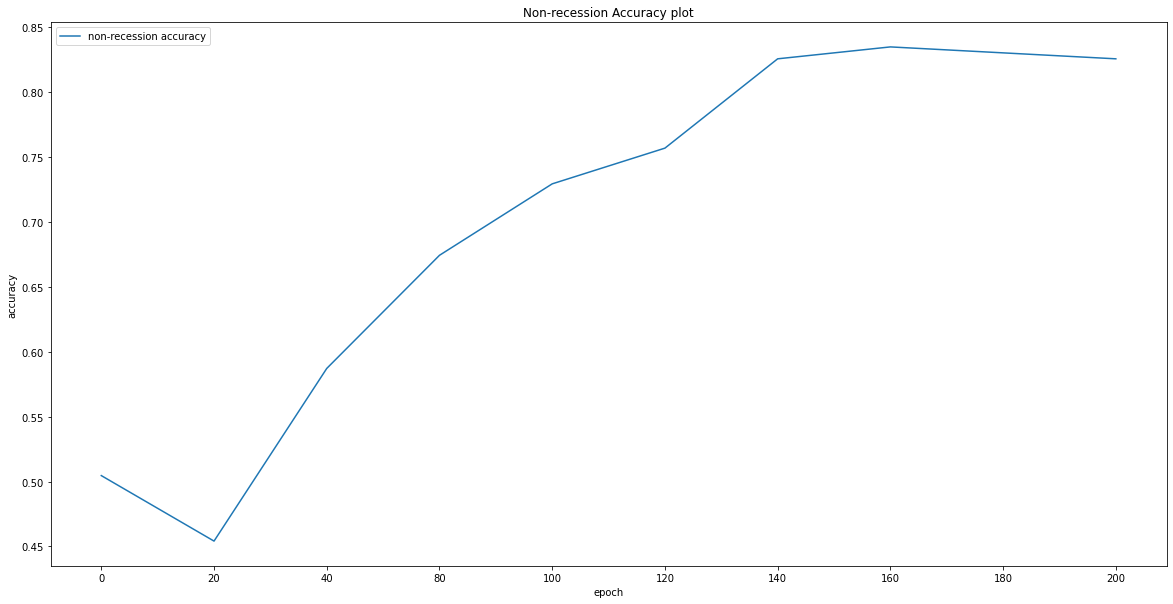

In [374]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

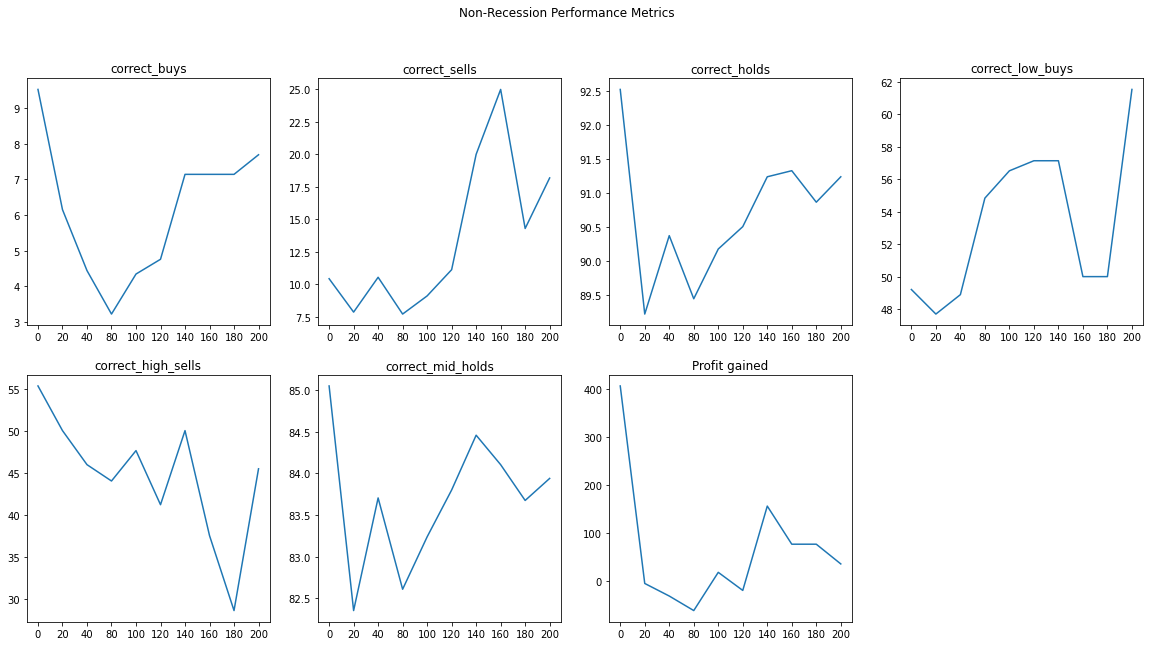

In [375]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

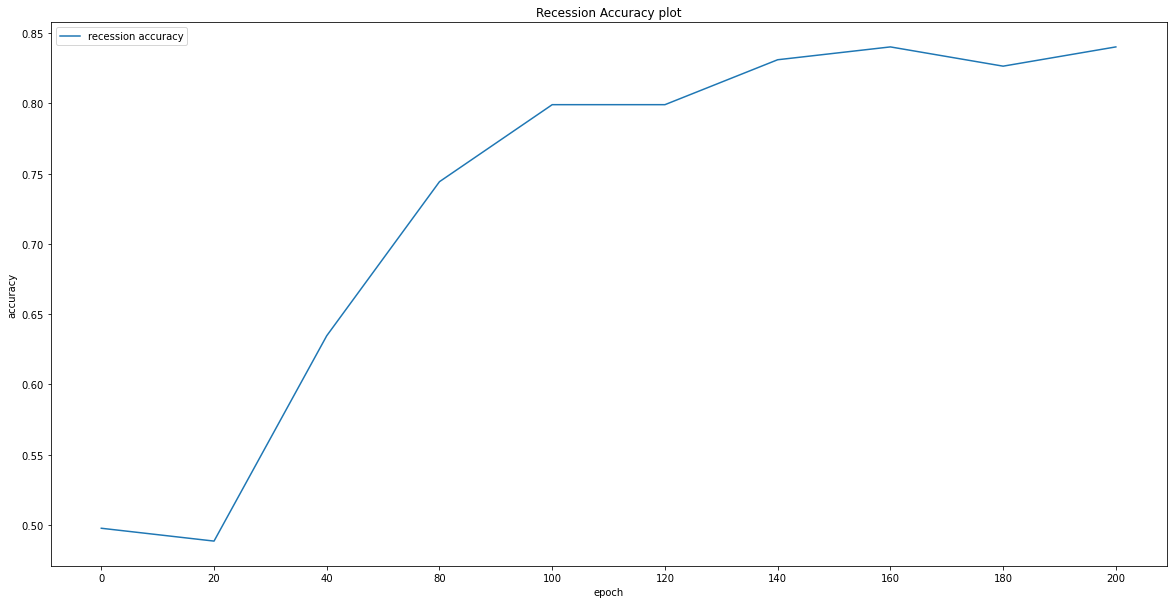

In [376]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()


Text(0.5, 1.0, 'Profit gained')

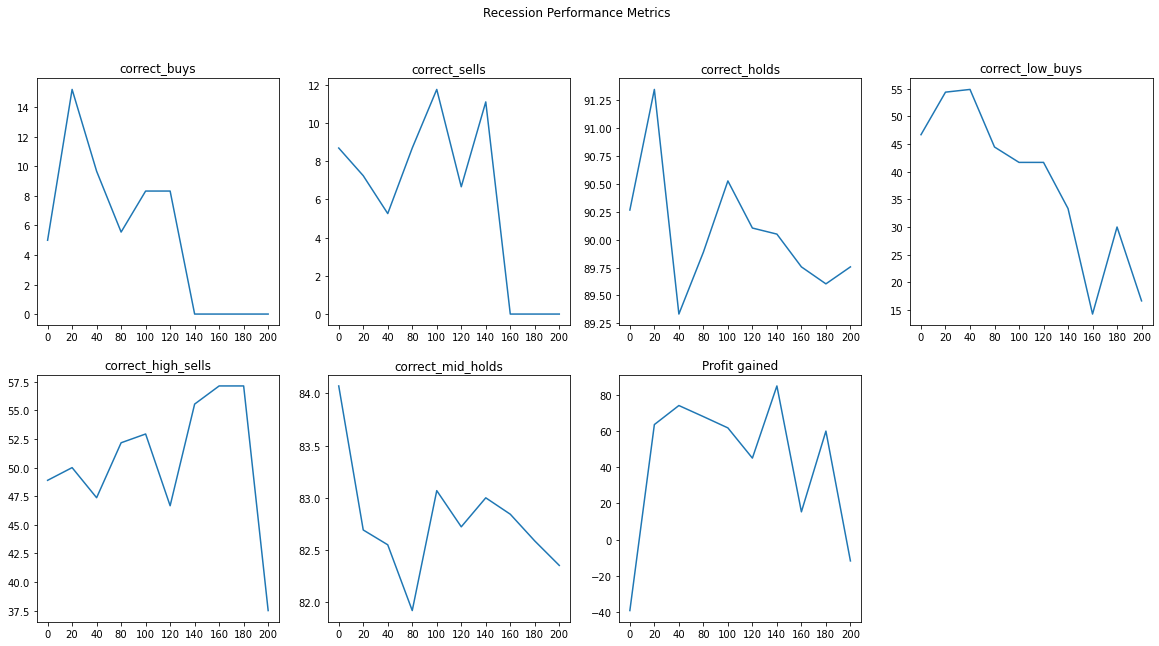

In [377]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")